# 2022 BRFSS Survey Data Cleaning

## Data Source and Methodology

Centers for Disease Control and Prevention. (2023). Behavioral Risk Factor Surveillance System Survey Data. U.S. Department of Health and Human Services, Centers for Disease Control and Prevention. https://www.cdc.gov/brfss/annual_data/annual_2022.html

The Behavioral Risk Factor Surveillance System (BRFSS) is a collaborative project between all of the states in the United States (US) and participating US territories and the Centers for Disease Control and Prevention (CDC). The BRFSS is administered and supported by CDC's Population Health Surveillance Branch, under the Division of Population Health at the National Center for Chronic Disease Prevention and Health Promotion.

The BRFSS is a system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The survey methodology includes:
- Random-digit-dialed telephone survey of adults 18 years and older
- Both landline and cellular telephone samples
- Complex sampling design to ensure representativeness of the US adult population
- Weighting to adjust for noncoverage and nonresponse bias

Key aspects of the dataset:
- Sample size: 445,132 respondents
- 328 variables covering various health behaviors, chronic conditions, and demographic information
- Includes calculated variables such as BMI and derived health status indicators



# Data Description

   - Data Source: 2022 BRFSS Survey Data from CDC
     (https://www.cdc.gov/brfss/annual_data/annual_2022.html)
   - Dataset: https://www.cdc.gov/brfss/annual_data/2022/files/LLCP2022XPT.zip
   - Codebook: https://www.cdc.gov/brfss/annual_data/2022/zip/codebook22_llcp-v2-508.zip

## Detailed Data Description
- Number of samples (rows) before cleaning: 445,132
- Number of features (columns) before cleaning: 328
- Data types: 
  - Categorical (binary): _SEX, MEDCOST1, CVDINFR4, CVDCRHD4, CVDSTRK3, CHCSCNC1, CHCOCNC1, CHCCOPD3, ADDEPEV3, CHCKDNY2, DIFFWALK, DIFFDRES, DIFFALON, SMOKE100, SDHISOLT, SDHEMPLY, FOODSTMP, SDHBILLS, SDHUTILS, SDHTRNSP, _METSTAT, _URBSTAT, _TOTINDA, _LTASTH1, _CASTHM1, _DRDXAR2, _RFBING6
  - Categorical: PRIMINSR RENTHOM1 EMPLOY1 _IMPRACE
  - Numerical (ordinal, discrete): _ASTHMS1, PERSDOC3, GENHLTH, POORHLTH, CHECKUP1, SLEPTIM1, LASTDEN4, INCOME3, SMOKDAY2, USENOW3, LCSFIRST, LCSLAST, LCSNUMCG, ALCDAY4, MAXDRNKS, LSATISFY, EMTSUPRT, SDHFOOD1, SDHSTRE1, _PHYS14D, _MENT14D, _AGEG5YR, , _EDUCAG, _DRNKWK2
  - Numerical (ordinal): HTM4, WTKG3, _BMI5

## Feature Categories:
   1. Demographic information (e.g., sex, age, education, income)
   2. Health status indicators (e.g., general health, physical health, mental health)
   3. Medical history (e.g., heart conditions, cancer, arthritis)
   4. Lifestyle factors (e.g., smoking, alcohol consumption, physical activity)
   5. Socioeconomic factors (e.g., employment, food security, transportation)

   This dataset provides a comprehensive view of various factors that may influence diabetes risk, allowing for a multifaceted analysis of potential predictors.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import helpers

In [2]:
# Define the expected data types for each column to ensure correct parsing
# Int64 is used for categorical variables to allow for NaN values
# float64 is used for continuous numerical variables
# I've cast the net wide, and included as many potentially relevant features from the dataset that make sense as possible.
types = {
    'DIABETE4': 'Int64',   # Ever told had diabetes? (1-4, 7, 9)
    '_SEX': 'Int64',       # Calculated sex variable (1=Male, 2=Female)
    'GENHLTH': 'Int64',    # General health status (1-5, 7, 9)
    'PHYSHLTH': 'Int64',   # Physical health (days not good) (0-30, 77, 99)
    'MENTHLTH': 'Int64',   # Mental health (days not good) (0-30, 77, 99)
    'POORHLTH': 'Int64',   # Days poor health prevented usual activities (0-30, 77, 99)
    'PRIMINSR': 'Int64',   # Primary insurance type (1-6, 7, 9)
    'PERSDOC3': 'Int64',   # Have personal doctor? (1=One, 2=More than one, 3=No, 7, 9)
    'MEDCOST1': 'Int64',   # Unable to get medical care due to cost (1=Yes, 2=No, 7, 9)
    'CHECKUP1': 'Int64',   # Duration since last routine checkup (1-6, 7, 9)
    'EXERANY2': 'Int64',   # Exercise in past 30 days? (1=Yes, 2=No, 7, 9)
    'SLEPTIM1': 'Int64',   # Hours of sleep (0-24, 77, 99)
    'LASTDEN4': 'Int64',   # Duration since last dental visit (1-6, 7, 9)
    'CVDINFR4': 'Int64',   # Ever told had heart attack (1=Yes, 2=No, 7, 9)
    'CVDCRHD4': 'Int64',   # Ever told had angina (1=Yes, 2=No, 7, 9)
    'CVDSTRK3': 'Int64',   # Ever told had stroke (1=Yes, 2=No, 7, 9)
    'ASTHMA3': 'Int64',    # Ever told had asthma (1=Yes, 2=No, 7, 9)
    'ASTHNOW': 'Int64',    # Still have asthma (1=Yes, 2=No, 7, 9)  ## DROPPED; better in _CASTHM1 to avoid na's
    'CHCSCNC1': 'Int64',   # Ever told had skin cancer (1=Yes, 2=No, 7, 9)
    'CHCOCNC1': 'Int64',   # Ever told had any other type of cancer (1=Yes, 2=No, 7, 9)
    'CHCCOPD3': 'Int64',   # Ever told had COPD (1=Yes, 2=No, 7, 9)
    'ADDEPEV3': 'Int64',   # Ever told had depressive disorder (1=Yes, 2=No, 7, 9)
    'CHCKDNY2': 'Int64',   # Ever told had kidney disease (1=Yes, 2=No, 7, 9)
    'HAVARTH4': 'Int64',   # Ever told had arthritis (1=Yes, 2=No, 7, 9)
    'EDUCA': 'Int64',      # Education level (1-6, 9)
    'RENTHOM1': 'Int64',   # Own or rent home (1=Own, 2=Rent, 3=Other, 7, 9)
    'EMPLOY1': 'Int64',    # Employment status (1-8, 9)
    'INCOME3': 'Int64',    # Income level (1-8, 77, 99)
    'WEIGHT2': 'float64',  # Weight in pounds
    'HEIGHT3': 'float64',  # Height in inches
    'DIFFWALK': 'Int64',   # Difficulty walking or climbing stairs (1=Yes, 2=No, 7, 9)
    'DIFFDRES': 'Int64',   # Difficulty dressing or bathing (1=Yes, 2=No, 7, 9)
    'DIFFALON': 'Int64',   # Difficulty doing errands alone (1=Yes, 2=No, 7, 9)
    'SMOKE100': 'Int64',   # Smoked at least 100 cigarettes (1=Yes, 2=No, 7, 9)
    'SMOKDAY2': 'Int64',   # Currently smoking (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'USENOW3': 'Int64',    # Currently using tobacco (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'ECIGNOW2': 'Int64',   # Currently using e-cigarettes (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'LCSFIRST': 'Int64',   # Age began smoking (0-99, 777, 888, 999)
    'LCSLAST': 'Int64',    # Age last smoked (0-99, 777, 888, 999)
    'LCSNUMCG': 'Int64',   # Average number of cigarettes per day (0-300, 777, 888, 999)
    'ALCDAY4': 'Int64',    # Alcohol consumption frequency (1-6, 7, 9)
    'AVEDRNK3': 'Int64',   # Average number of drinks (1-76, 77, 99)
    'DRNK3GE5': 'Int64',   # Binge drinking frequency (1-76, 77, 99)
    'MAXDRNKS': 'Int64',   # Maximum number of drinks on any occasion (1-76, 77, 99)
    'PREDIAB2': 'Int64',   # Ever told had pre-diabetes (1=Yes, 2=No, 7, 9)
    'DIABTYPE': 'Int64',   # Type of diabetes (1=Type 1, 2=Type 2, 3=Gestational, 7, 9)
    'INSULIN1': 'Int64',   # Currently taking insulin (1=Yes, 2=No, 7, 9)
    'FEETSORE': 'Int64',   # Sores or irritations on feet that refused to heal (1=Yes, 2=No, 7, 9)
    'LSATISFY': 'Int64',   # Satisfied with life (1=Very satisfied, 2=Somewhat satisfied, 3=Not at all, 7, 9)
    'EMTSUPRT': 'Int64',   # Have enough emotional support (1=Always, 2=Usually, 3=Sometimes, 4=Rarely, 5=Never, 7, 9)
    'SDHISOLT': 'Int64',   # Socially isolated (1=Yes, 2=No, 7, 9)
    'SDHEMPLY': 'Int64',   # Lost employment (1=Yes, 2=No, 7, 9)
    'FOODSTMP': 'Int64',   # Food stamps (1=Yes, 2=No, 7, 9)
    'SDHFOOD1': 'Int64',   # Food scarcity (1=Often, 2=Sometimes, 3=Rarely, 4=Never, 7, 9)
    'SDHBILLS': 'Int64',   # Unable to pay bills (1=Yes, 2=No, 7, 9)
    'SDHUTILS': 'Int64',   # Unable to pay utilities (1=Yes, 2=No, 7, 9)
    'SDHTRNSP': 'Int64',   # Lack of reliable transport (1=Yes, 2=No, 7, 9)
    'SDHSTRE1': 'Int64',   # Stressed (1=Always, 2=Usually, 3=Sometimes, 4=Rarely, 5=Never, 7, 9)
    'MARIJAN1': 'Int64',   # Used marijuana (1=Yes, 2=No, 7, 9)
    'MARJSMOK': 'Int64',   # Smoked marijuana (1=Yes, 2=No, 7, 9)
    'MARJEAT': 'Int64',    # Consumed marijuana edibles (1=Yes, 2=No, 7, 9)
    'MARJVAPE': 'Int64',   # Vaped marijuana (1=Yes, 2=No, 7, 9)
    'MARJDAB': 'Int64',    # Dabbed marijuana (1=Yes, 2=No, 7, 9)
    'MARJOTHR': 'Int64',   # Used other forms of marijuana (1=Yes, 2=No, 7, 9)
    'LASTSMK2': 'Int64',   # Time since last smoked (1-6, 7, 9)
    'STOPSMK2': 'Int64',   # Trying to quit smoking (1=Yes, 2=No, 7, 9)
    'MENTCIGS': 'Int64',   # Smokes menthols (1=Yes, 2=No, 7, 9)
    'MENTECIG': 'Int64',   # Uses menthol e-cigarettes (1=Yes, 2=No, 7, 9)
    '_METSTAT': 'Int64',   # Metropolitan status (1=Yes, 2=No)
    '_URBSTAT': 'Int64',   # Urban status (1=Yes, 2=No)
    '_IMPRACE': 'Int64',   # Imputed race/ethnicity (1-8)
    '_PHYS14D': 'Int64',   # Computed physical health status (1-3)
    '_MENT14D': 'Int64',   # Computed mental health status (1-3)
    '_TOTINDA': 'Int64',   # Leisure time physical activity (1=Active, 2=Inactive)
    '_MICHD': 'Int64',     # Computed CHD/MI (1=Yes, 2=No)
    '_LTASTH1': 'Int64',   # Computed lifetime asthma (1=Yes, 2=No)
    '_CASTHM1': 'Int64',   # Computed current asthma (1=Yes, 2=No)
    '_ASTHMS1': 'Int64',   # Computed asthma status (1=Current, 2=Former, 3=Never)
    '_DRDXAR2': 'Int64',   # Computed arthritis (1=Yes, 2=No)
    '_AGEG5YR': 'Int64',   # Age bucket (1-13)
    '_BMI5': 'float64',    # Computed BMI
    '_EDUCAG': 'Int64',    # Education completed (1-4)
    '_RFBING6': 'Int64',   # Binge drinking (1=Yes, 2=No)
    '_DRNKWK2': 'Int64',   # Drinks per week (1-990)
    '_YRSQUIT': 'Int64',   # Years since quitting smoking
    'HTM4': 'Int64',       # Height in centimeters (which for some reason, they describe as height in meters with an implied two decimal places)
    'WTKG3': 'Int64',      # Weight in Kg
}


In [3]:
rawdf = pd.read_sas('./LLCP2022.XPT')

In [4]:
rawdf.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
1     1.0     1.0  b'02042022'  b'02'  b'04'  b'2022'    1100.0   
2     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   
3     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
4     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   

           SEQNO          _PSU  CTELENM1  ...  _SMOKGRP  _LCSREC  DRNKANY6  \
0  b'2022000001'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
1  b'2022000002'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
2  b'2022000003'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
3  b'2022000004'  2.022000e+09       1.0  ...       3.0      2.0       2.0   
4  b'2022000005'  2.022000e+09       1.0  ...       4.0      NaN       1.0   

       DROCDY4_  _RFBING6      _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  \
0  5.397605e-79       1.0  5.397605e-79       1.0       1.0       2.0   
1  5.397605e-79       1.0  5.397605e-79       1.0       2.0       2.0   
2  5.397605e-79       1.0  5.397605e-79       1.0       NaN       NaN   
3  5.397605e-79       1.0  5.397605e-79       1.0       9.0       9.0   
4  1.000000e+01       1.0  1.400000e+02       1.0       NaN       NaN   

   _AIDTST4  
0       2.0  
1       2.0  
2       2.0  
3       2.0  
4       2.0  

[5 rows x 328 columns]

In [5]:
rawdf.shape

(445132, 328)

In [6]:
# '0' is getting converted via floating point error to '5.397605e-79' for this column; we need to change it back
rawdf.loc[rawdf['MAXDRNKS'] < 1, 'MAXDRNKS'] = 0
rawdf.loc[rawdf['LCSNUMCG'] < 1, 'LCSNUMCG'] = 0

In [7]:
df = pd.DataFrame()
for c, dtype in types.items():
    downcast = None
    if dtype == 'Int64':
        downcast='integer'    
    df[c] = pd.to_numeric(rawdf[c], errors='coerce', downcast=downcast).astype(dtype=dtype)

In [8]:
original_df = df.copy()
pd.set_option('display.max_rows', 10)
display(helpers.analyze_missing_data(df))

Missing Count  Missing Percentage  Rows Retained  \
MENTECIG         442968               99.51           2164   
MENTCIGS         440138               98.88            694   
MARJOTHR         433645               97.42             94   
MARJDAB          433637               97.42             94   
MARJVAPE         433629               97.42             94   
...                 ...                 ...            ...   
EXERANY2              2                0.00              0   
CHCSCNC1              2                0.00              0   
ASTHMA3               2                0.00              0   
CVDSTRK3              2                0.00              0   
CVDCRHD4              2                0.00              0   

          Retention Percentage  
MENTECIG                  0.49  
MENTCIGS                  0.16  
MARJOTHR                  0.02  
MARJDAB                   0.02  
MARJVAPE                  0.02  
...                        ...  
EXERANY2                  0.00  
CHCSCNC1                  0.00  
ASTHMA3                   0.00  
CVDSTRK3                  0.00  
CVDCRHD4                  0.00  

[75 rows x 4 columns]

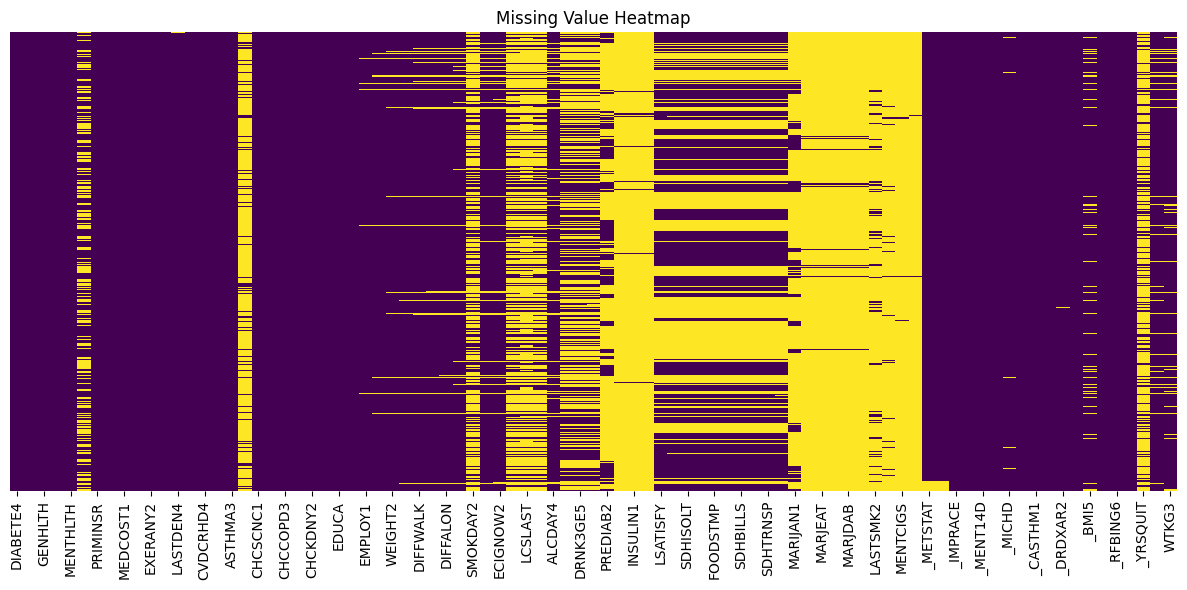

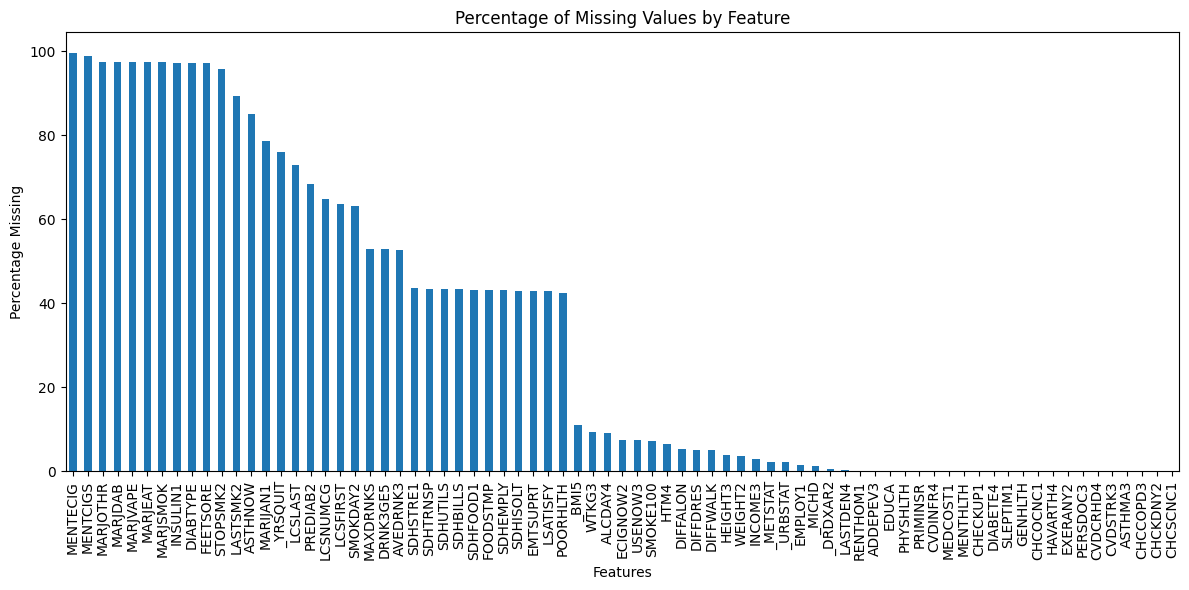

In [9]:
helpers.plot_missing_values(original_df)

## Create target variable

In [10]:
# For our target variable, we're going to consider pre-diabetes and diabetes as equivalent. We will be predicting whether or not somebody is likely to be pre-diabetic, or diabetic, based on the other features.
# We will convert 'no', or 'only during pregnancy' to `0`, and 'yes', and 'prediabetic' to `1`

# Remove any rows where the answer isn't clear
df = df[df['DIABETE4'].isin([1,2,3,4])]

# remove any who were not sure about pre-diabetes
df = df[~df['PREDIAB2'].isin([7,9])]

df['diabetes'] = (df['DIABETE4'].isin([1,4])) | (df['PREDIAB2'] == 1)
df['diabetes'] = df['diabetes'].fillna(False)

## Handling Missing and Unknown Values

In the BRFSS survey, missing or unknown values are often coded as specific numbers (e.g., 7, 9, 77, 99). We need to handle these separately from truly missing (NaN) values. Our strategy is:

1. For most variables, we'll remove rows with "don't know" or "refused" responses (usually coded as 7 and 9).
2. For some variables, we'll treat these responses as a separate category or impute them based on other information.
3. For variables with a large number of missing values, we'll consider whether to drop the variable or impute the values.

In [11]:
seven_nine_unknowns = {
    'GENHLTH': 'Int64',    # General health status (1-5, 7, 9)
    'PERSDOC3': 'Int64',   # Have personal doctor? (1=Yes, 2=No, 7, 9)
    'MEDCOST1': 'Int64',   # Unable to get medical care due to cost (1=Yes, 2=No, 7, 9)
    'CHECKUP1': 'Int64',   # Duration since last routine checkup (1-6, 7, 9)
    'EXERANY2': 'Int64',   # Exercise in past 30 days? (1=Yes, 2=No, 7, 9)
    'LASTDEN4': 'Int64',   # Duration since last dental visit (1-6, 7, 9)
    'CVDINFR4': 'Int64',   # Ever told had heart attack (1=Yes, 2=No, 7, 9)
    'CVDCRHD4': 'Int64',   # Ever told had angina (1=Yes, 2=No, 7, 9)
    'CVDSTRK3': 'Int64',   # Ever told had stroke (1=Yes, 2=No, 7, 9)
    'ASTHMA3': 'Int64',    # Ever told had asthma (1=Yes, 2=No, 7, 9)
    'ASTHNOW': 'Int64',    # Still have asthma (1=Yes, 2=No, 7, 9)
    'CHCSCNC1': 'Int64',   # Ever told had skin cancer (1=Yes, 2=No, 7, 9)
    'CHCOCNC1': 'Int64',   # Ever told had any other type of cancer (1=Yes, 2=No, 7, 9)
    'CHCCOPD3': 'Int64',   # Ever told had COPD (1=Yes, 2=No, 7, 9)
    'ADDEPEV3': 'Int64',   # Ever told had depressive disorder (1=Yes, 2=No, 7, 9)
    'CHCKDNY2': 'Int64',   # Ever told had kidney disease (1=Yes, 2=No, 7, 9)
    'HAVARTH4': 'Int64',   # Ever told had arthritis (1=Yes, 2=No, 7, 9)
    'EDUCA':    'Int64',   # Education level (1-6, 9)
    'RENTHOM1': 'Int64',   # Own or rent home (1=Own, 2=Rent, 3=Other, 7, 9)
    'DIFFWALK': 'Int64',   # Difficulty walking or climbing stairs (1=Yes, 2=No, 7, 9)
    'DIFFDRES': 'Int64',   # Difficulty dressing or bathing (1=Yes, 2=No, 7, 9)
    'DIFFALON': 'Int64',   # Difficulty doing errands alone (1=Yes, 2=No, 7, 9)
    'SMOKE100': 'Int64',   # Smoked at least 100 cigarettes (1=Yes, 2=No, 7, 9)
    'SMOKDAY2': 'Int64',   # Currently smoking (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'USENOW3':  'Int64',   # Currently using tobacco (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'ECIGNOW2': 'Int64',   # Currently using e-cigarettes (1=Every day, 2=Some days, 3=Not at all, 7, 9)
    'ALCDAY4':  'Int64',   # Alcohol consumption frequency (1-6, 7, 9)
    'PREDIAB2': 'Int64',   # Ever told had pre-diabetes (1=Yes, 2=No, 7, 9)
    'DIABTYPE': 'Int64',   # Type of diabetes (1=Type 1, 2=Type 2, 3=Gestational, 7, 9)
    'INSULIN1': 'Int64',   # Currently taking insulin (1=Yes, 2=No, 7, 9)
    'FEETSORE': 'Int64',   # Sores or irritations on feet that refused to heal (1=Yes, 2=No, 7, 9)
    'LSATISFY': 'Int64',   # Satisfied with life (1=Very satisfied, 2=Somewhat satisfied, 3=Not at all, 7, 9)
    'EMTSUPRT': 'Int64',   # Have enough emotional support (1=Always, 2=Usually, 3=Sometimes, 4=Rarely, 5=Never, 7, 9)
    'SDHISOLT': 'Int64',   # Socially isolated (1=Yes, 2=No, 7, 9)
    'SDHEMPLY': 'Int64',   # Lost employment (1=Yes, 2=No, 7, 9)
    'FOODSTMP': 'Int64',   # Food stamps (1=Yes, 2=No, 7, 9)
    'SDHFOOD1': 'Int64',   # Food scarcity (1=Often, 2=Sometimes, 3=Rarely, 4=Never, 7, 9)
    'SDHBILLS': 'Int64',   # Unable to pay bills (1=Yes, 2=No, 7, 9)
    'SDHUTILS': 'Int64',   # Unable to pay utilities (1=Yes, 2=No, 7, 9)
    'SDHTRNSP': 'Int64',   # Lack of reliable transport (1=Yes, 2=No, 7, 9)
    'SDHSTRE1': 'Int64',   # Stressed (1=Always, 2=Usually, 3=Sometimes, 4=Rarely, 5=Never, 7, 9)
    'MARIJAN1': 'Int64',   # Used marijuana (1=Yes, 2=No, 7, 9)
    'MARJSMOK': 'Int64',   # Smoked marijuana (1=Yes, 2=No, 7, 9)
    'MARJEAT':  'Int64',   # Consumed marijuana edibles (1=Yes, 2=No, 7, 9)
    'MARJVAPE': 'Int64',   # Vaped marijuana (1=Yes, 2=No, 7, 9)
    'MARJDAB':  'Int64',   # Dabbed marijuana (1=Yes, 2=No, 7, 9)
    'MARJOTHR': 'Int64',   # Used other forms of marijuana (1=Yes, 2=No, 7, 9)
    'LASTSMK2': 'Int64',   # Time since last smoked (1-6, 7, 9)
    'STOPSMK2': 'Int64',   # Trying to quit smoking (1=Yes, 2=No, 7, 9)
    'MENTCIGS': 'Int64',   # Smokes menthols (1=Yes, 2=No, 7, 9)
    'MENTECIG': 'Int64',   # Uses menthol e-cigarettes (1=Yes, 2=No, 7, 9)
    '_PHYS14D': 'Int64',   # Computed Physical Health Status, 1=Zero days, 2=1-13 days, 3=14+days
    '_MENT14D': 'Int64',   # Computed Physical Health Status, 1=Zero days, 2=1-13 days, 3=14+days 
    '_RFBING6': 'Int64',   # Bing Drinking
    '_DRNKWK2': 'iNT64',   # Drinks per week
}

for c in seven_nine_unknowns:
    df = df[~df[c].isin([7,9])]

nine_only = {
    'EMPLOY1':  'Int64',   # Employment status (1-8, 9)
}

for c in nine_only:
    df = df[~df[c].isin([9])]

seven_seven_nine_nine = {
    'PRIMINSR': 'Int64',   # Primary insurance type (1-10, 77, 99)
    'PHYSHLTH': 'Int64',   # Physical health (days not good) (0-30, 77, 99)
    'MENTHLTH': 'Int64',   # Mental health (days not good) (0-30, 77, 99)
    'POORHLTH': 'Int64',   # Days poor health prevented usual activities (0-30, 77, 99)
    'SLEPTIM1': 'Int64',   # Hours of sleep (0-24, 77, 99)
    'INCOME3': 'Int64',    # Income level (1-8, 77, 99)
    'AVEDRNK3': 'Int64',   # Average number of drinks (1-76, 77, 99)
    'DRNK3GE5': 'Int64',   # Binge drinking frequency (1-76, 77, 99)
    'MAXDRNKS': 'Int64',   # Maximum number of drinks on any occasion (1-76, 77, 99)
}

for c in seven_seven_nine_nine:
    df = df[~df[c].isin([77,99])]

seven_seven_seven_nine_nine_nine = {
    'LCSFIRST': 'Int64',   # Age began smoking (0-99, 777, 888, 999)
    'LCSLAST': 'Int64',    # Age last smoked (0-99, 777, 888, 999)
    'LCSNUMCG': 'Int64',   # Average number of cigarettes per day (0-300, 777, 888, 999)
}

for c in seven_seven_seven_nine_nine_nine:
    df = df[~df[c].isin([777,999])]
df.shape

(247378, 88)

In [12]:
pd.set_option('display.max_rows', 10)
display(helpers.analyze_missing_data(df))

Missing Count  Missing Percentage  Rows Retained  \
MENTECIG         246042               99.46           1336   
MENTCIGS         244325               98.77            427   
DIABTYPE         241782               97.74             19   
FEETSORE         241782               97.74             19   
INSULIN1         241782               97.74             19   
...                 ...                 ...            ...   
CHECKUP1              1                0.00              0   
EMPLOY1               1                0.00              0   
CHCOCNC1              1                0.00              0   
USENOW3               1                0.00              0   
_MICHD                1                0.00              0   

          Retention Percentage  
MENTECIG                  0.54  
MENTCIGS                  0.17  
DIABTYPE                  0.01  
FEETSORE                  0.01  
INSULIN1                  0.01  
...                        ...  
CHECKUP1                  0.00  
EMPLOY1                   0.00  
CHCOCNC1                  0.00  
USENOW3                   0.00  
_MICHD                    0.00  

[53 rows x 4 columns]

## Recoding Binary Categorical Variables

Binary categorical variables in the dataset are coded numerically as 1=Yes, 2=No. We'll recode these variables to make them suitable as boolean values, and easier to use for our analysis:
Binary variables will be recoded to 0 and 1, where 1 usually represents "Yes" or the presence of a condition.

In [13]:
yesno = {
    '_SEX'    : 'Int64',   # Sex {1=Male, 2=Female}
    'PERSDOC3': 'Int64',   # Have personal doctor? (1=Yes, 2=No, 7, 9)
    'MEDCOST1': 'Int64',   # Unable to get medical care due to cost (1=Yes, 2=No, 7, 9)
    'EXERANY2': 'Int64',   # Exercise in past 30 days? (1=Yes, 2=No, 7, 9)
    'CVDINFR4': 'Int64',   # Ever told had heart attack (1=Yes, 2=No, 7, 9)
    'CVDCRHD4': 'Int64',   # Ever told had angina (1=Yes, 2=No, 7, 9)
    'CVDSTRK3': 'Int64',   # Ever told had stroke (1=Yes, 2=No, 7, 9)
    'ASTHMA3': 'Int64',    # Ever told had asthma (1=Yes, 2=No, 7, 9)
    'ASTHNOW': 'Int64',    # Still have asthma (1=Yes, 2=No, 7, 9)
    'CHCSCNC1': 'Int64',   # Ever told had skin cancer (1=Yes, 2=No, 7, 9)
    'CHCOCNC1': 'Int64',   # Ever told had any other type of cancer (1=Yes, 2=No, 7, 9)
    'CHCCOPD3': 'Int64',   # Ever told had COPD (1=Yes, 2=No, 7, 9)
    'ADDEPEV3': 'Int64',   # Ever told had depressive disorder (1=Yes, 2=No, 7, 9)
    'CHCKDNY2': 'Int64',   # Ever told had kidney disease (1=Yes, 2=No, 7, 9)
    'HAVARTH4': 'Int64',   # Ever told had arthritis (1=Yes, 2=No, 7, 9)
    'DIFFWALK': 'Int64',   # Difficulty walking or climbing stairs (1=Yes, 2=No, 7, 9)
    'DIFFDRES': 'Int64',   # Difficulty dressing or bathing (1=Yes, 2=No, 7, 9)
    'DIFFALON': 'Int64',   # Difficulty doing errands alone (1=Yes, 2=No, 7, 9)
    'SMOKE100': 'Int64',   # Smoked at least 100 cigarettes (1=Yes, 2=No, 7, 9)
    'PREDIAB2': 'Int64',   # Ever told had pre-diabetes (1=Yes, 2=No, 7, 9)
    'DIABTYPE': 'Int64',   # Type of diabetes (1=Type 1, 2=Type 2, 3=Gestational, 7, 9)
    'INSULIN1': 'Int64',   # Currently taking insulin (1=Yes, 2=No, 7, 9)
    'FEETSORE': 'Int64',   # Sores or irritations on feet that refused to heal (1=Yes, 2=No, 7, 9)
    'SDHISOLT': 'Int64',   # Socially isolated (1=Yes, 2=No, 7, 9)
    'SDHEMPLY': 'Int64',   # Lost employment (1=Yes, 2=No, 7, 9)
    'FOODSTMP': 'Int64',   # Food stamps (1=Yes, 2=No, 7, 9)
    'SDHBILLS': 'Int64',   # Unable to pay bills (1=Yes, 2=No, 7, 9)
    'SDHUTILS': 'Int64',   # Unable to pay utilities (1=Yes, 2=No, 7, 9)
    'SDHTRNSP': 'Int64',   # Lack of reliable transport (1=Yes, 2=No, 7, 9)
    'MARIJAN1': 'Int64',   # Used marijuana (1=Yes, 2=No, 7, 9)
    'MARJSMOK': 'Int64',   # Smoked marijuana (1=Yes, 2=No, 7, 9)
    'MARJEAT': 'Int64',    # Consumed marijuana edibles (1=Yes, 2=No, 7, 9)
    'MARJVAPE': 'Int64',   # Vaped marijuana (1=Yes, 2=No, 7, 9)
    'MARJDAB': 'Int64',    # Dabbed marijuana (1=Yes, 2=No, 7, 9)
    'MARJOTHR': 'Int64',   # Used other forms of marijuana (1=Yes, 2=No, 7, 9)
    'STOPSMK2': 'Int64',   # Trying to quit smoking (1=Yes, 2=No, 7, 9)
    'MENTCIGS': 'Int64',   # Smokes menthols (1=Yes, 2=No, 7, 9)
    'MENTECIG': 'Int64',   # Uses menthol e-cigarettes (1=Yes, 2=No, 7, 9)
    '_METSTAT': 'Int64',   # Metropolitan status (1=Yes, 2=No)
    '_URBSTAT': 'Int64',   # Urban status (1=Yes, 2=No)
    '_TOTINDA': 'Int64',   # Leisure time physical activity (1=Active, 2=Inactive)
    '_MICHD'  : 'Int64',   # Computed CHD/MI (1=Yes, 2=No)
    '_LTASTH1': 'Int64',   # Computed lifetime asthma (1=Yes, 2=No)
    '_CASTHM1': 'Int64',   # Computed current asthma (1=Yes, 2=No)
    '_DRDXAR2': 'Int64',   # Computed arthritis (1=Yes, 2=No)
    '_RFBING6': 'Int64',   # Binge drinking (1=Yes, 2=No)
}

for c in yesno:
    df[c] = df[c].replace({2: 0})

## Recoding Discrete Ordinal Variables

Many categorical variables in the dataset are coded numerically, but not always in an intuitive order. We'll recode these variables to ensure a logical ordinal progression (e.g., from less frequent to more frequent).

1 = current, 2 = former, 3 = No. We're reversing this scale, and zero-indexing it so it is increasing order

In [14]:
ordinal = {
    'GENHLTH': {5:0, 4:1, 3: 2, 2: 3, 1: 4}, # Reverse the order
    '_ASTHMS1': {3:0, 2:1, 1:2}, # reverse the order
    'PERSDOC3': {3: 0}, # zero index
    'POORHLTH': {88: 0}, # zero days
    'CHECKUP1': {8: 0},  # zero 
    'SLEPTIM1': None,
    'LASTDEN4': {8: 0}, # zero
    'INCOME3': None,
    'SMOKDAY2': None,
    'USENOW3': None,
    'LCSFIRST': None,
    'LCSLAST': None,
    'LCSNUMCG': None,
    'ALCDAY4': None,
    'MAXDRNKS': None,
    'LSATISFY': None,
    'EMTSUPRT': None,
    'SDHFOOD1': None,
    'SDHSTRE1': None,
    '_PHYS14D': None,
    '_MENT14D': None,
    '_AGEG5YR': None,
    '_BMI5': None,
    '_EDUCAG': None,
    '_DRNKWK2': None,
    'HTM4': None,
    'WTKG3': None,
}
    

for c, mapping in ordinal.items():
    if mapping is not None:
        df[c] = df[c].replace(mapping)

### SMOKING

In addition to recoding ordinal progression, we also have to handle non-smokers correctly across the smoking variables

In [15]:
c = 'ECIGNOW2'
df[c] = df[c].replace({1:0, 2:3, 3:2, 4:1})  # 1=No, 2=Every day, 3=Some days, 4=Not right now. Reordering and zero indexing so it will go from 0=No, 1=Not right now, 2=Some, 3=Everyday
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero

c = 'SMOKDAY2'
df[c] = df[c].replace({1:2, 2:1, 3:0})       # 1=Every day, 2=Some days, 3=Not at all. Reordering and zero indexing so it will go from 0=No, 1=Some days, 2=Everyday.
df.loc[df['SMOKE100'] == 0, c] = 0           # if non-smoker, set to zero days
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero days

c = 'LCSFIRST'
df[c] = df[c].replace({888:0})               # 888 means they reported never smoking
df.loc[df['SMOKE100'] == 0, c] = 0           # if non-smoker, set to zero
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero

c = 'LCSLAST'
df[c] = df[c].replace({888:0})               # 888 means they reported never smoking
df.loc[df['SMOKE100'] == 0, c] = 0           # if non-smoker, set to 0
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero

c = 'LCSNUMCG'
df[c] = df[c].replace({888:0})               # 888 means they reported never smoking
df.loc[df['SMOKE100'] == 0, c] = 0           # if non-smoker, set to zero
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero

c = 'USENOW3'
df[c] = df[c].replace({1:2, 2: 1, 3:0})      # 1=Every day, 2=Some days, 3= Never; Reorder to 0=None, 1=Some, 2=All
df[c] = df[c].fillna(0)                      # if it wasn't asked, set to zero

c = '_YRSQUIT'                            
df[c] = df[c].fillna(99)                     # will be empty for non-smokers. Because it will be zero for current smokers, we set to a large number

### Drinking

There are non-drinkers that need 0 values

In [16]:
c = 'ALCDAY4'
df[c] = df[c].replace({888:0})      # 888 means zero days
df[c] = df[c].fillna(0)             # if it wasn't asked (blank) then we're assuming zero days

c = 'MAXDRNKS'
df.loc[df['ALCDAY4'] == 0, c] = 0   # if ALCDAY4 is 0, then maxdrinks is 0
df[c] = df[c].fillna(0)             # if it wasn't asked (blank) then we're assuming zero.

c = '_DRNKWK2'
df[c] /= 100

In [17]:
# Update BMI5 to be a floating point value
c='_BMI5'
df[c] /= 100

### Health responses

We need to change 88 "none" to "0" in order for these to be ordinal. We also need to fill blanks which indicate the question wasn't asked based on other answers.

In [18]:
c = 'POORHLTH'
df[c] = df[c].replace({88:0})  # 88 means zero days. 
df[c] = df[c].fillna(0)        # If it wasn't asked (blank) then we're assuming zero days.

c = 'PHYSHLTH'
df[c] = df[c].replace({88:0})  # 88 means zero days. 
df[c] = df[c].fillna(0)        # If it wasn't asked (blank) then we're assuming zero days.

c = 'MENTHLTH'
df[c] = df[c].replace({88:0})  # 88 means zero days. 
df[c] = df[c].fillna(0)        # If it wasn't asked (blank) then we're assuming zero days.

c = 'PRIMINSR'
df[c] = df[c].replace({88:0})

## Imputation of Missing Values

For some variables, a large number of missing values are due to survey skip patterns rather than non-response. In these cases, we can often infer the missing values based on the survey structure or impute them using a reasonable strategy.

We've chosen to use mode imputation for the following variables, as they represent categorical data where the most common response is a reasonable guess for missing values. This approach allows us to retain more data for our analysis, but we should be aware that it may introduce some bias towards the most common categories.


In [19]:
columns_to_fill = [
    'LSATISFY', 
    'EMTSUPRT',
    'SDHISOLT',
    'SDHEMPLY',
    'FOODSTMP',
    'SDHFOOD1',
    'SDHBILLS',
    'SDHUTILS',
    'SDHTRNSP',
    'SDHSTRE1',
    'DIFFDRES',
    'DIFFALON',
    'DIFFWALK'
]

for c in columns_to_fill:
    df[c] = df[c].fillna(df[c].mode(dropna=True).iloc[0])

## Drop unusable columns

Here we drop any columns that are directly or indirectly part of the label (target variable) as well as any that don't have enough valued columns to be worthwhile.

We also drop any columns for which a better duplicate column (often computed) exists

In [20]:
columns_to_drop = []

# Drop columns directly related to the target variable to prevent data leakage
columns_to_drop.extend([
    'DIABETE4',   # label
    'PREDIAB2',   # label
    'DIABTYPE',   # We intend to predict diabetes; already knowing they have it is cheating
    'INSULIN1',   # We intend to predict diabetes; already knowing they have it is cheating
])

# Drop columns with insufficient sample size, which could lead to unreliable results and/or removing almost all rows
columns_to_drop.extend([
    'MARIJAN1',   # insufficient sample size
    'MARJSMOK',   # insufficient sample size
    'MARJEAT',    # insufficient sample size
    'MARJVAPE',   # insufficient sample size
    'MARJDAB',    # insufficient sample size
    'MARJOTHR',   # insufficient sample size
    'LASTSMK2',   # insufficient sample size
    'STOPSMK2',   # insufficient sample size
    'MENTCIGS',   # insufficient sample size
    'MENTECIG',   # insufficient sample size
    'FEETSORE',   # insufficient sample size
])

# Drop columns where a better (often computed) alternative is available
columns_to_drop.extend([
    'ASTHNOW',    # _CASTHM1 is better
    'AVEDRNK3',   # _DRNKWK2 is better
    'ALCDAY4',    # _DRNKWK2 is better
    'DRNK3GE5',   # _RFBING6 is better
    'EDUCA',      # _EDUCAG is better
    'WEIGHT2',    # WTKG3 is better
    'HEIGHT3',    # HTM4 is better
    'PHYSHLTH',   # _PHYS14D is better
    'MENTHLTH',   # _MENT14D is better
    'EXERANY2',   # _TOTINDA is better
    '_MICHD',     # CVDINFR4 and CVDCRHD4 are better
    'ASTHMA3',    # _LTASTH1, _CASTHM1, and _ASTHMS1 are better
    'HAVARTH4',    # _DRDXAR2 is better 
])


for c in columns_to_drop:
    df = df.drop(c, axis=1)


In [21]:
helpers.analyze_missing_data(df)

Missing Count  Missing Percentage  Rows Retained  \
_BMI5             10152                4.10         237226   
WTKG3              7427                3.00         237226   
_METSTAT           5891                2.38         231465   
_URBSTAT           5891                2.38         231465   
HTM4               2428                0.98         231465   
...                 ...                 ...            ...   
GENHLTH               1                0.00         230697   
CHCOCNC1              1                0.00         230696   
EMPLOY1               1                0.00         230695   
CHECKUP1              1                0.00         230694   
MEDCOST1              1                0.00         230693   

          Retention Percentage  
_BMI5                    95.90  
WTKG3                    95.90  
_METSTAT                 93.57  
_URBSTAT                 93.57  
HTM4                     93.57  
...                        ...  
GENHLTH                  93.26  
CHCOCNC1                 93.26  
EMPLOY1                  93.26  
CHECKUP1                 93.26  
MEDCOST1                 93.26  

[15 rows x 4 columns]

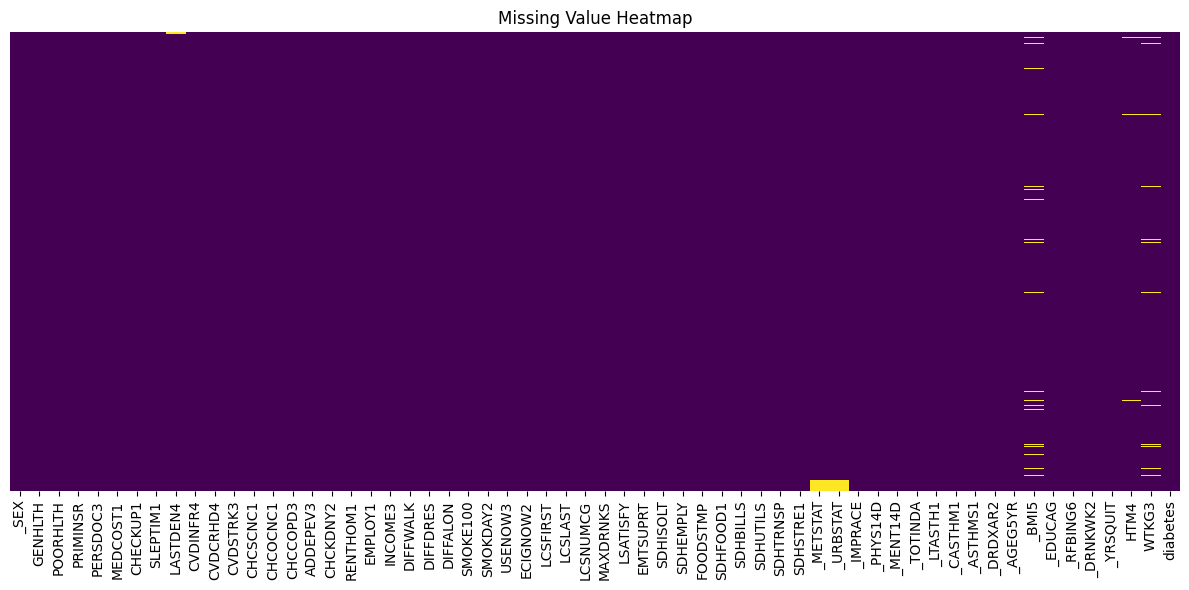

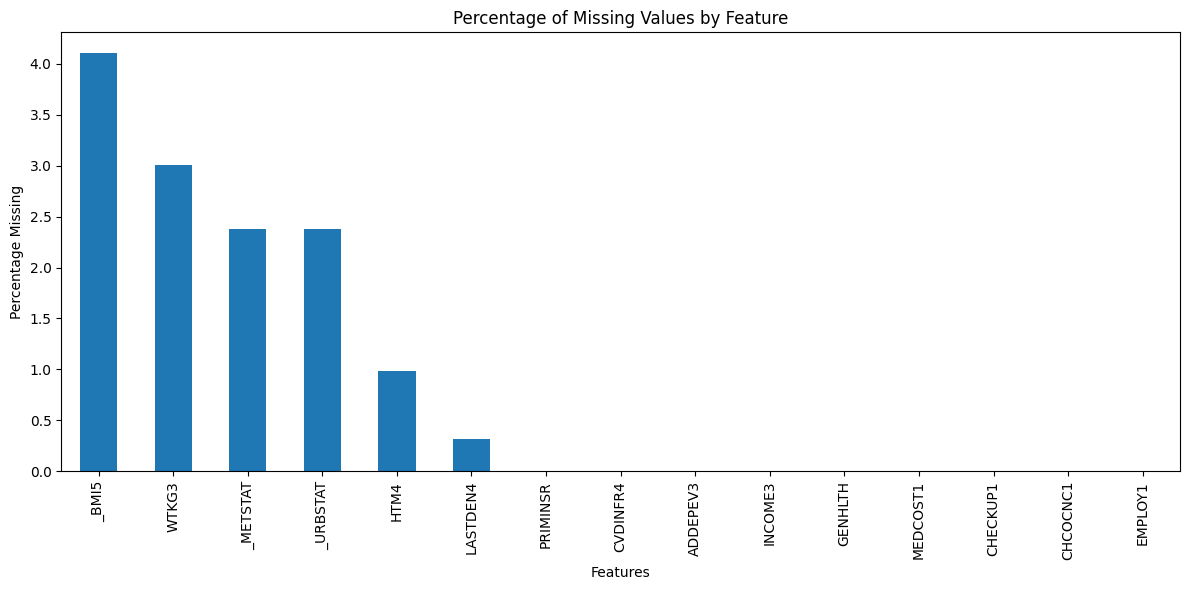

In [22]:
helpers.plot_missing_values(df)

## Final Handling of Missing Values

After our previous cleaning steps, we still have some missing values in the dataset. We've chosen to drop these remaining rows with missing values because:

1. Imputing these values could introduce bias, especially since they're missing across multiple variables.
1. We have a large enough dataset that losing these rows shouldn't significantly impact our analysis (which is confirmed in the distribution plots)

However, it's important to note that this decision could potentially introduce some bias if the missing data is not completely random. In a more comprehensive analysis, we might consider using more advanced imputation techniques or analyzing the patterns of missingness.

In [23]:
df=df.dropna()
df.shape

(230693, 60)

### A correlation matrix before we correct the types; this will help identify features of interest, coincident and colinear values, etc

coincident and colinear variables have had their duplicates removed above until this looks relatively clear. This correlation matrix is not for feature selection; this is for eliminating redundancy.

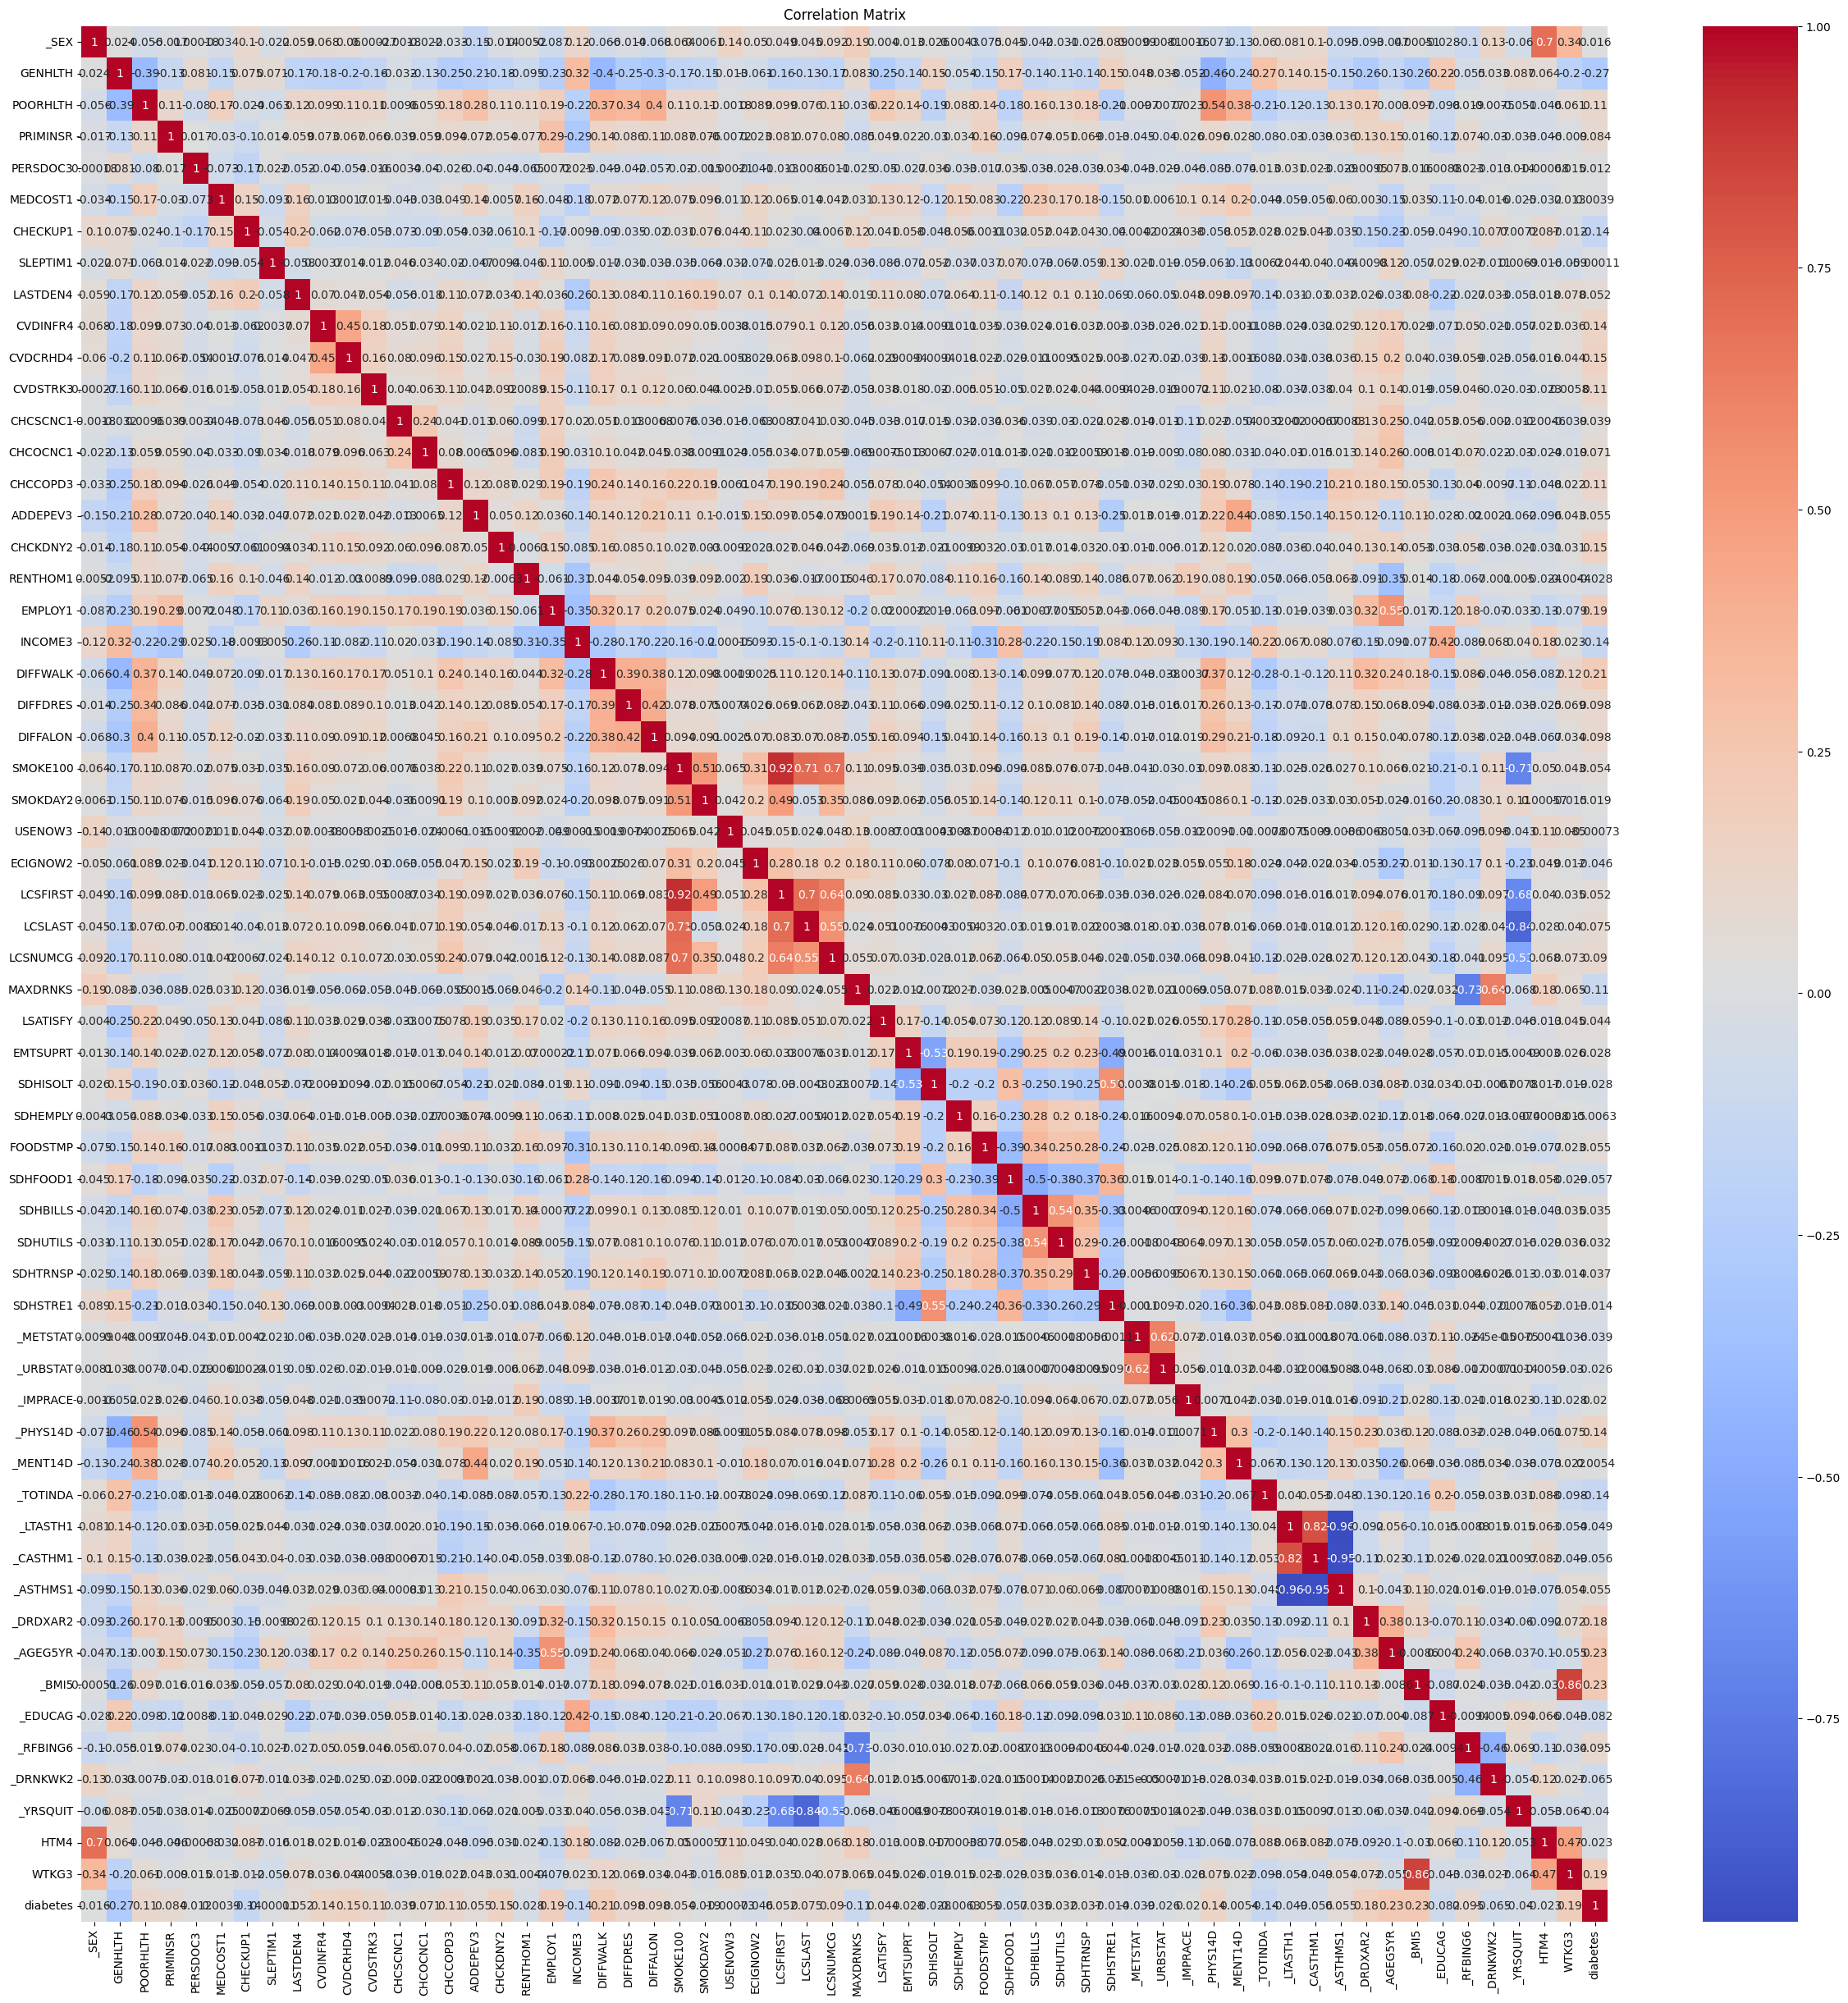

In [24]:
correlation_matrix = df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Distribution Examination

We've plotted the distributions of our variables before and after cleaning to ensure that our cleaning process hasn't significantly altered the underlying data patterns. The key observation is that the distributions over the relevant portion of values remains largely unchanged for all retained variables. 

These comparisons give us confidence that our cleaning process has retained the important characteristics of our data while removing problematic elements.

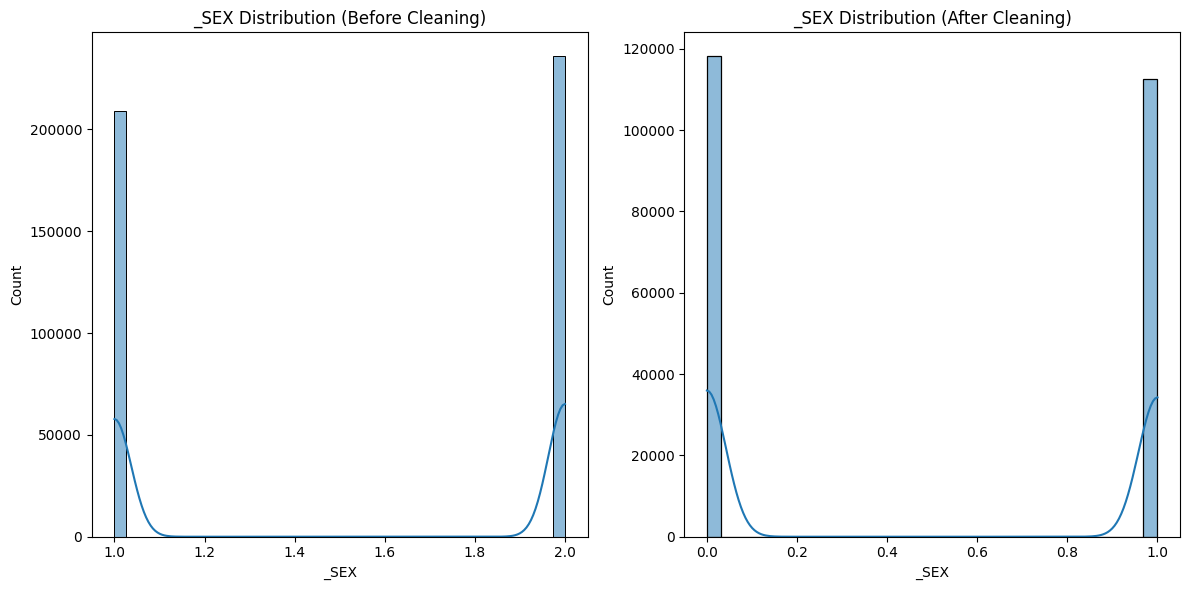

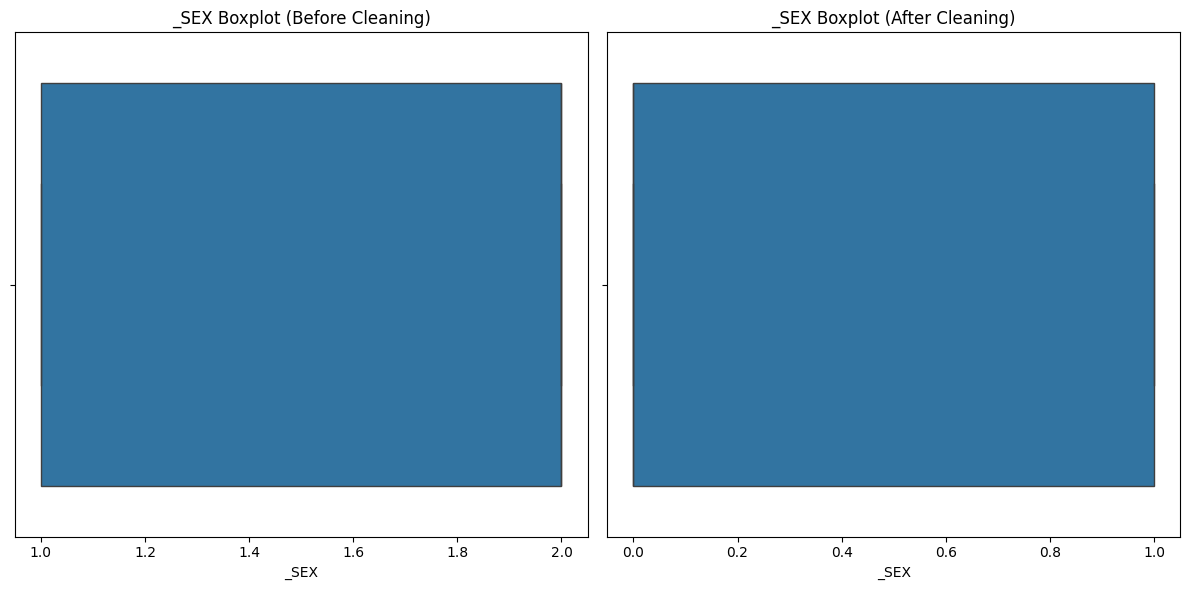

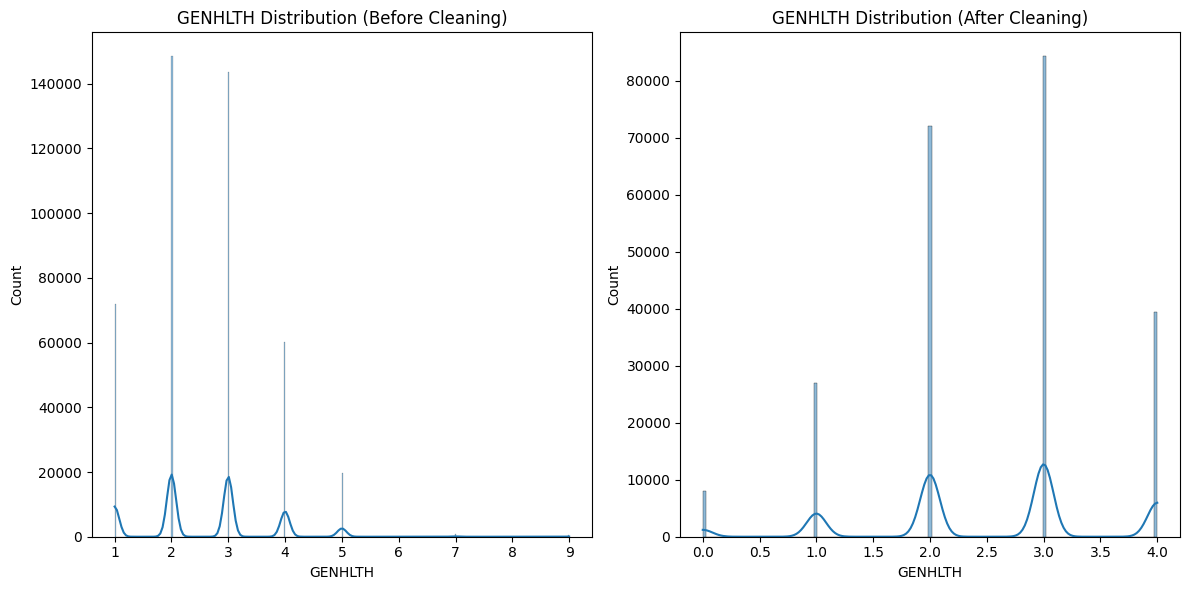

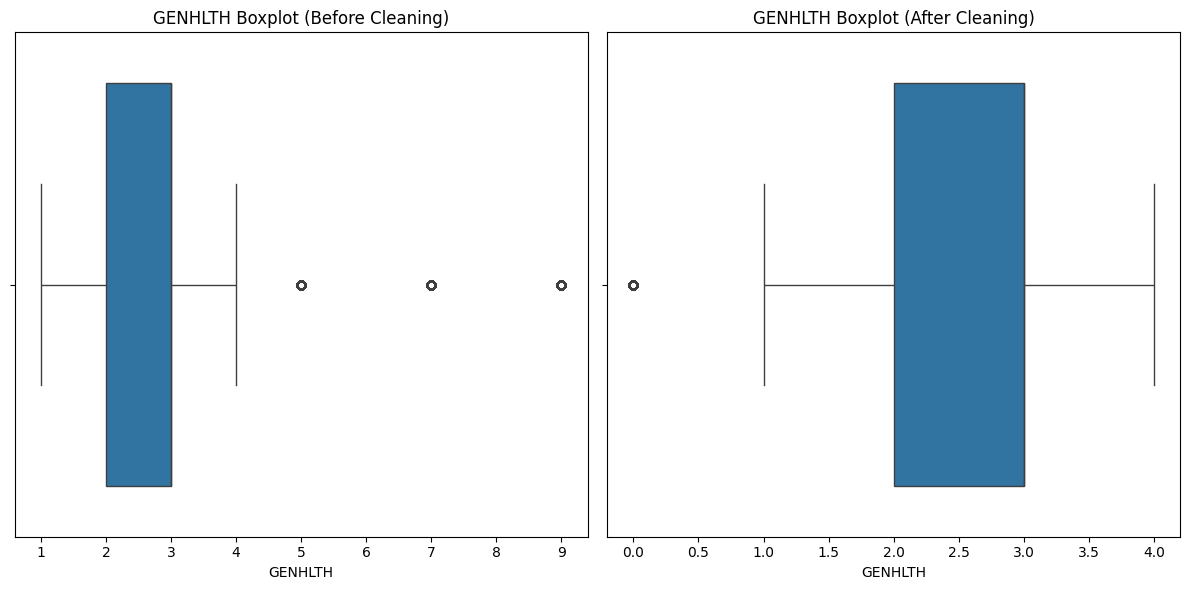

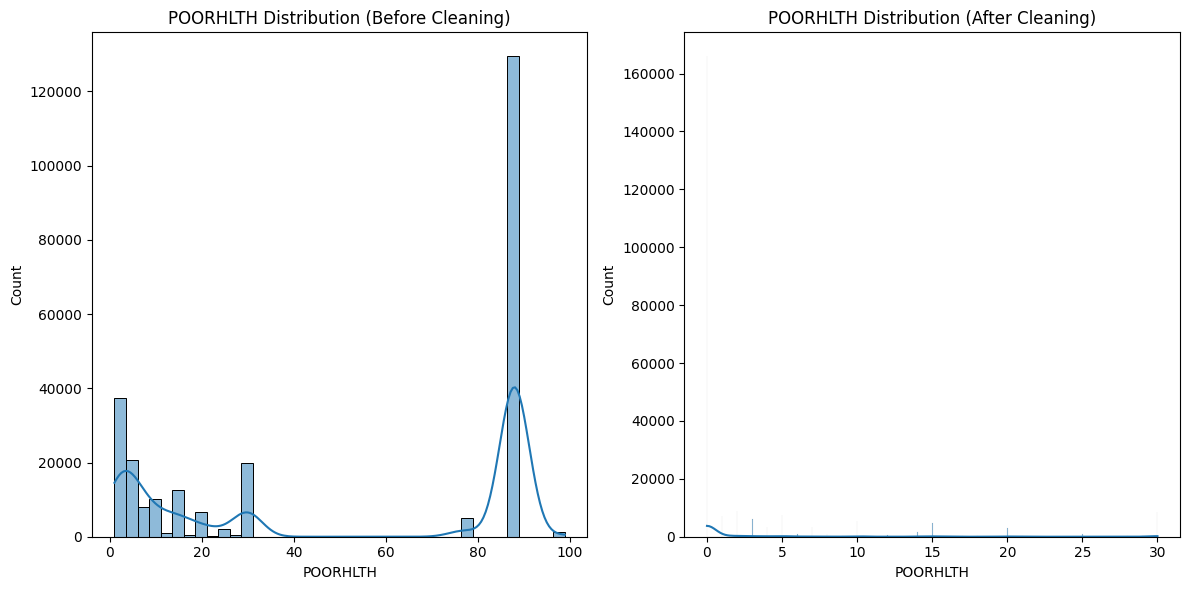

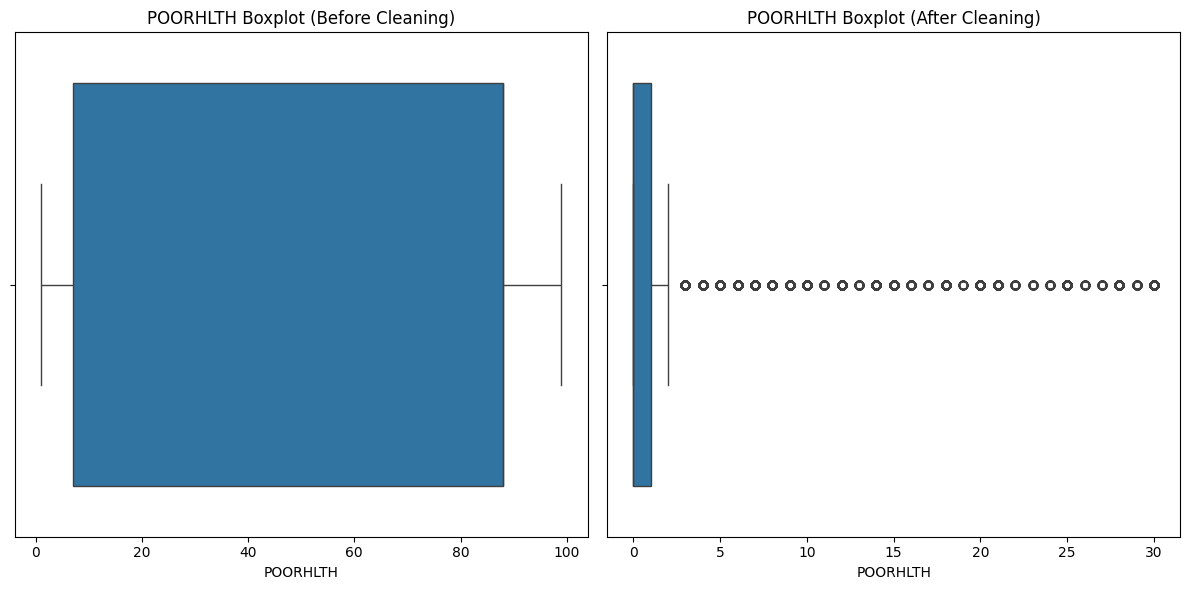

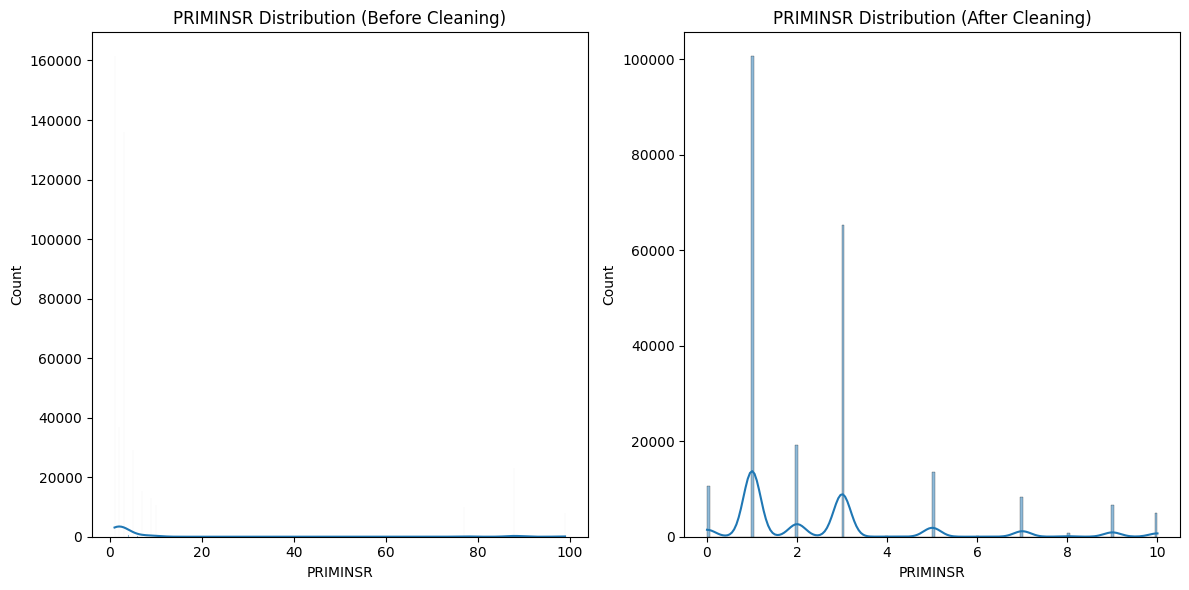

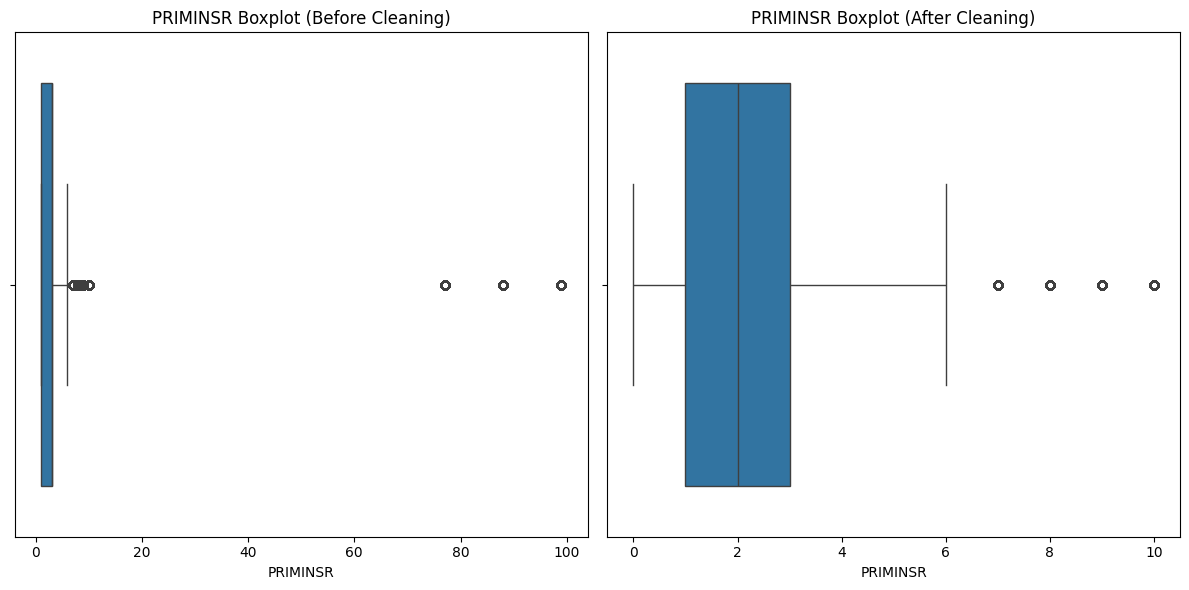

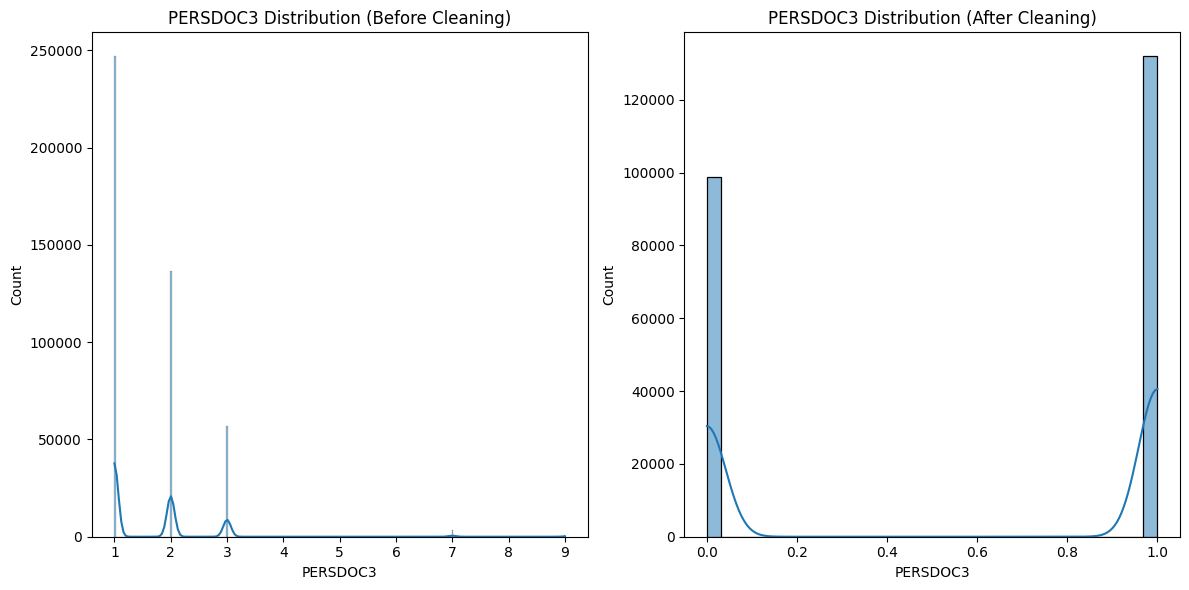

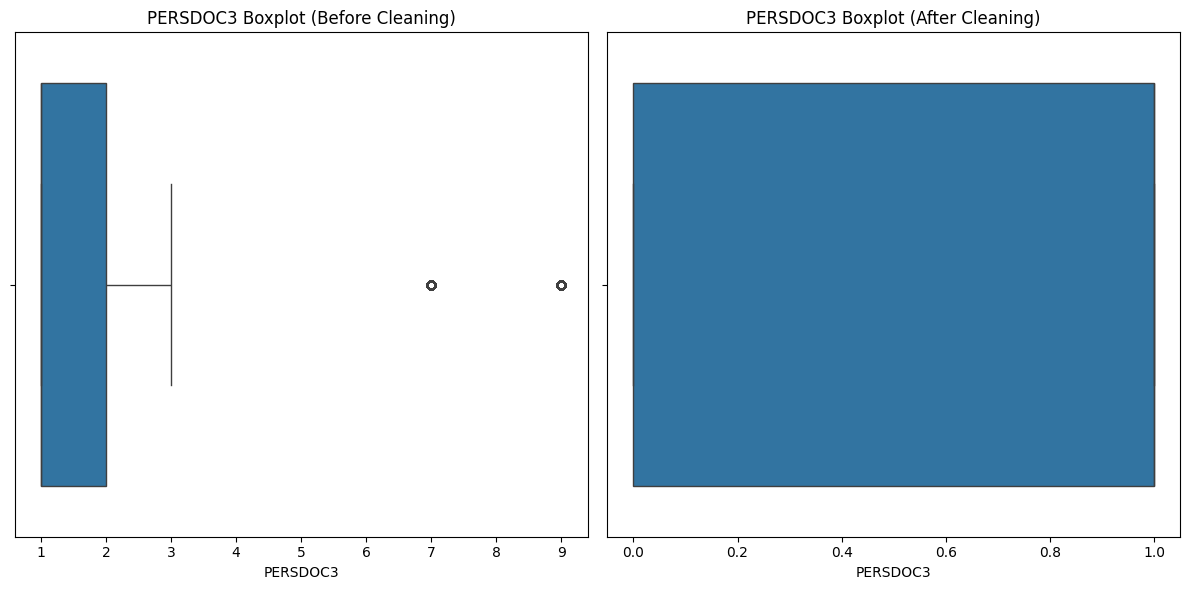

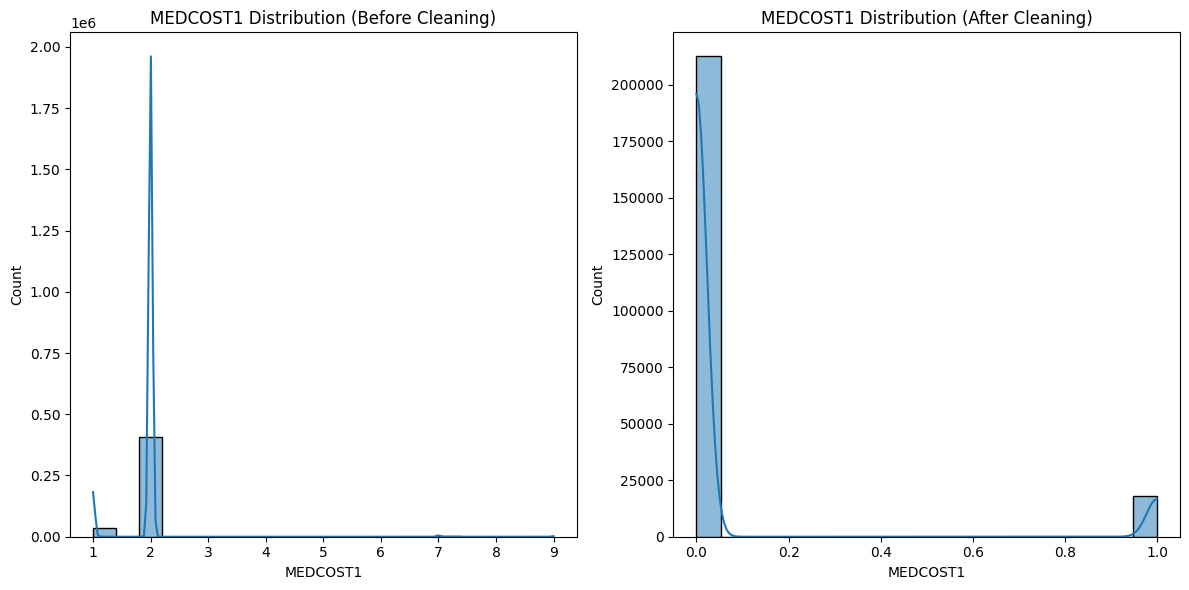

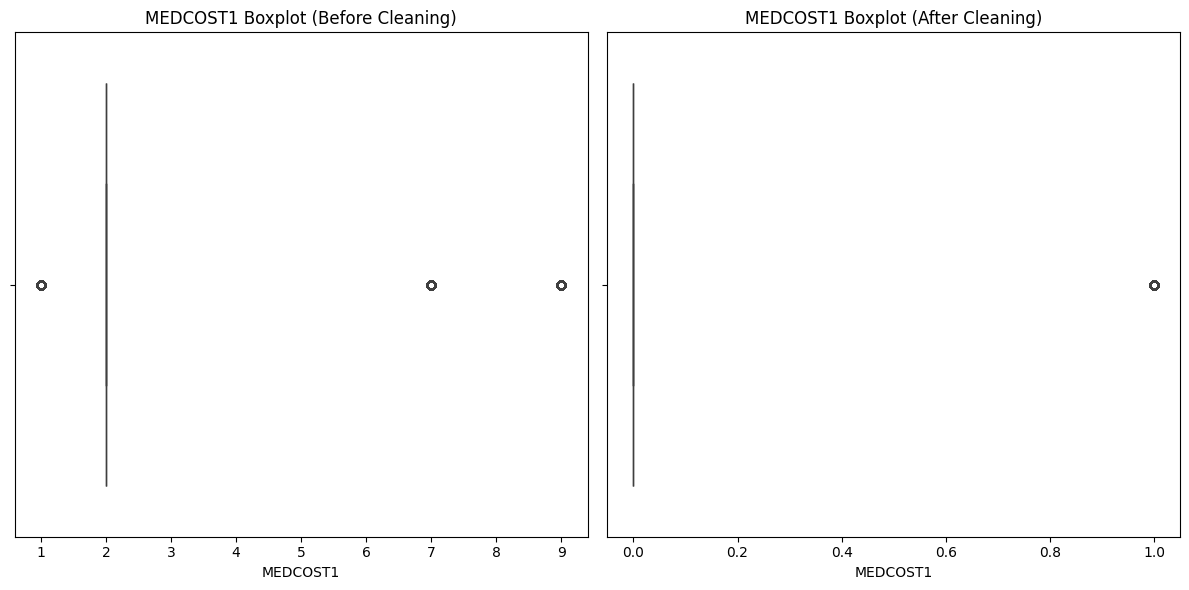

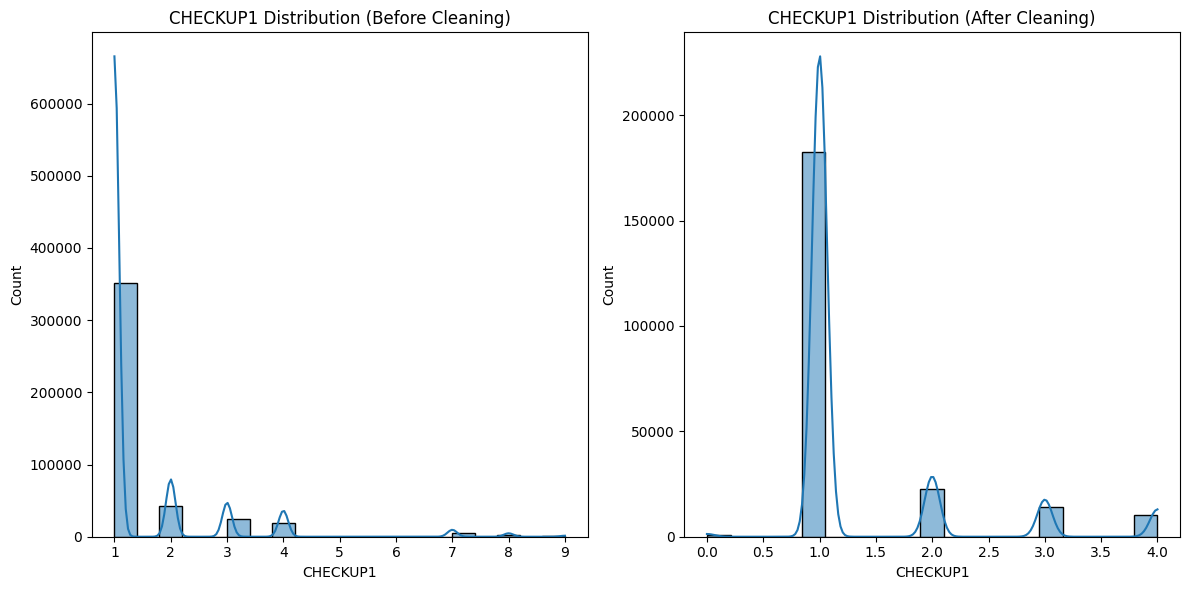

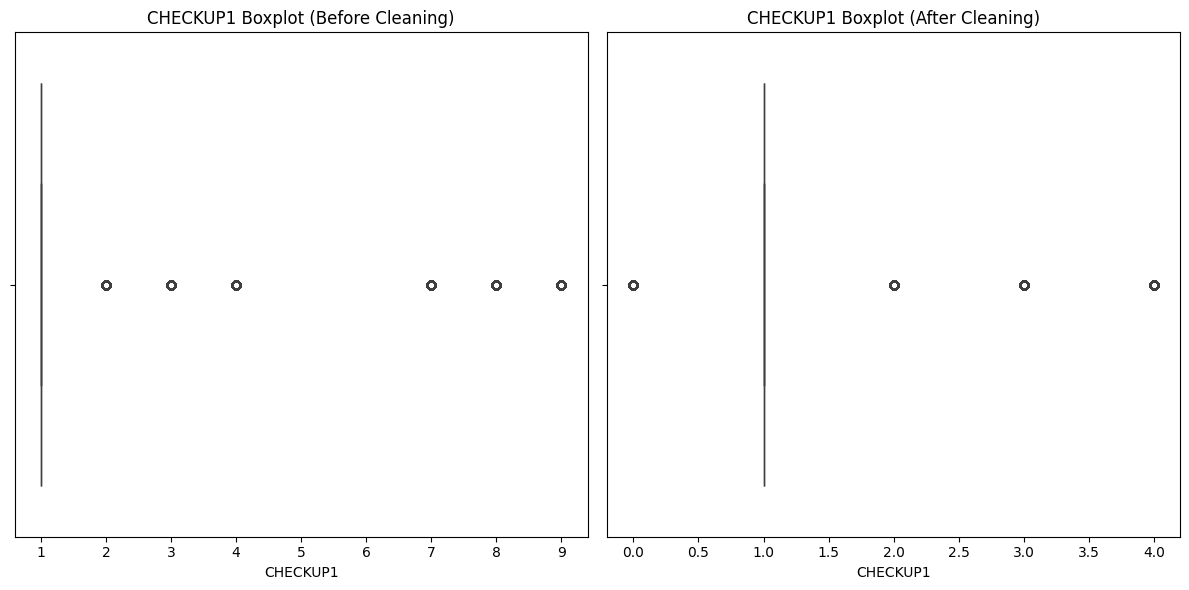

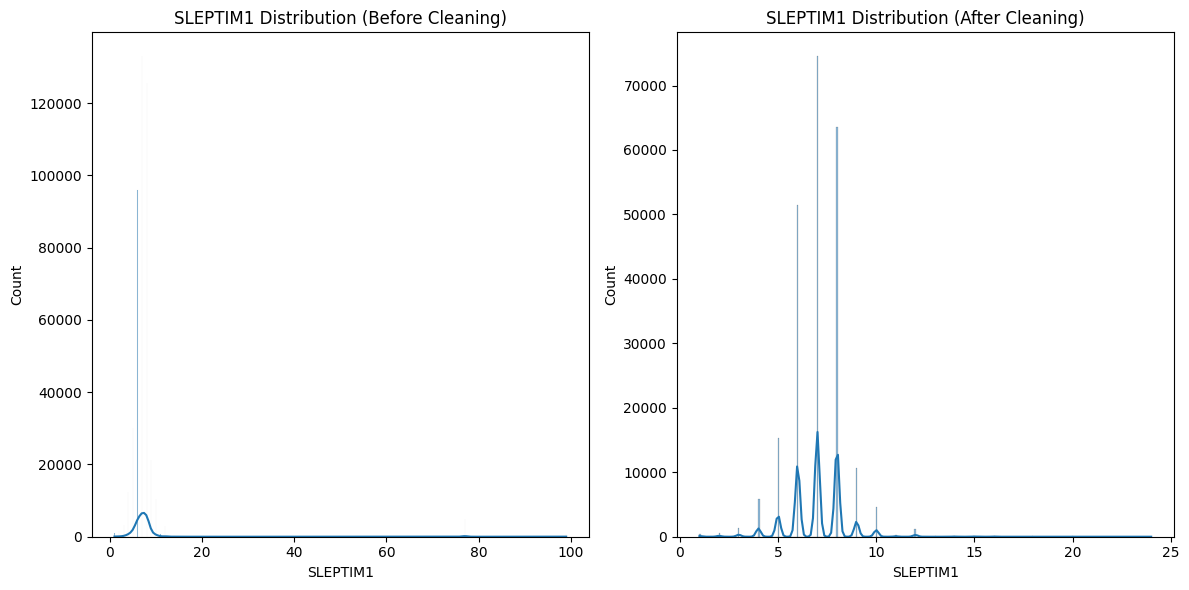

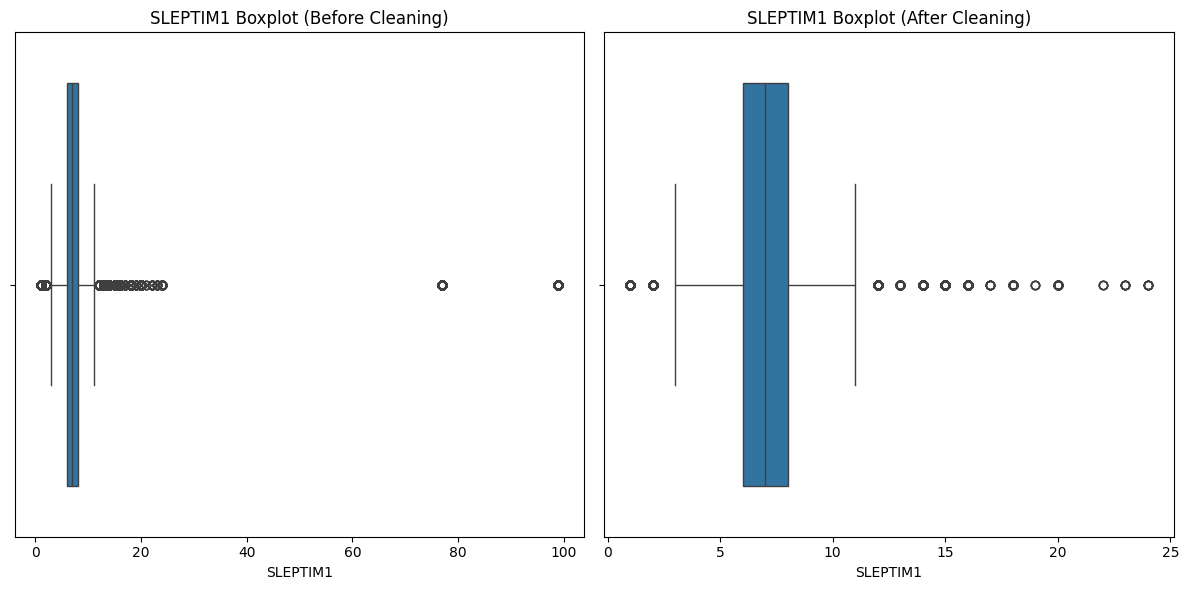

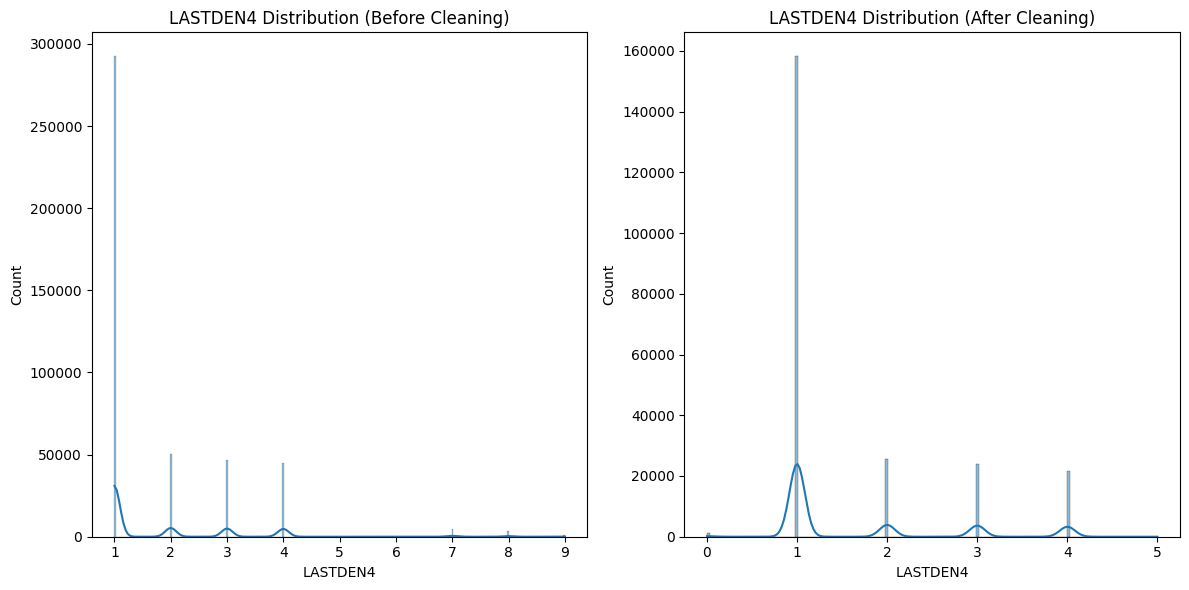

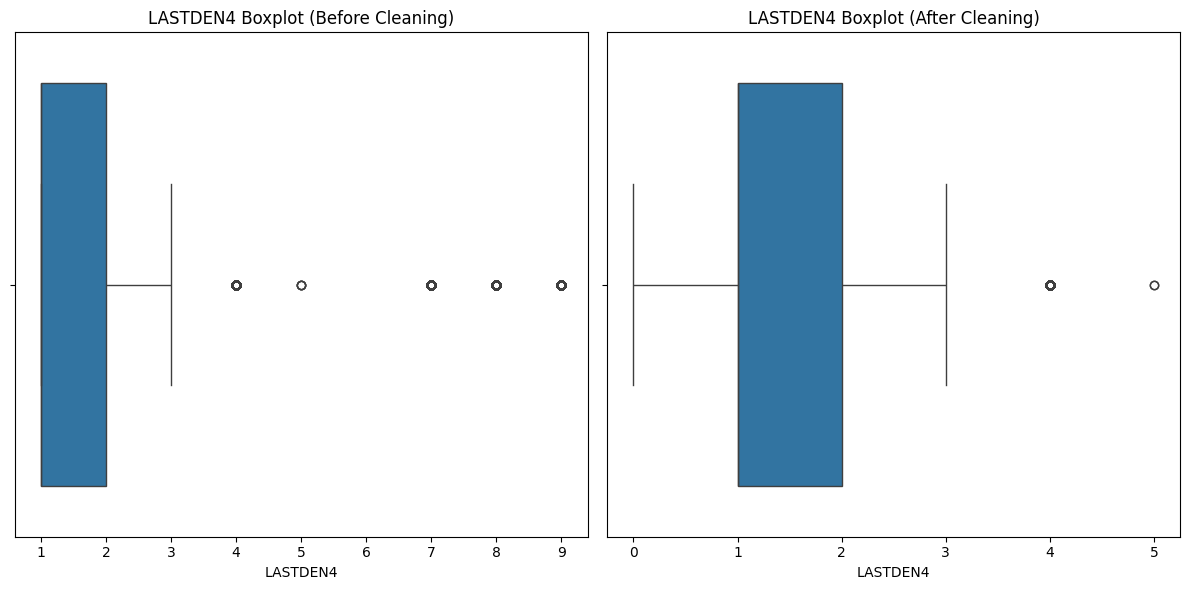

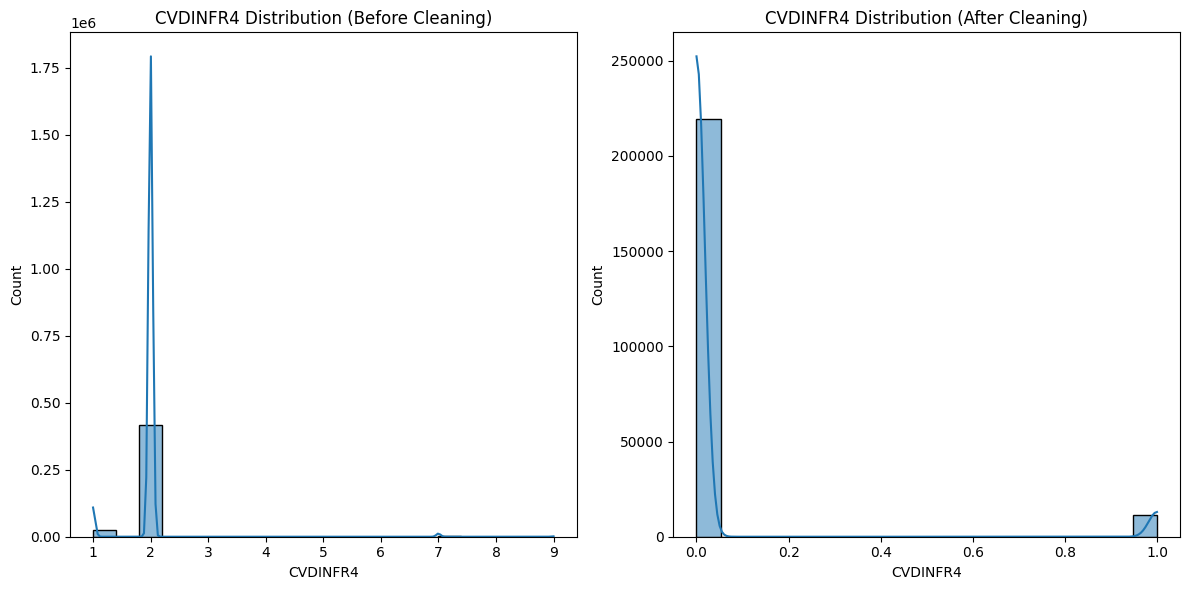

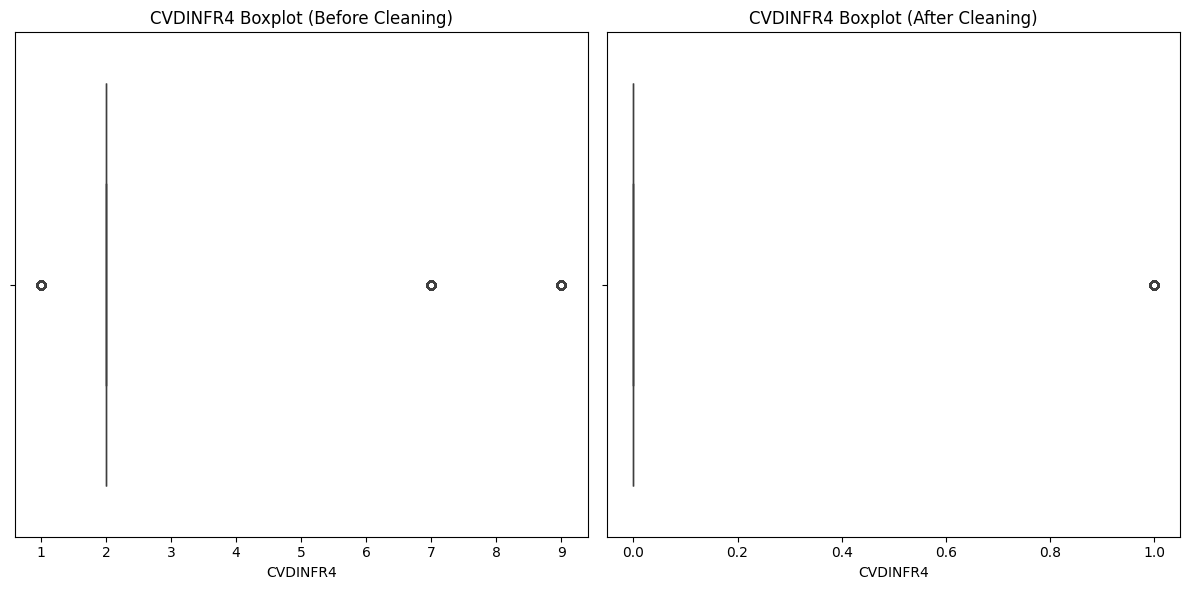

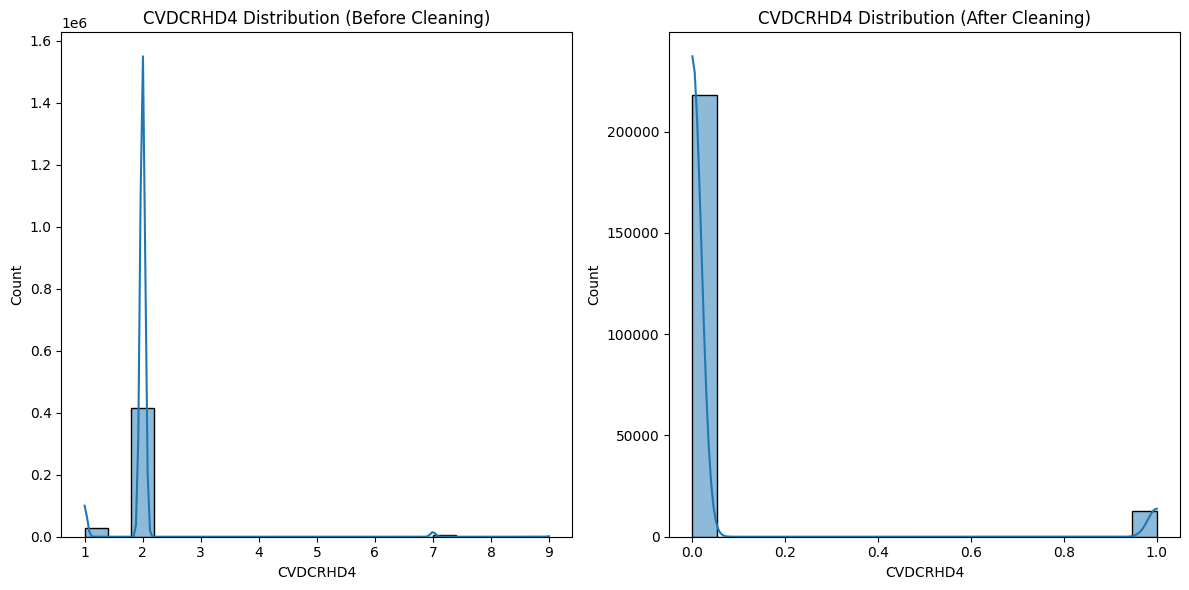

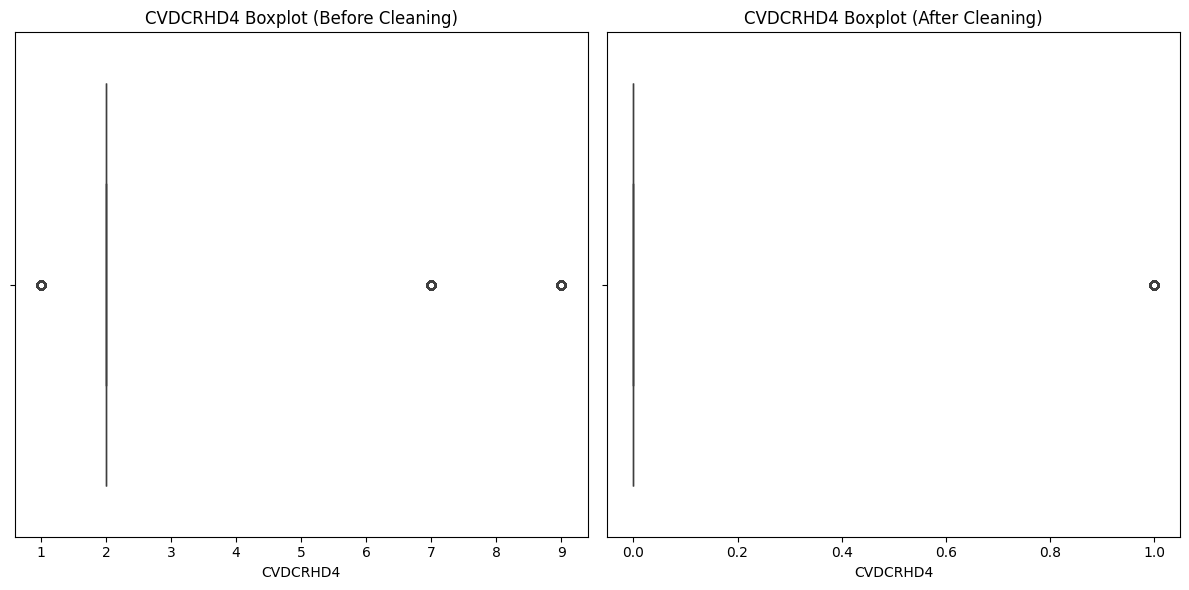

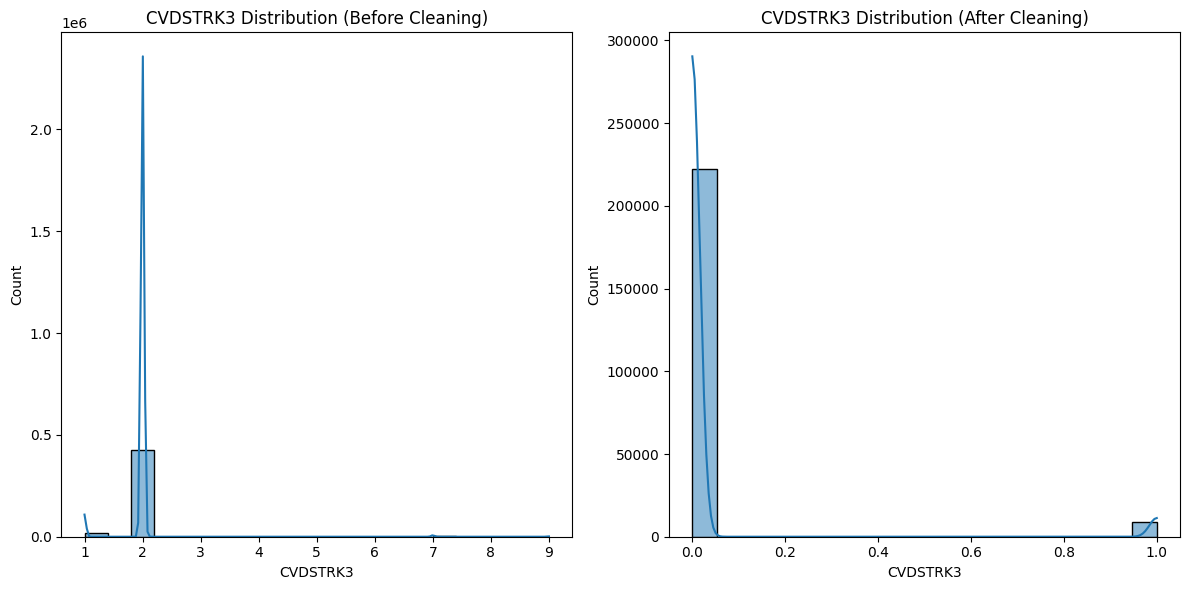

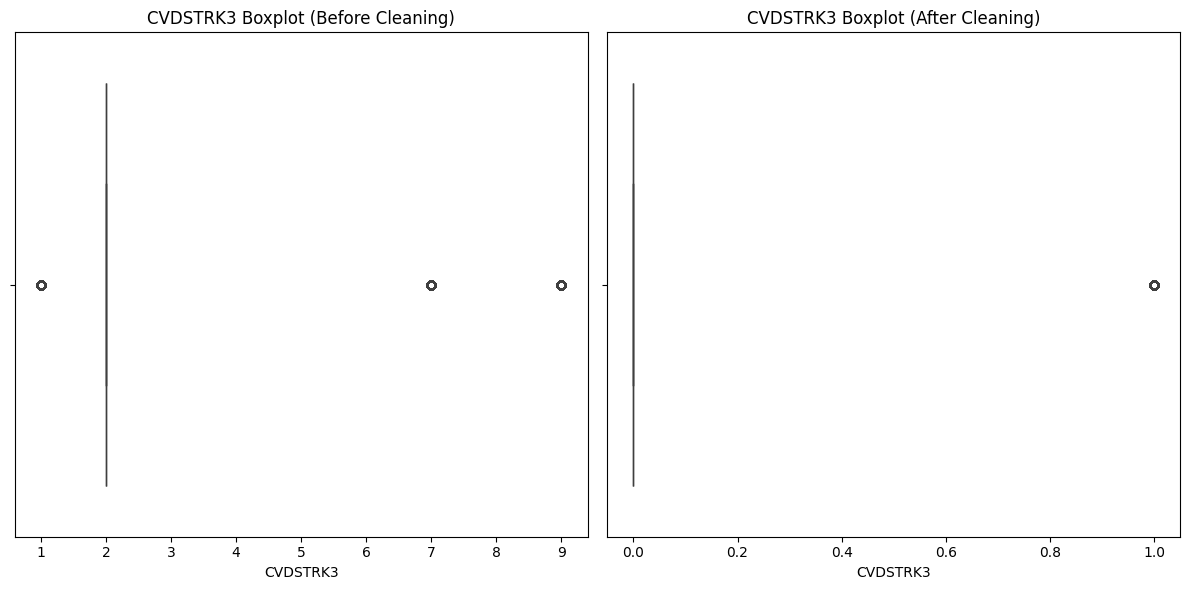

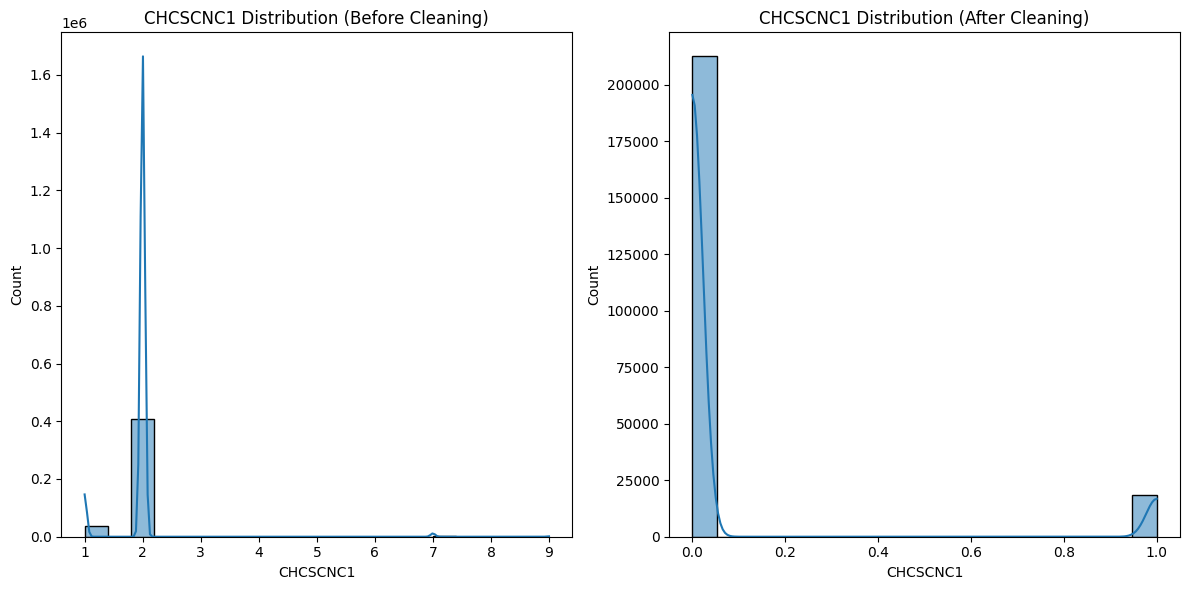

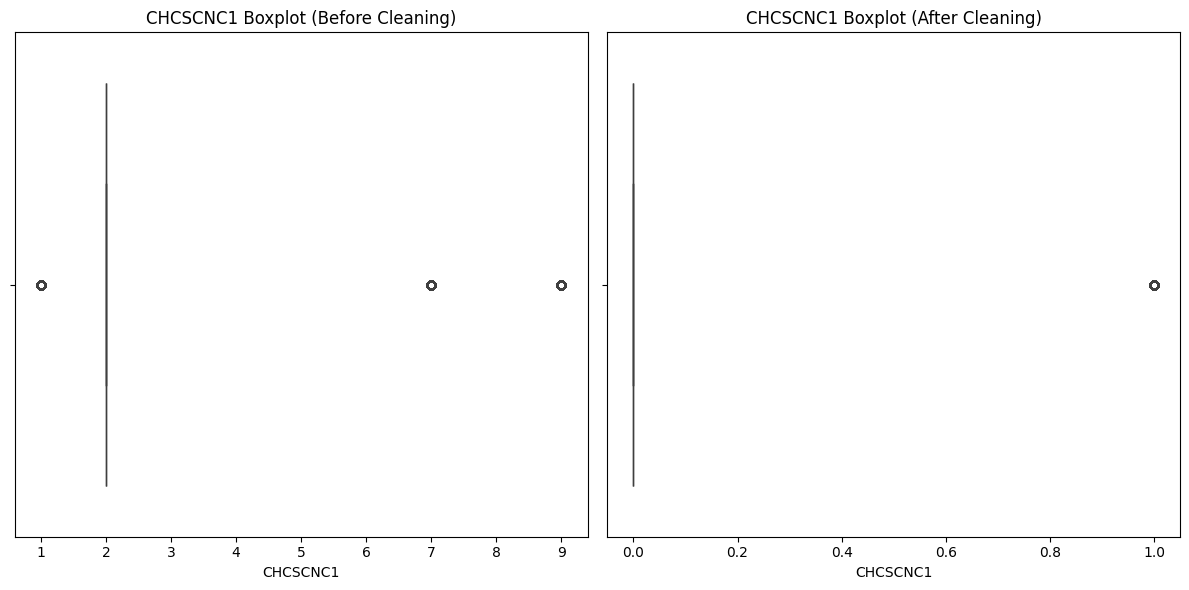

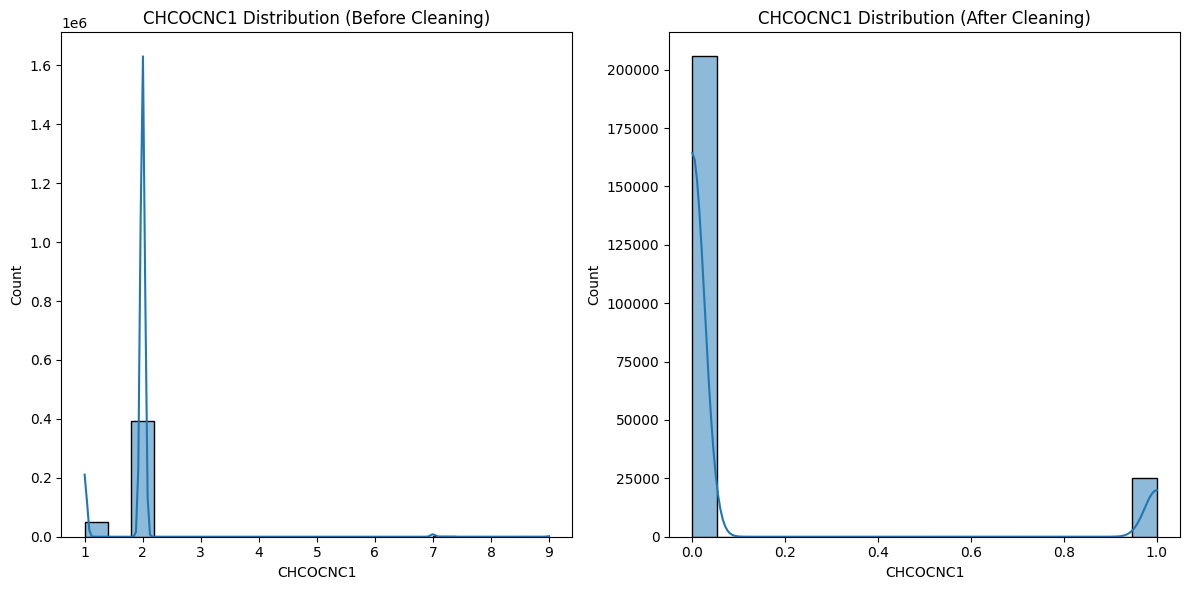

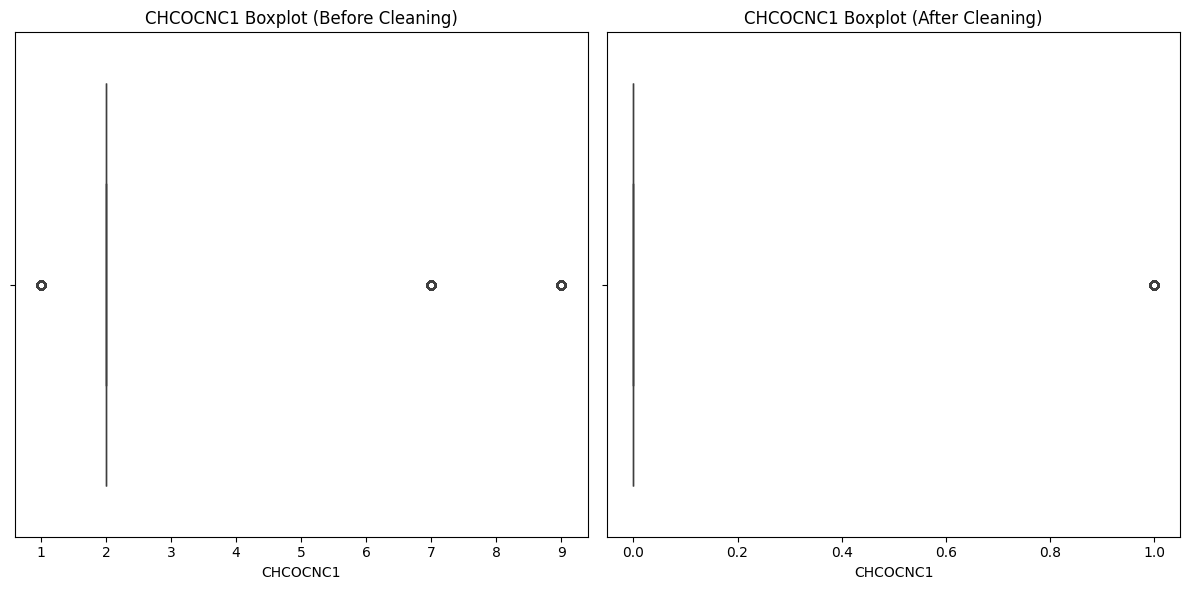

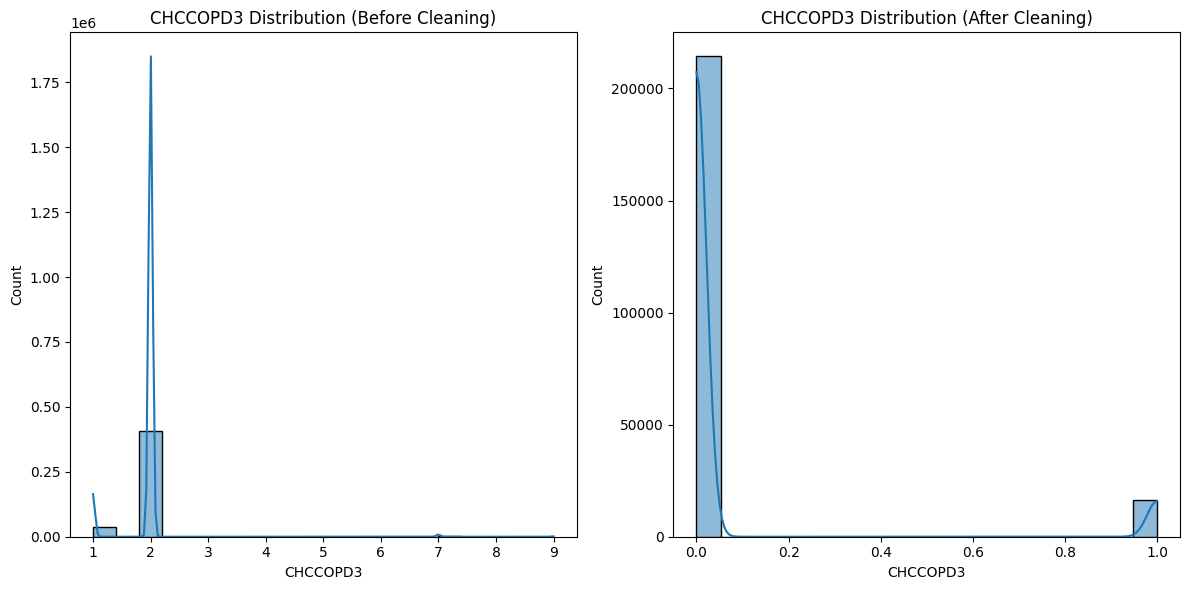

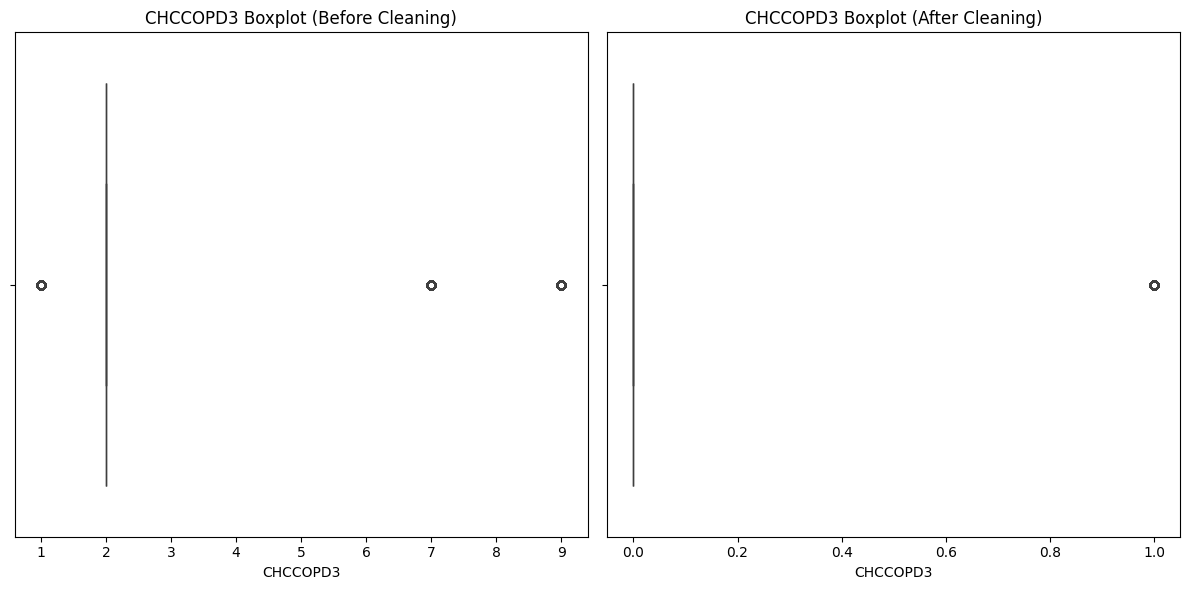

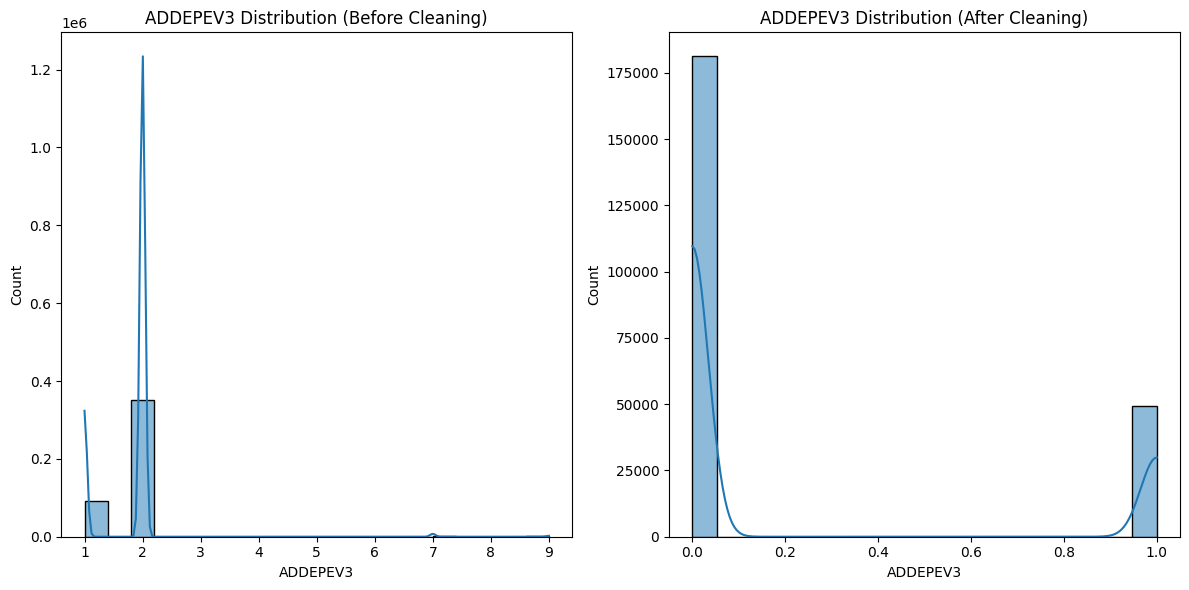

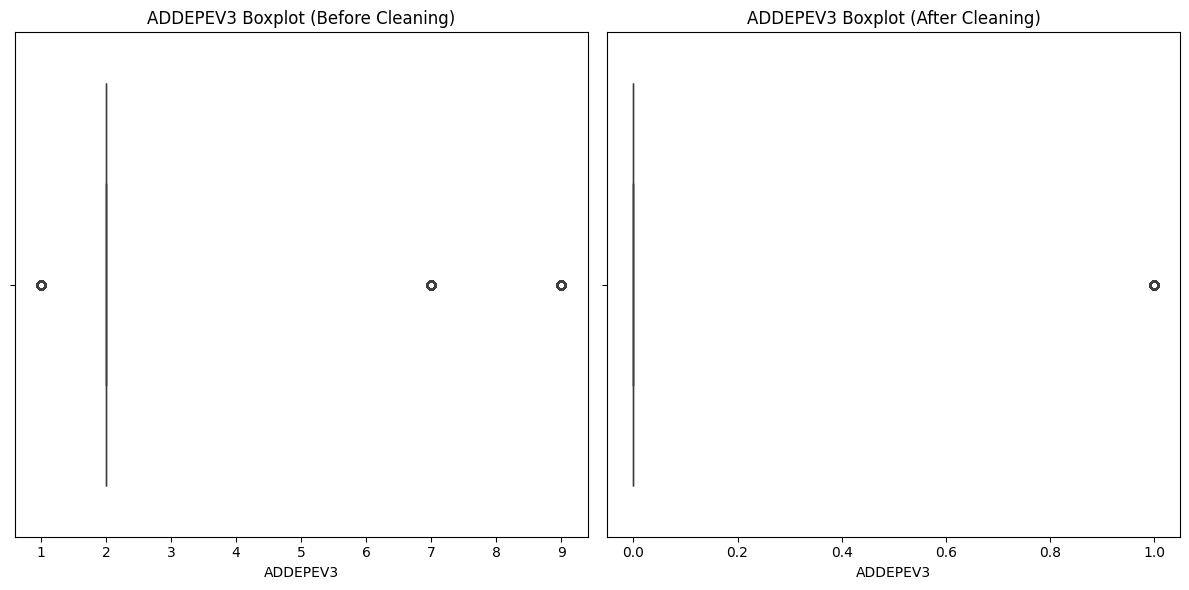

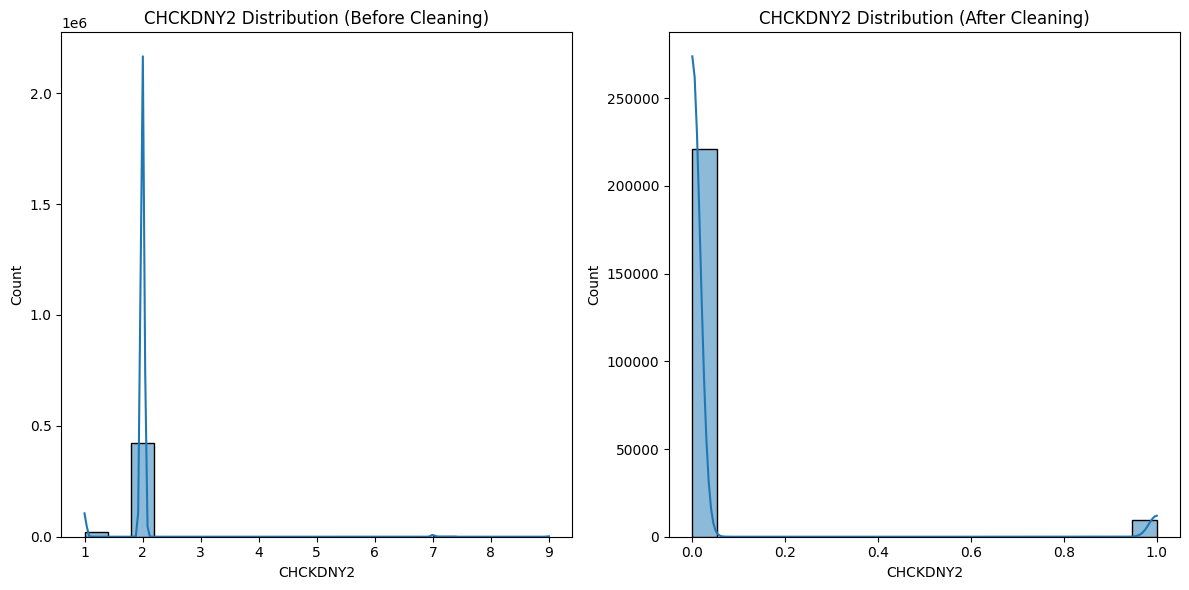

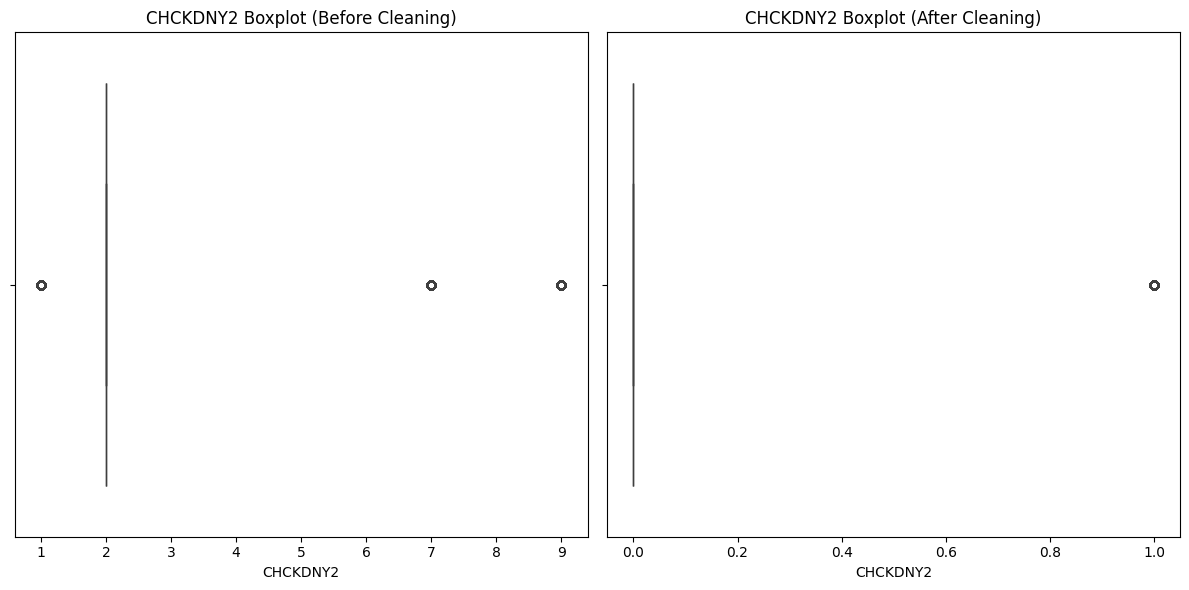

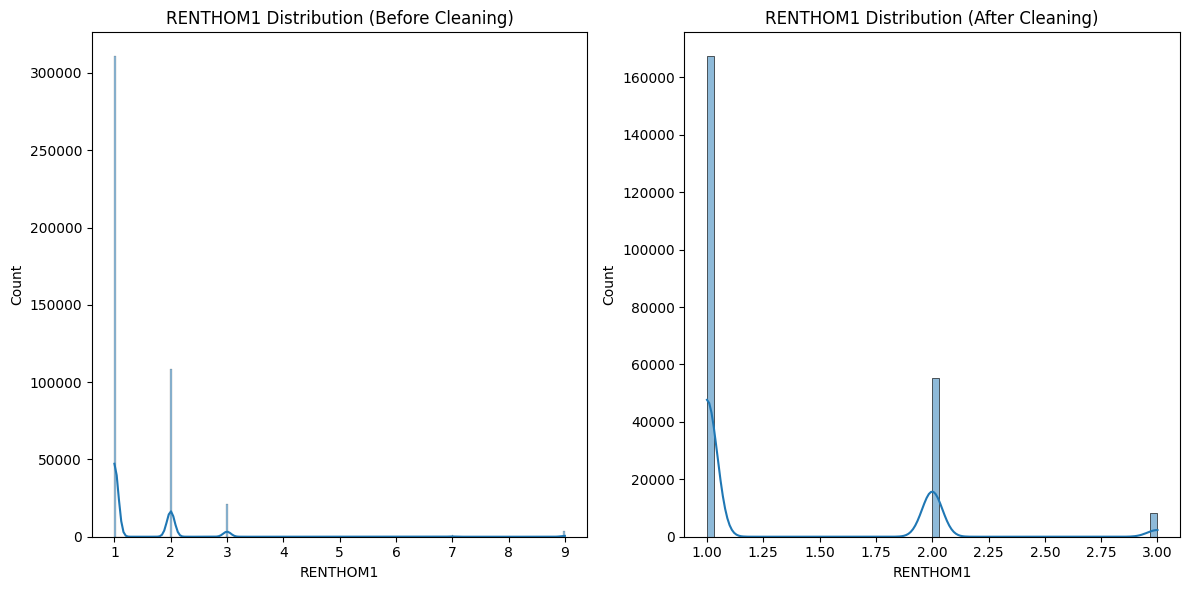

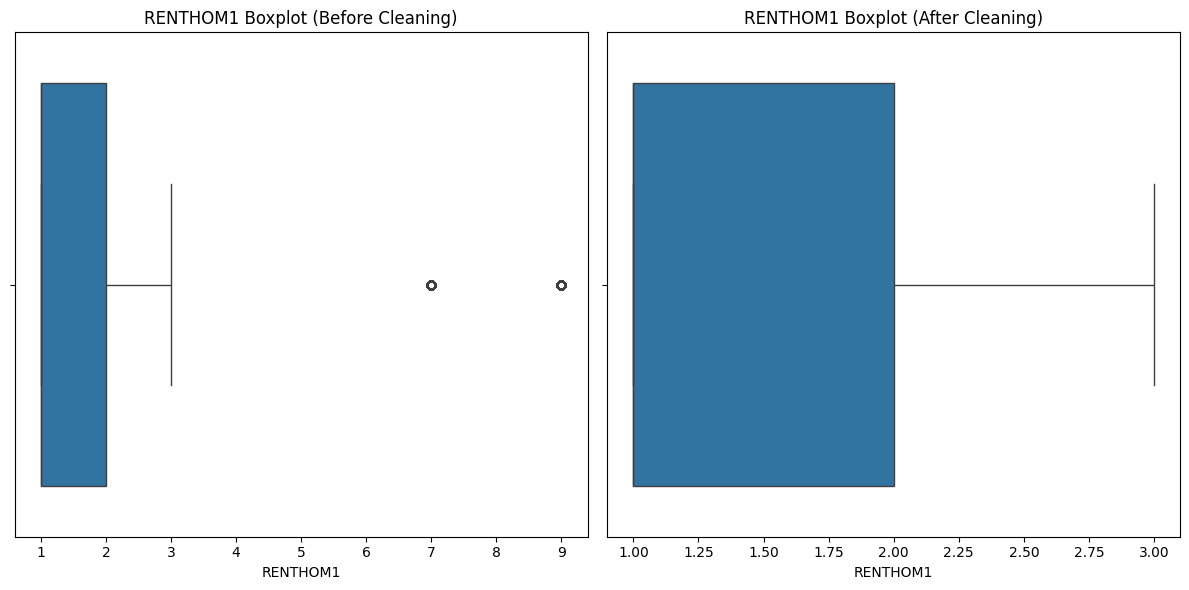

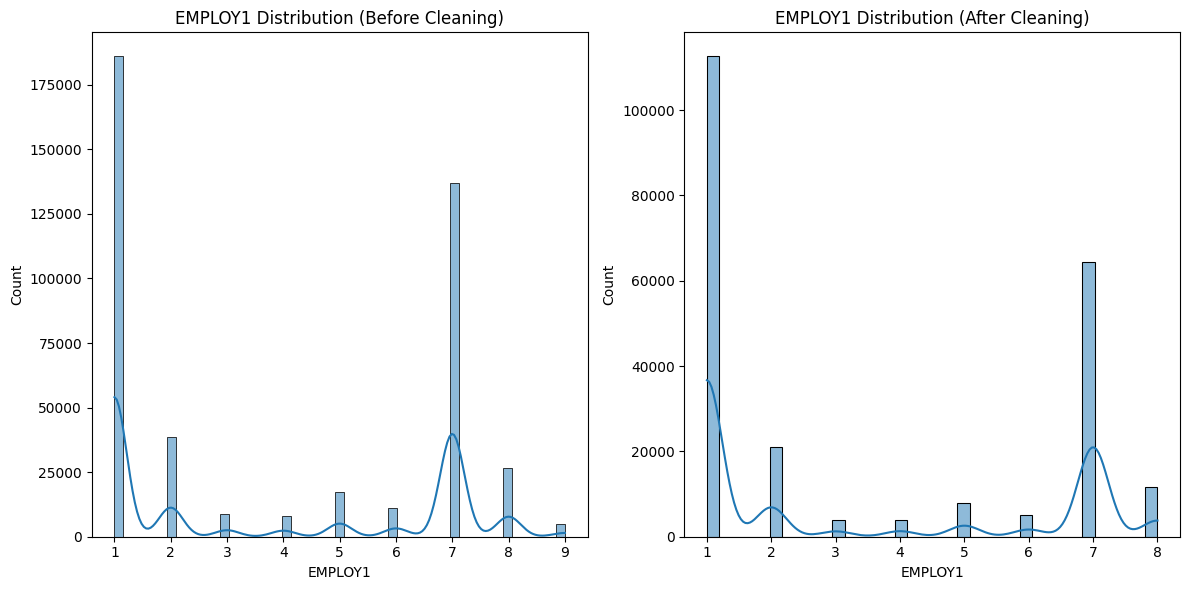

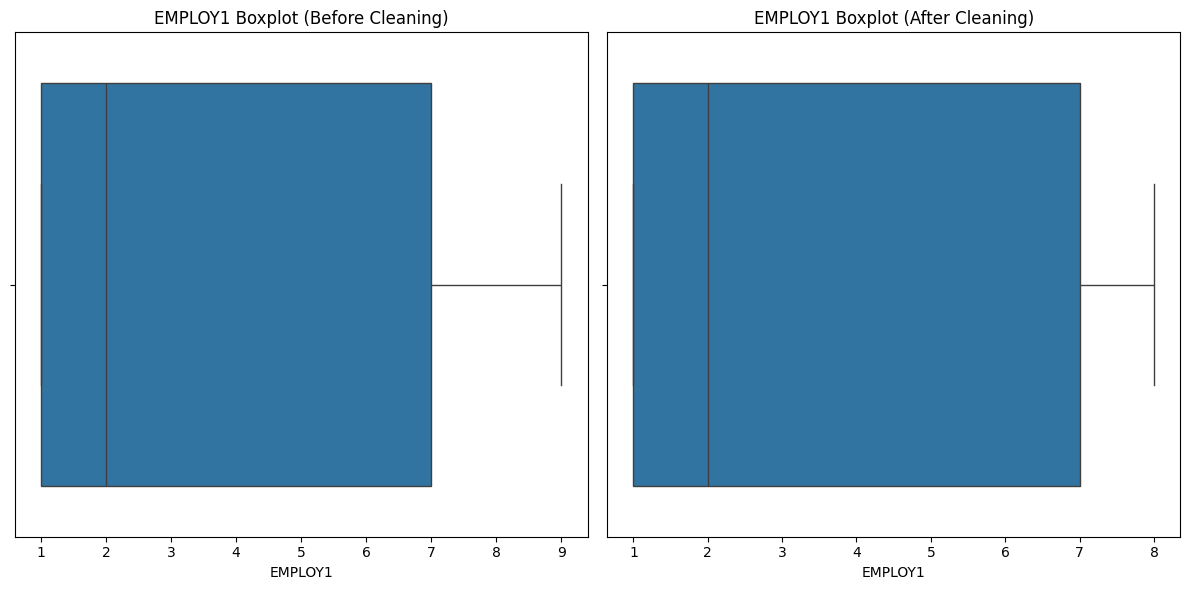

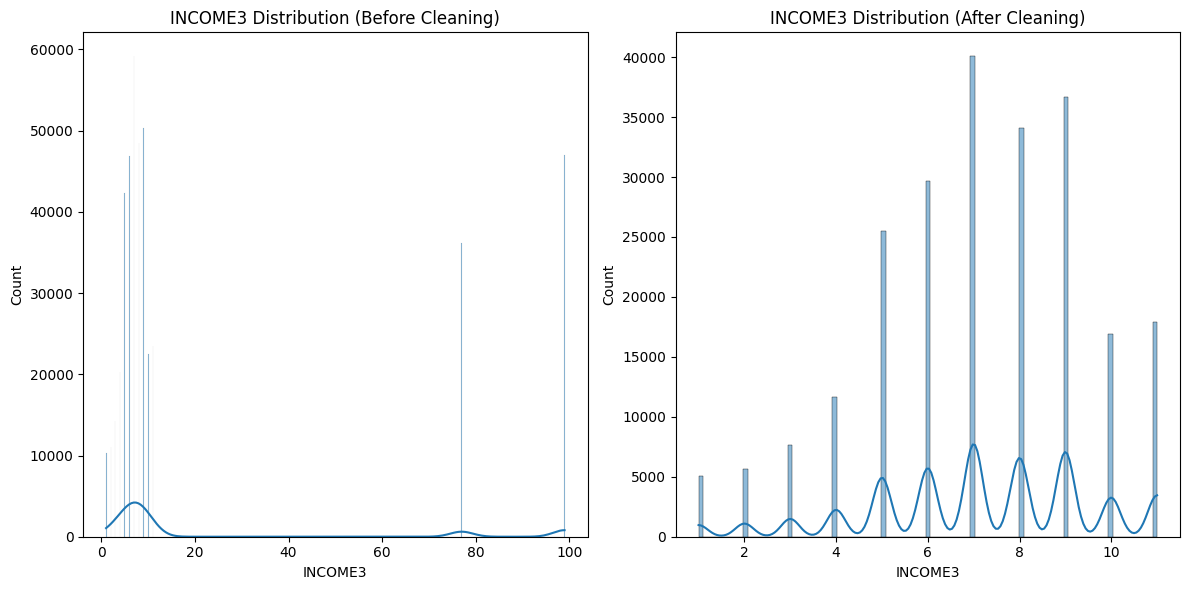

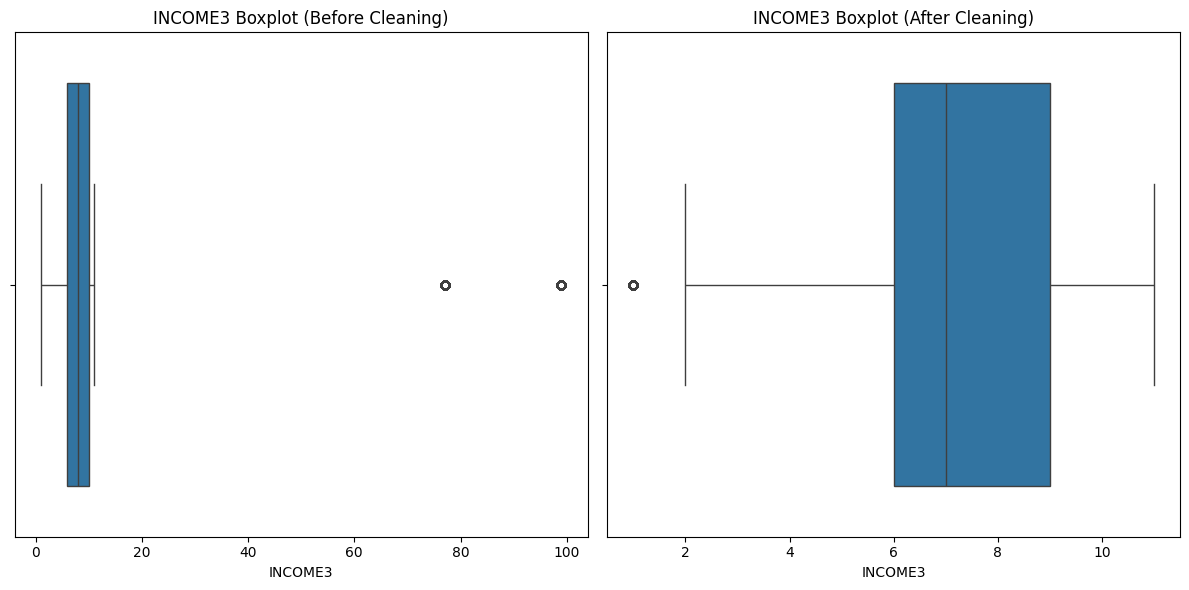

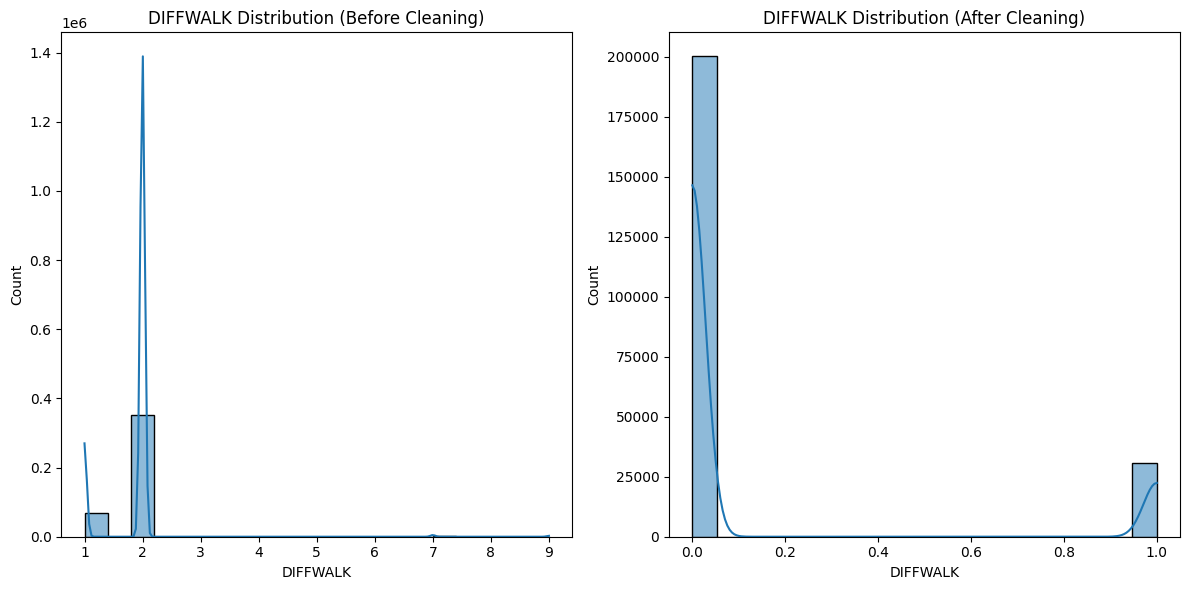

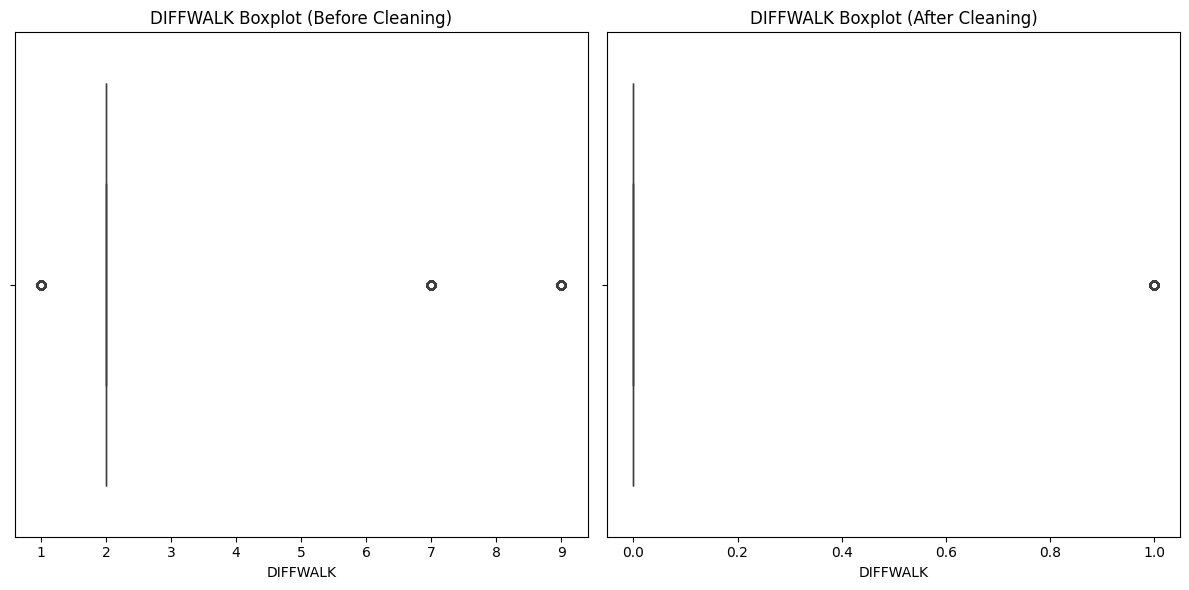

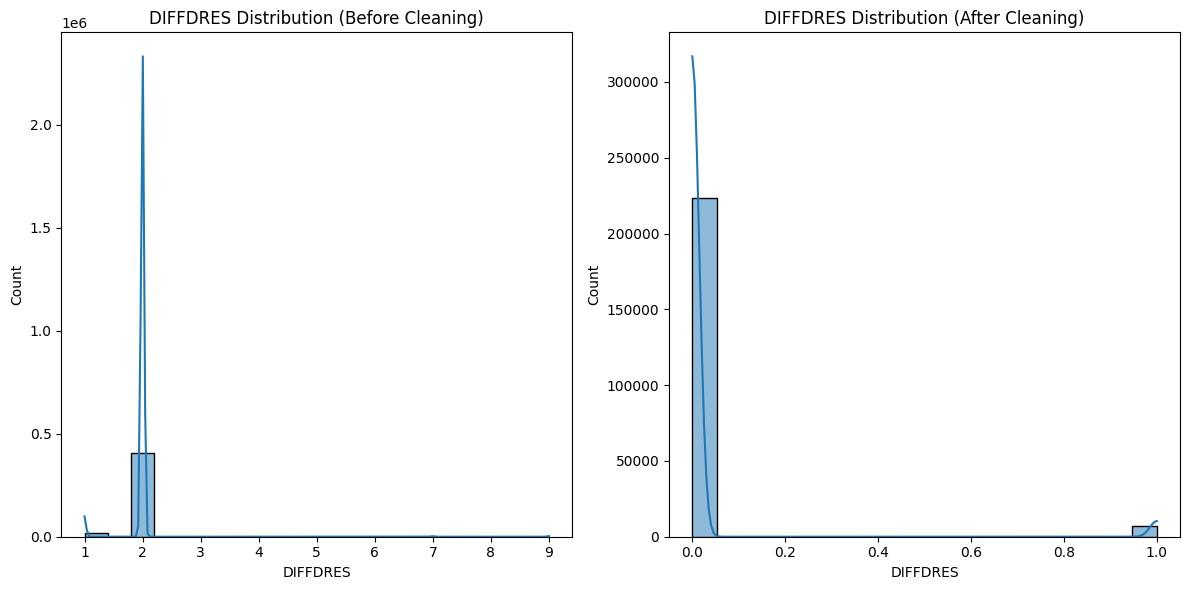

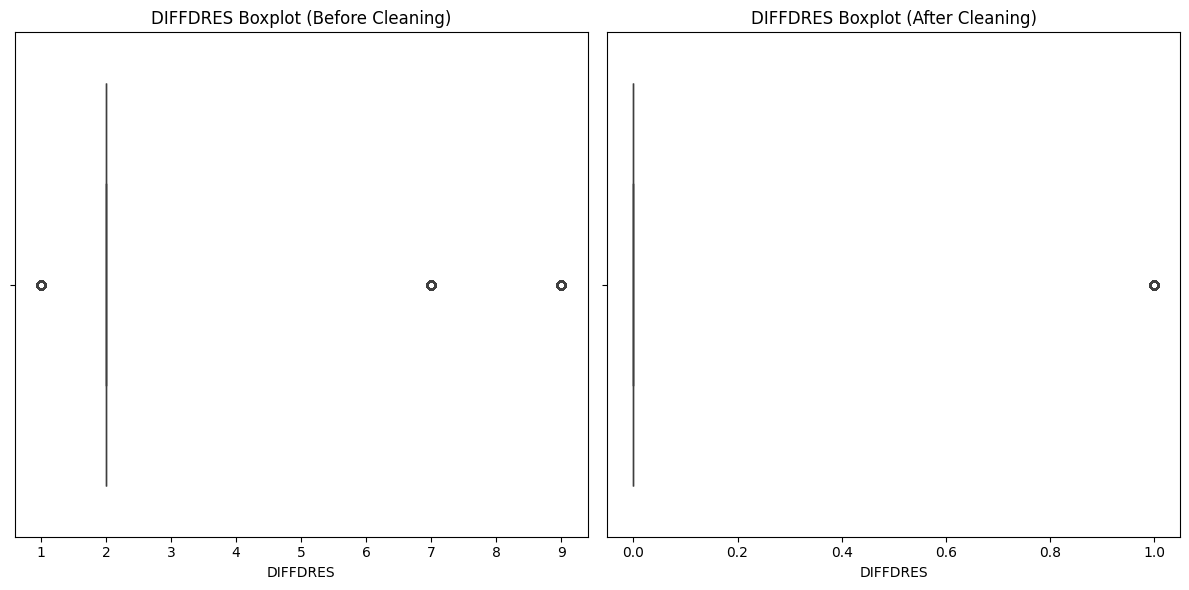

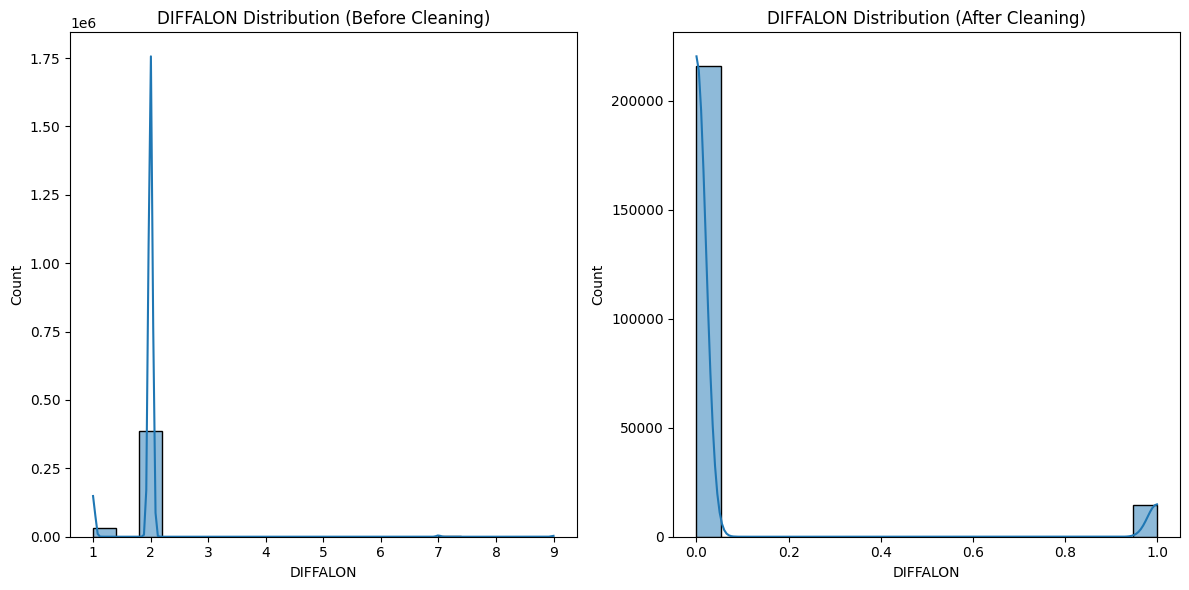

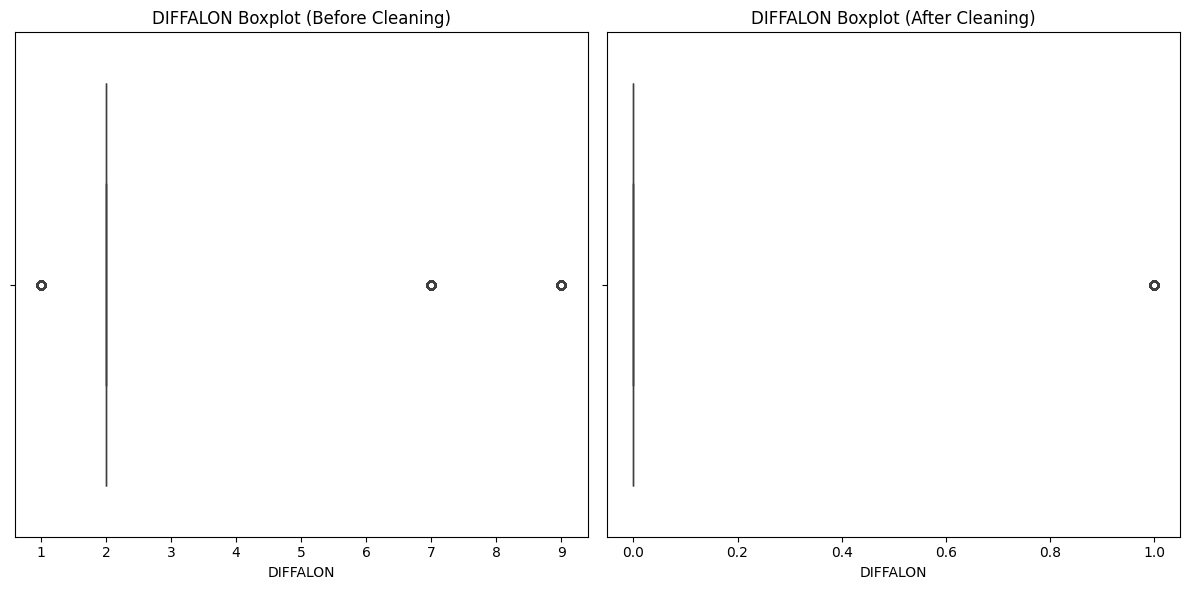

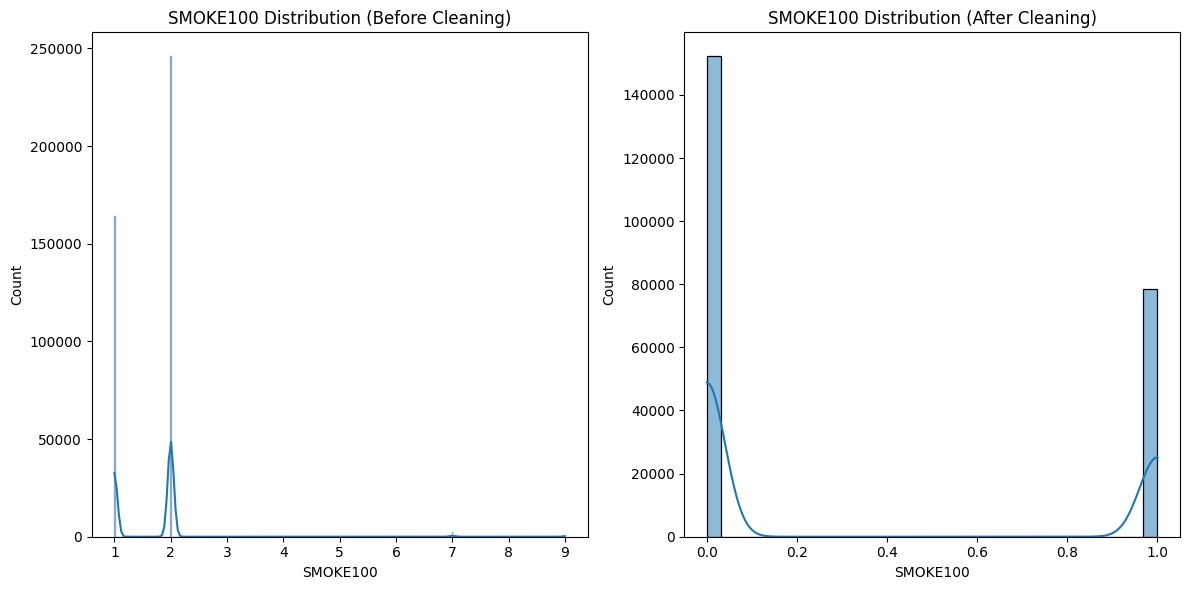

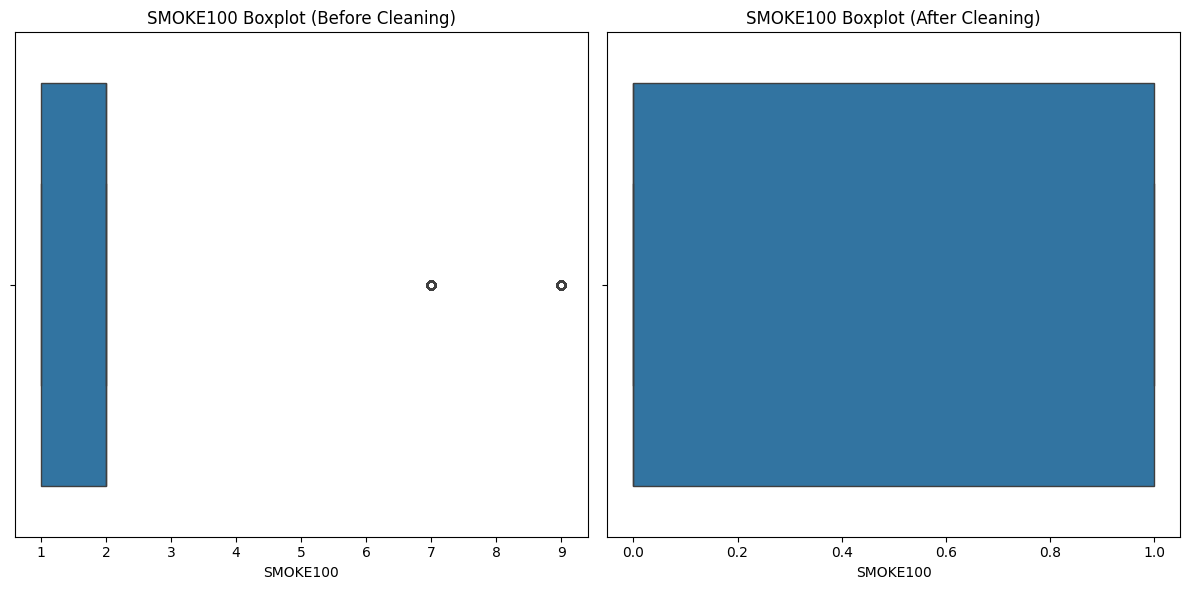

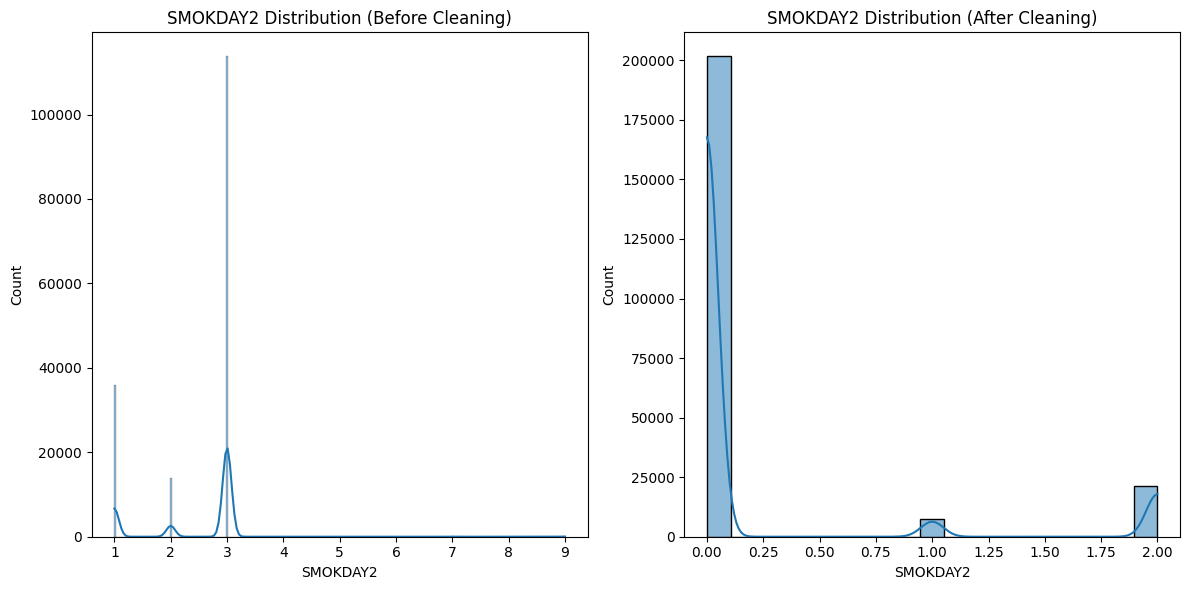

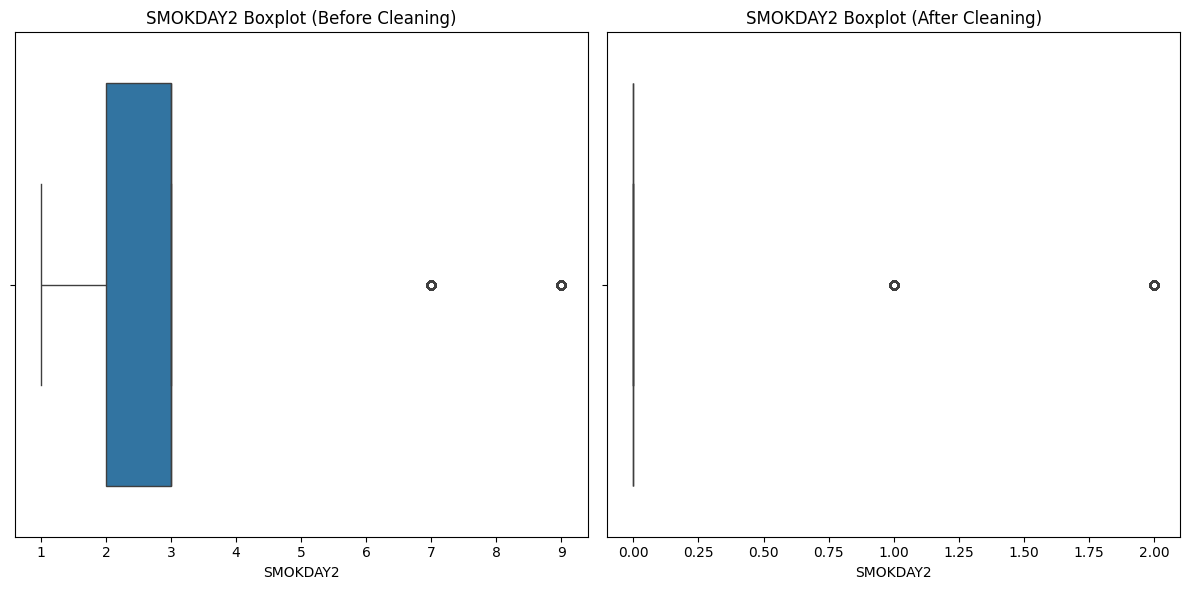

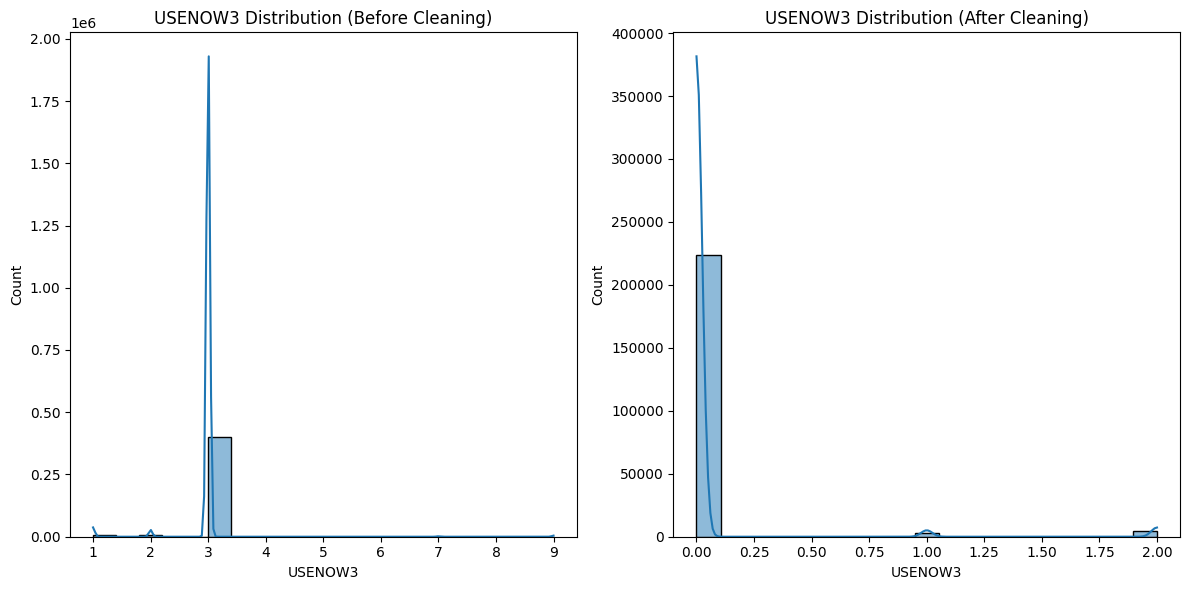

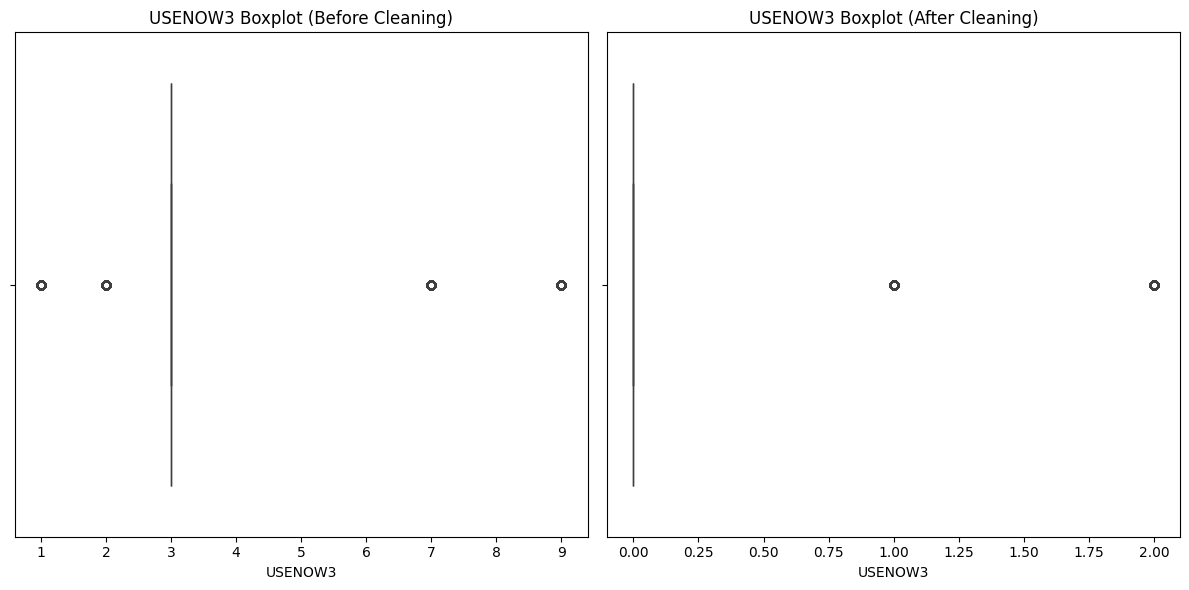

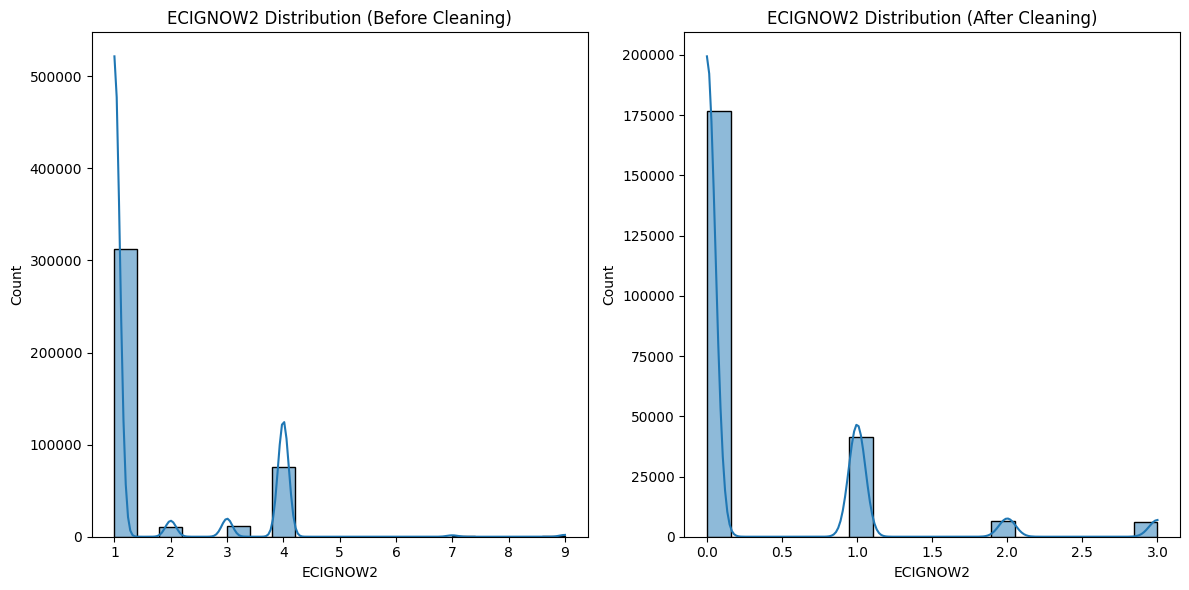

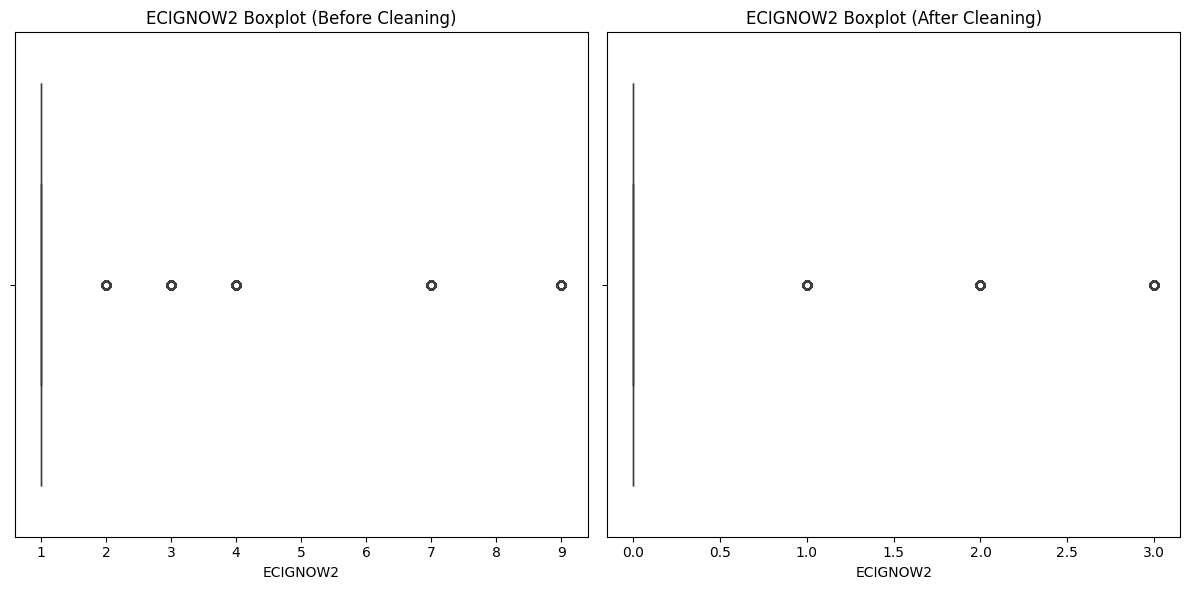

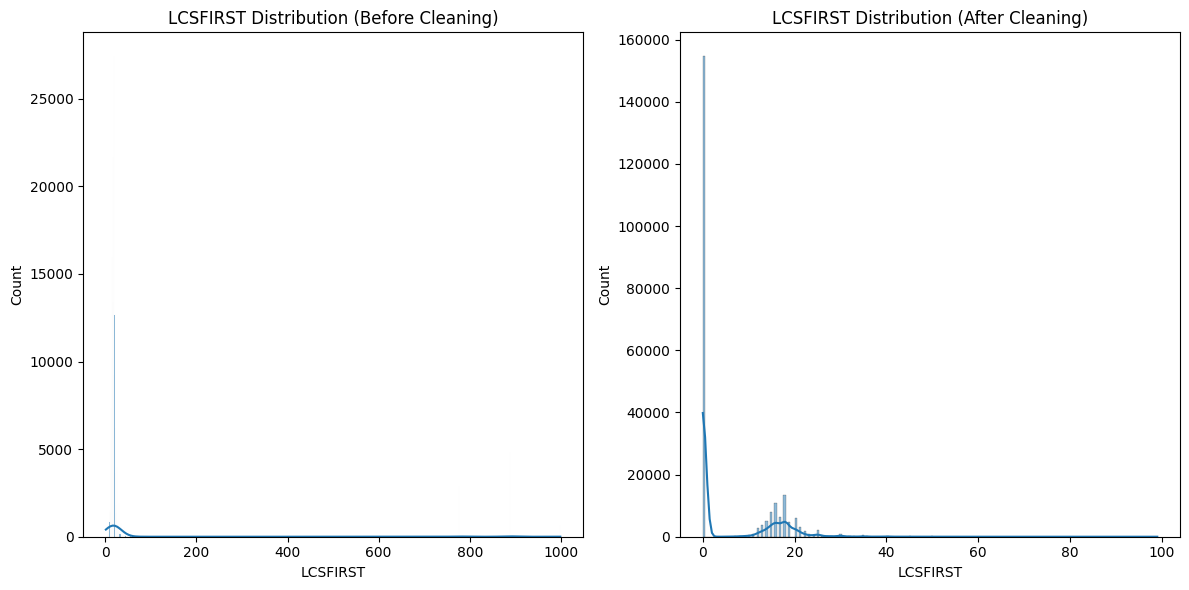

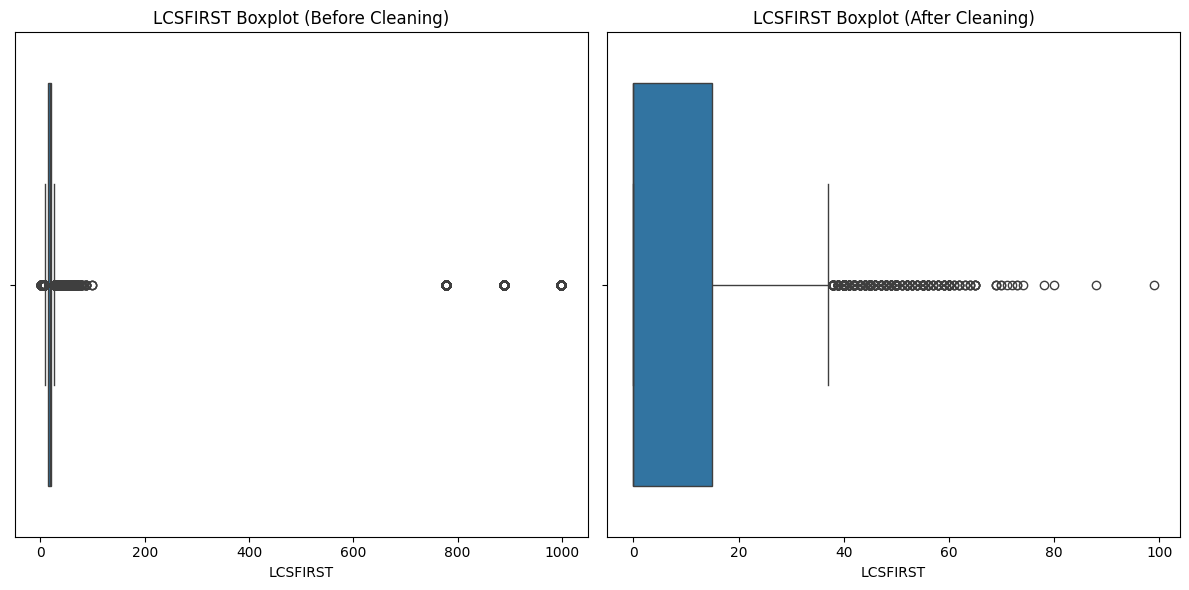

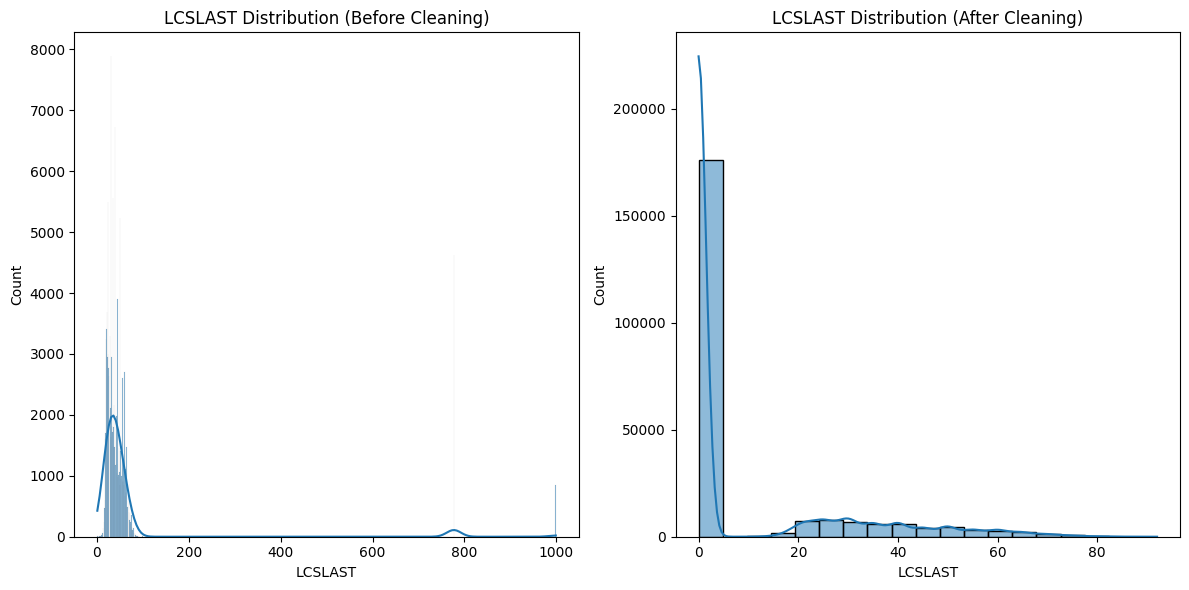

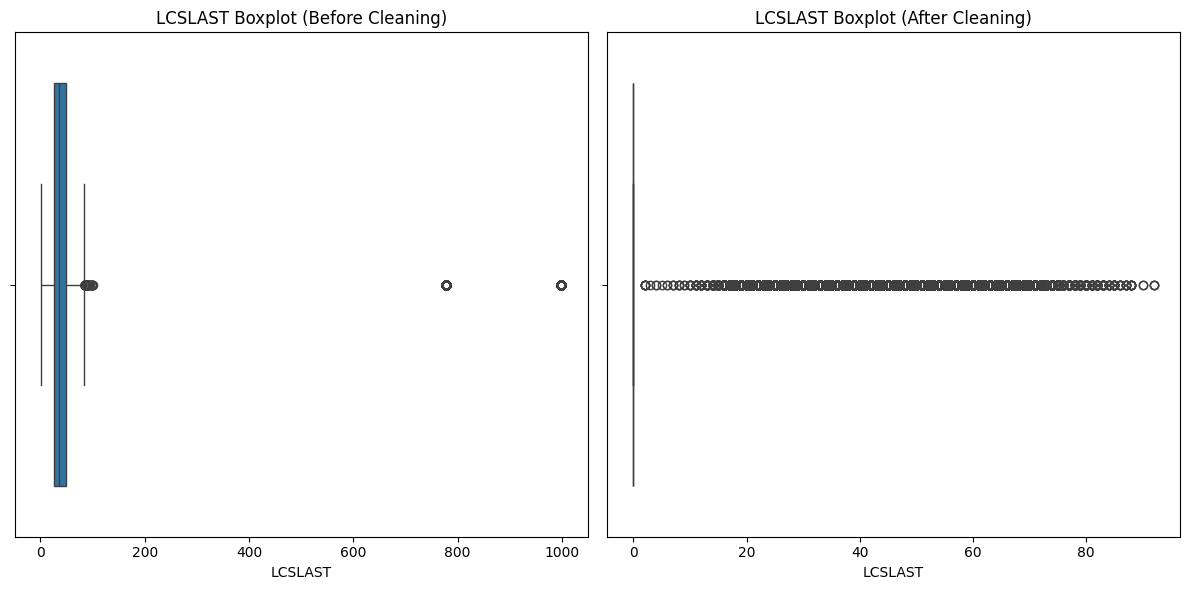

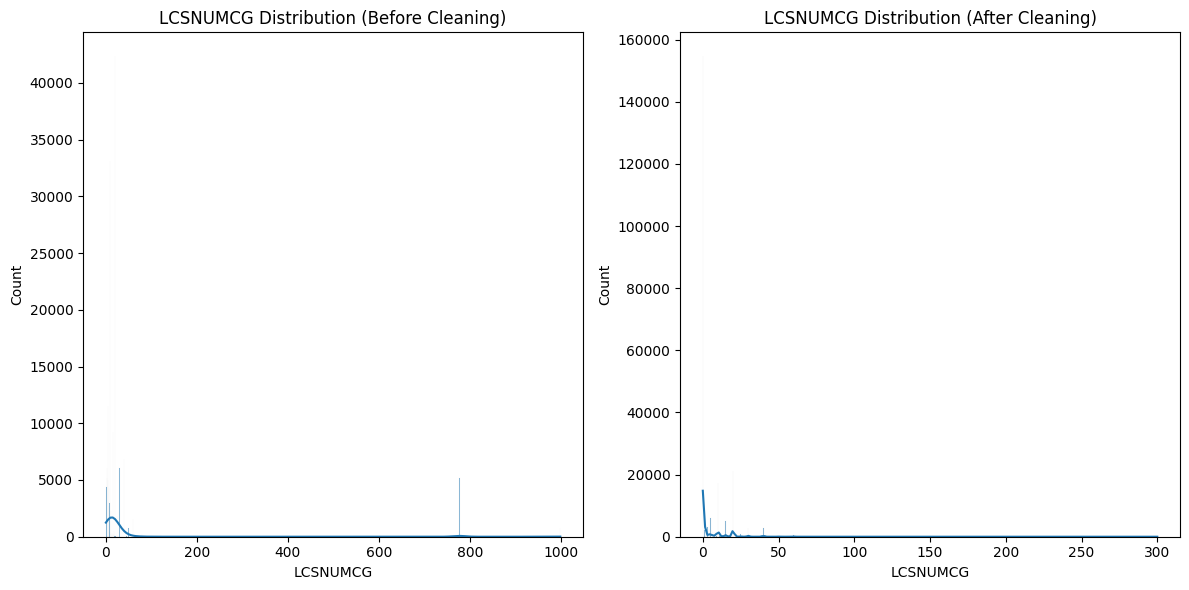

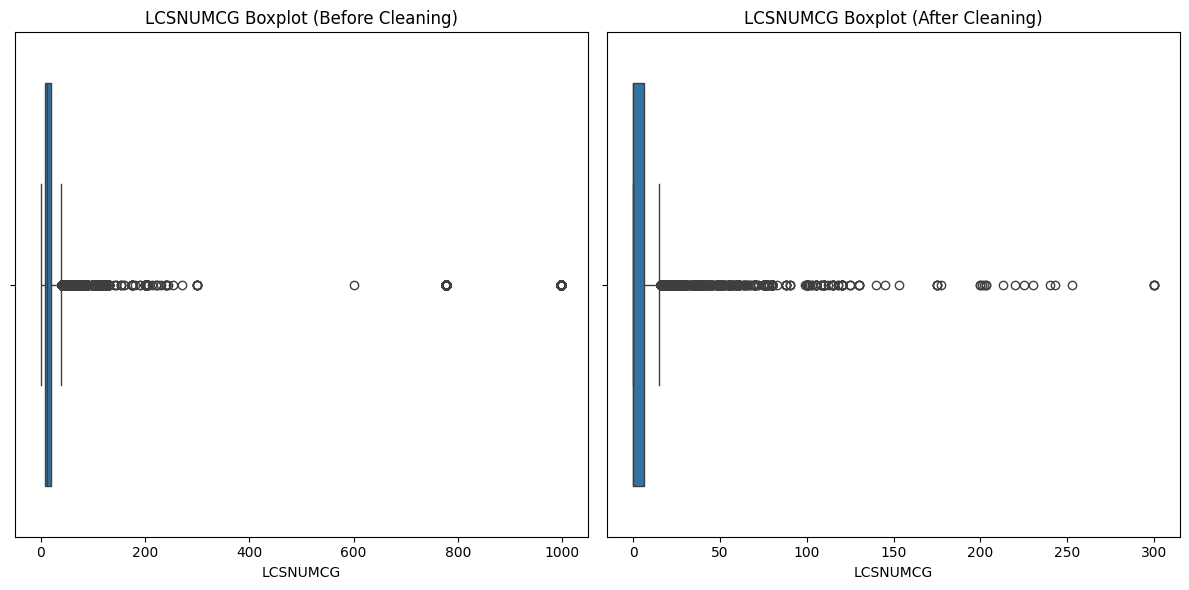

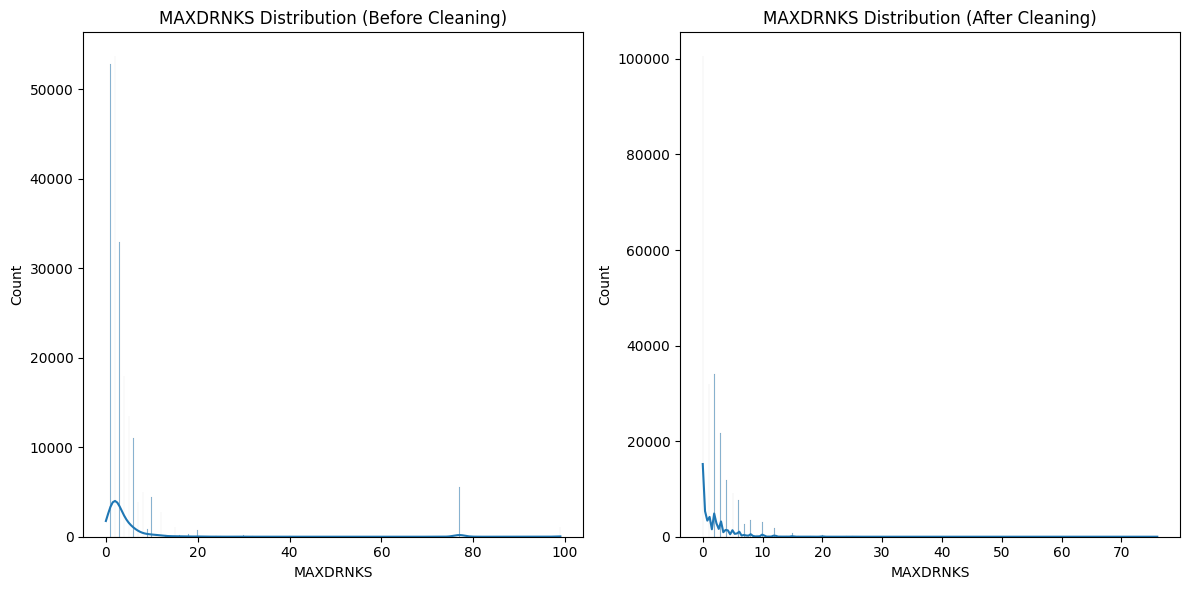

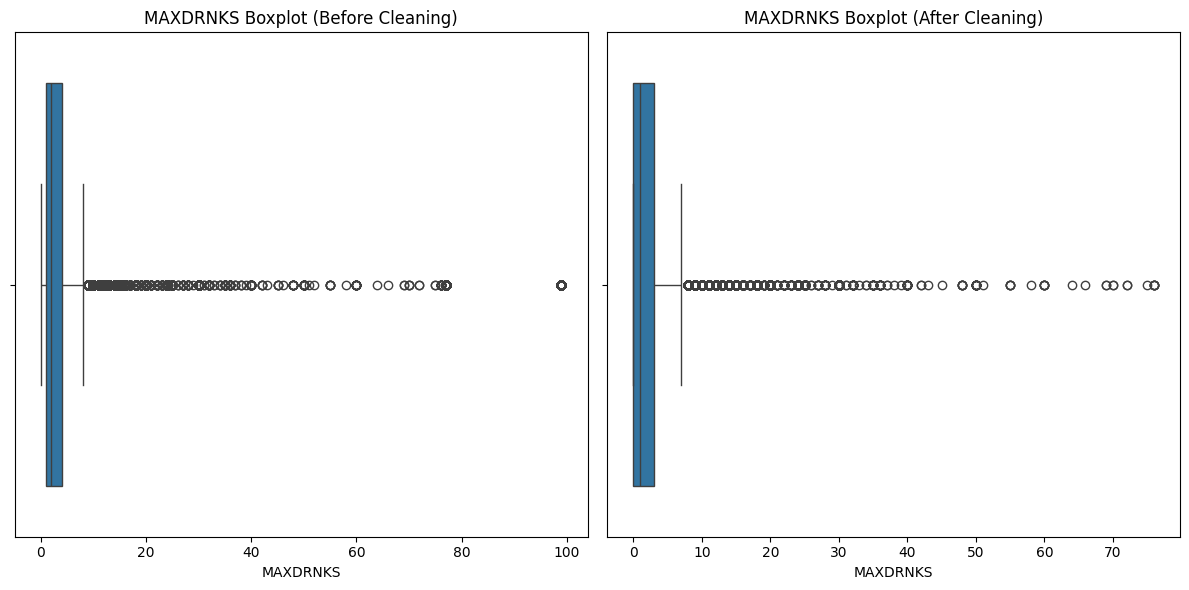

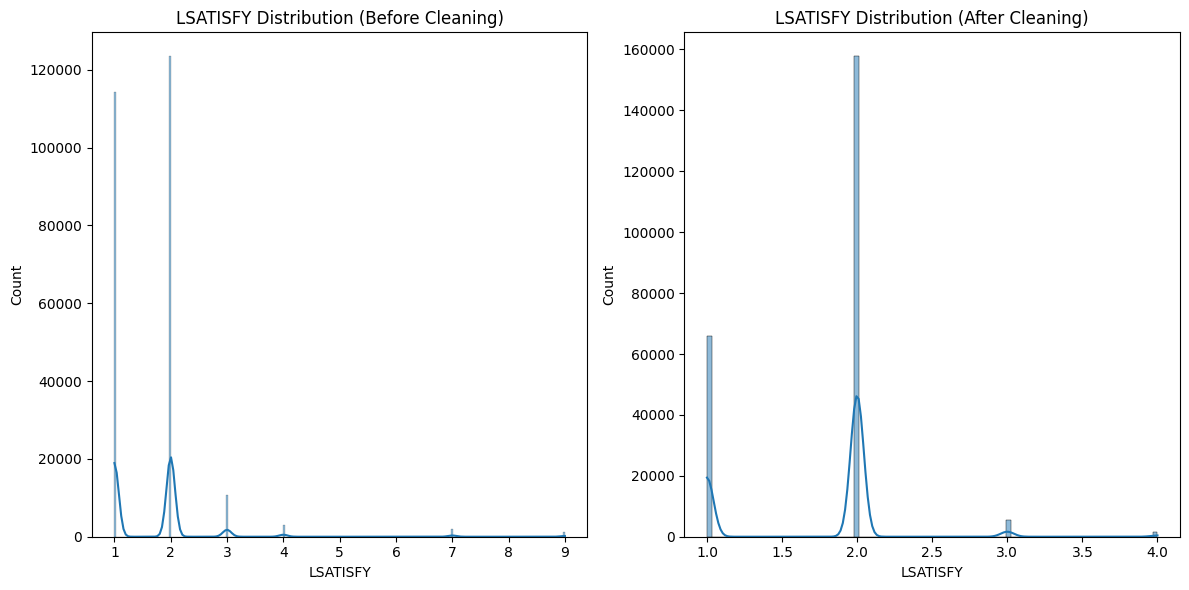

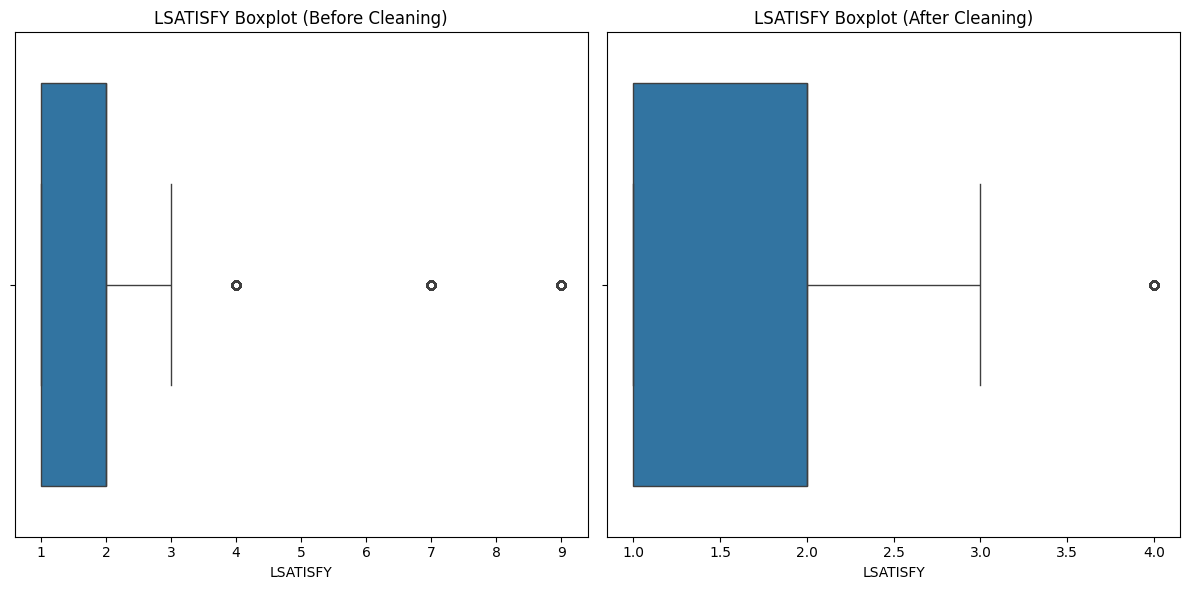

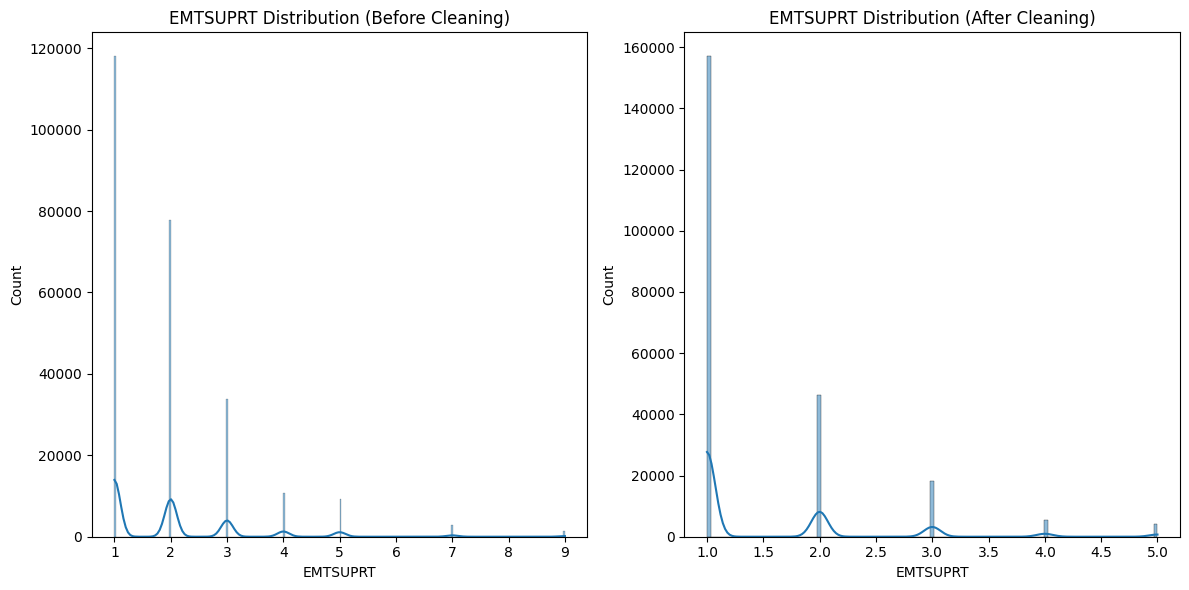

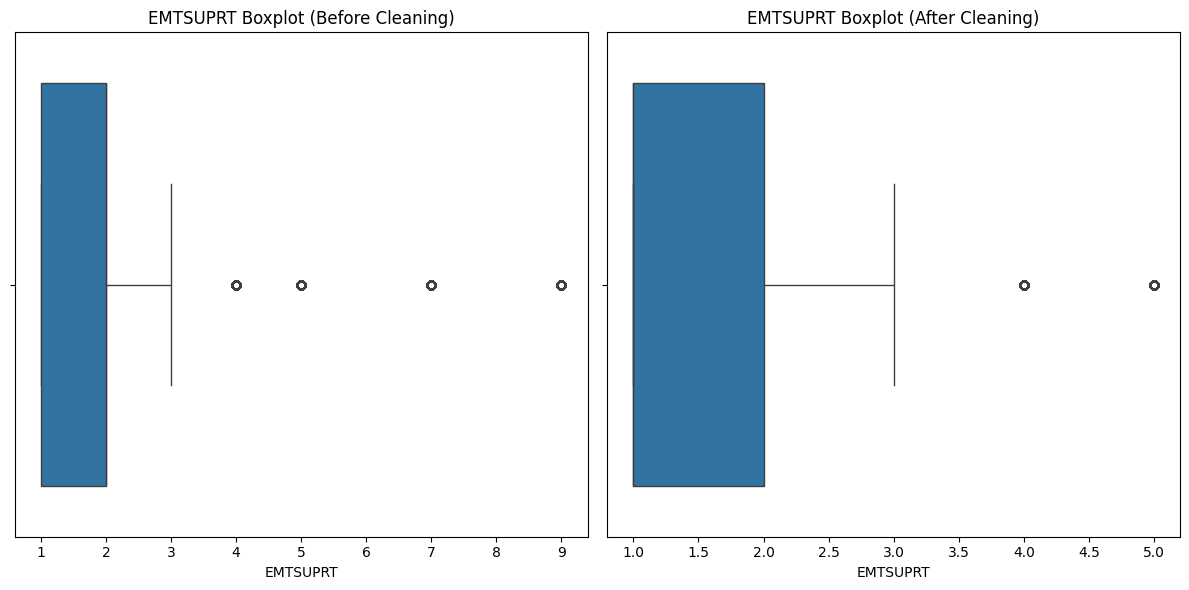

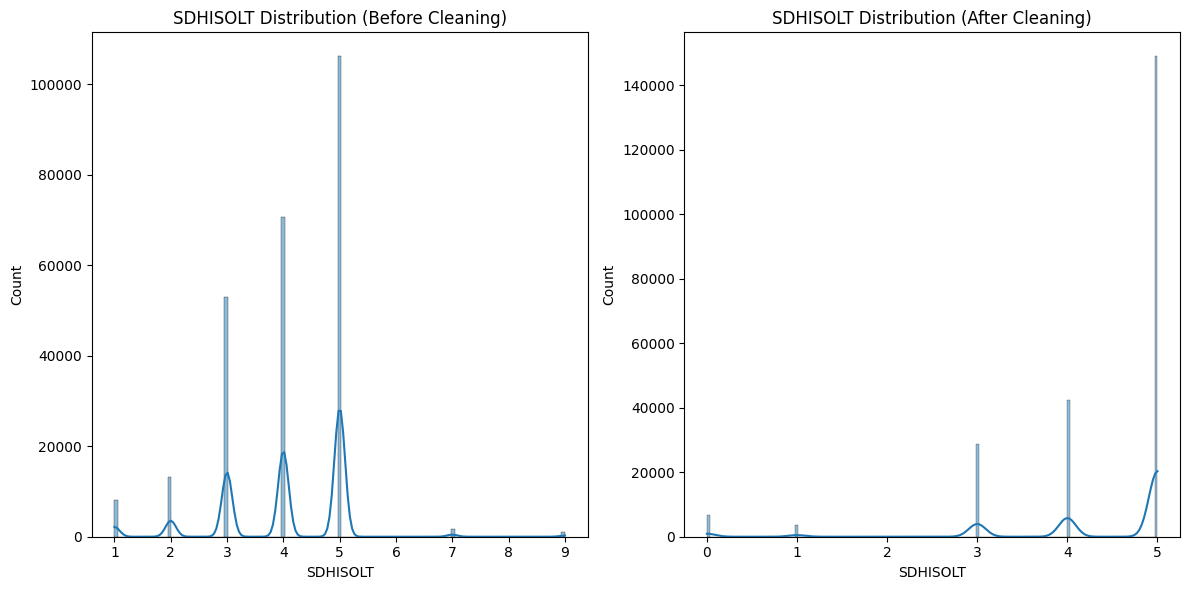

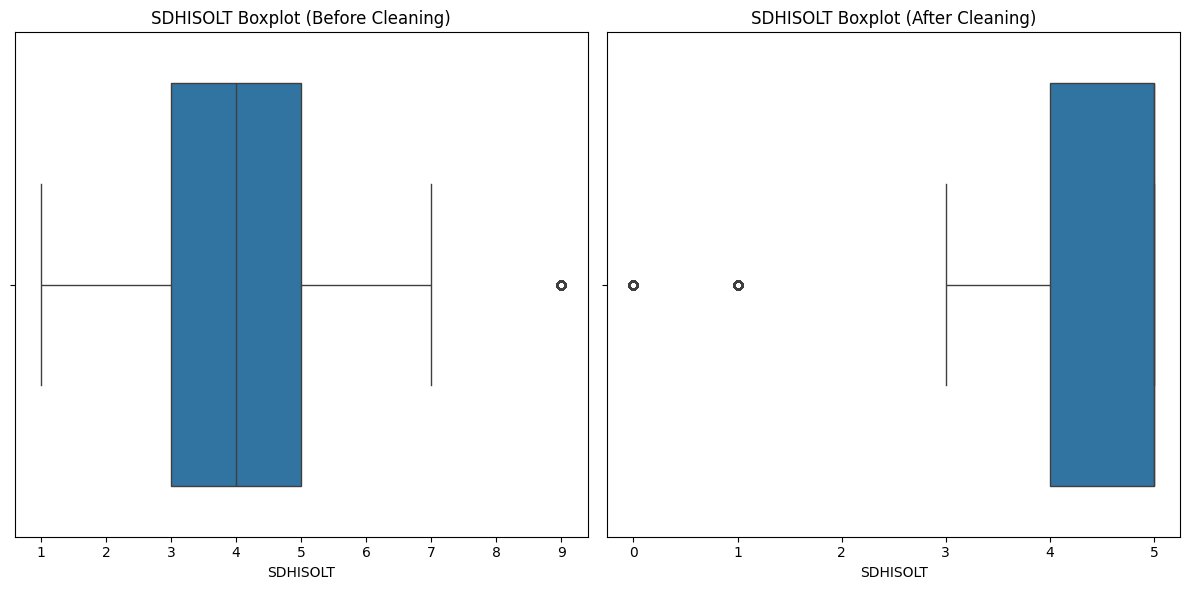

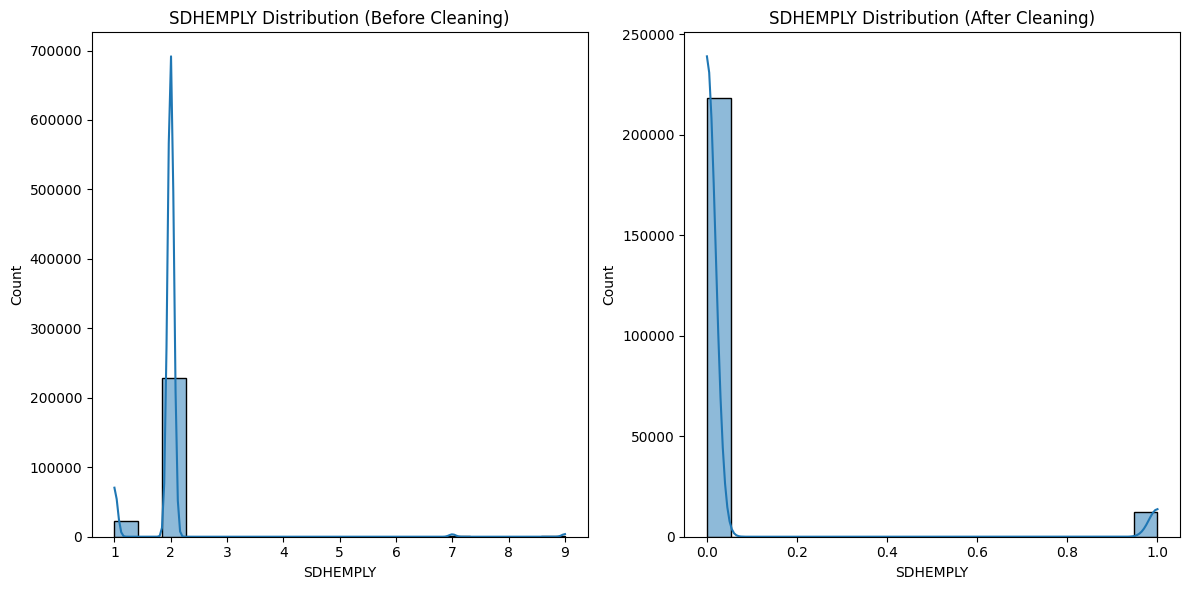

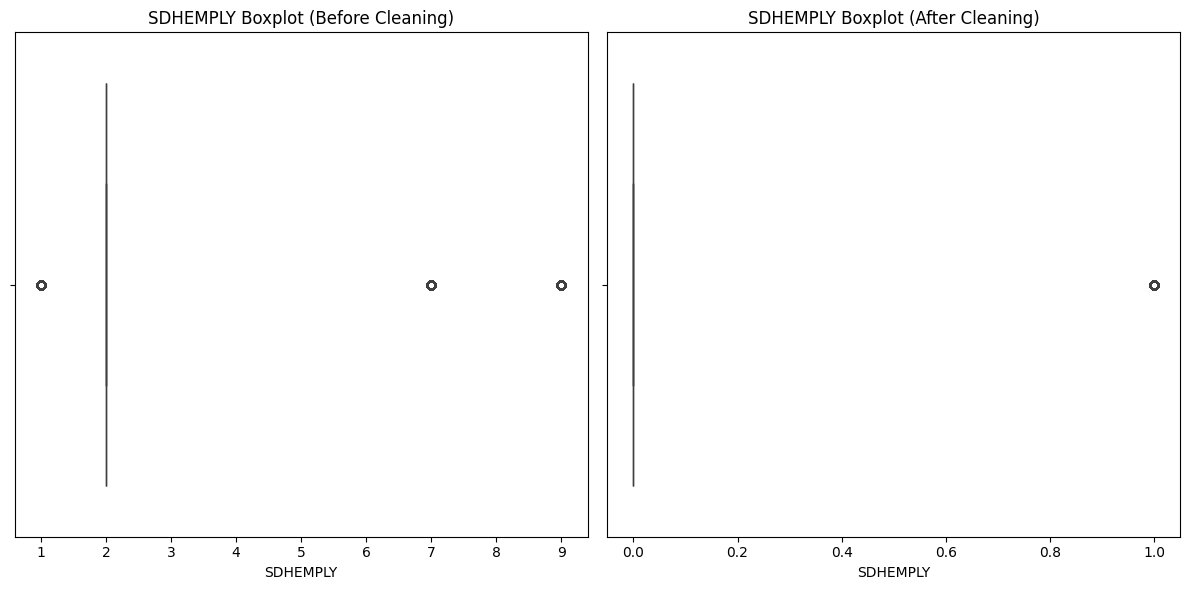

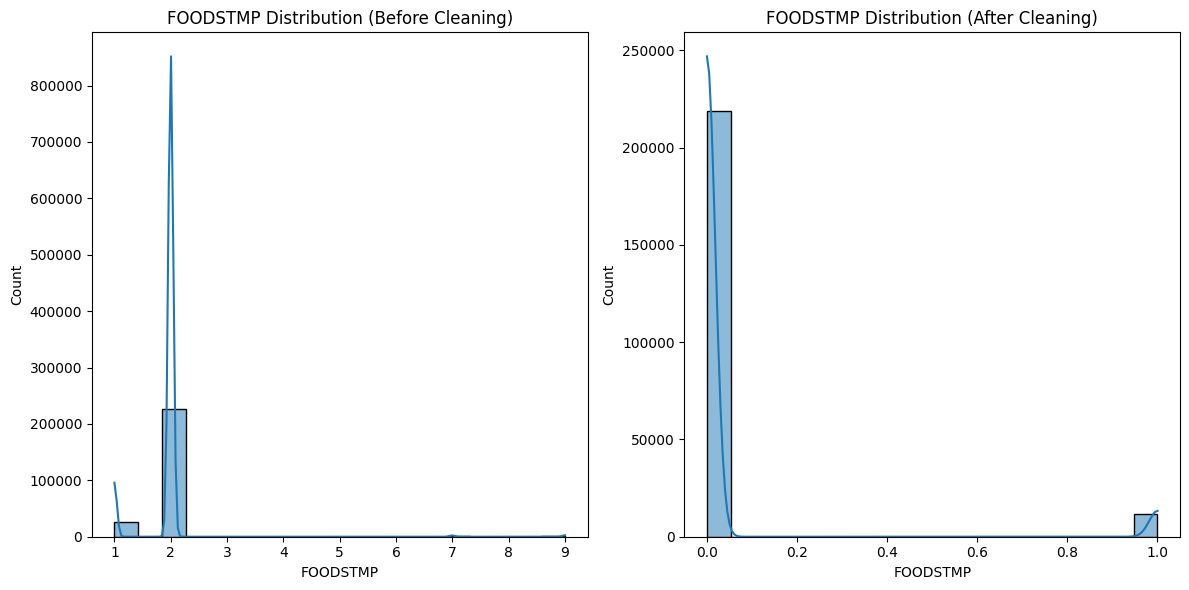

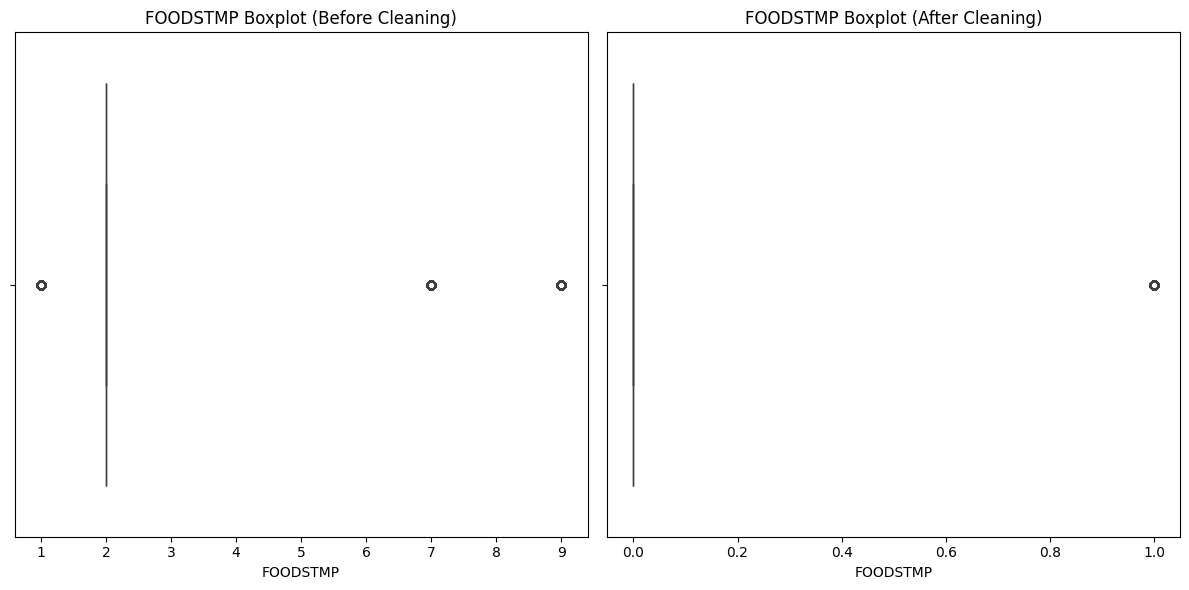

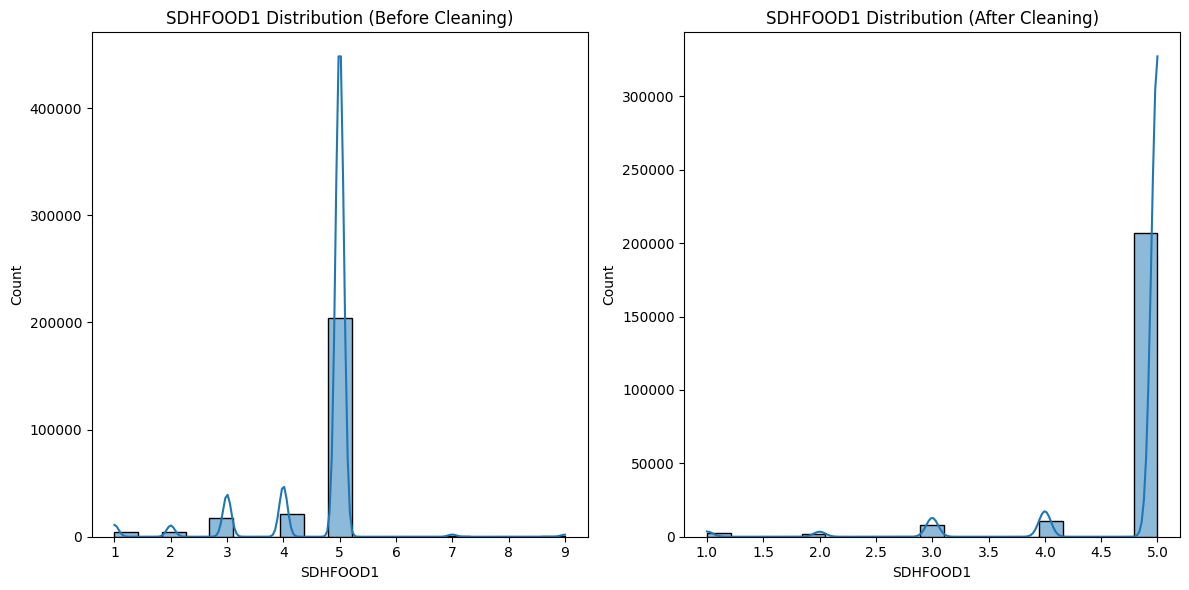

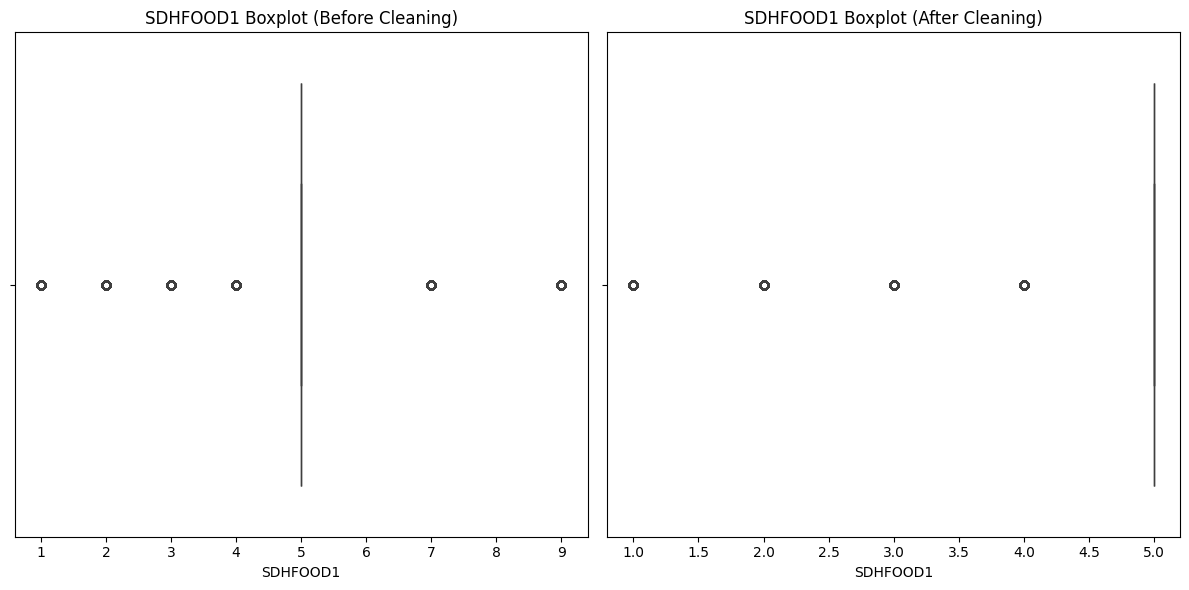

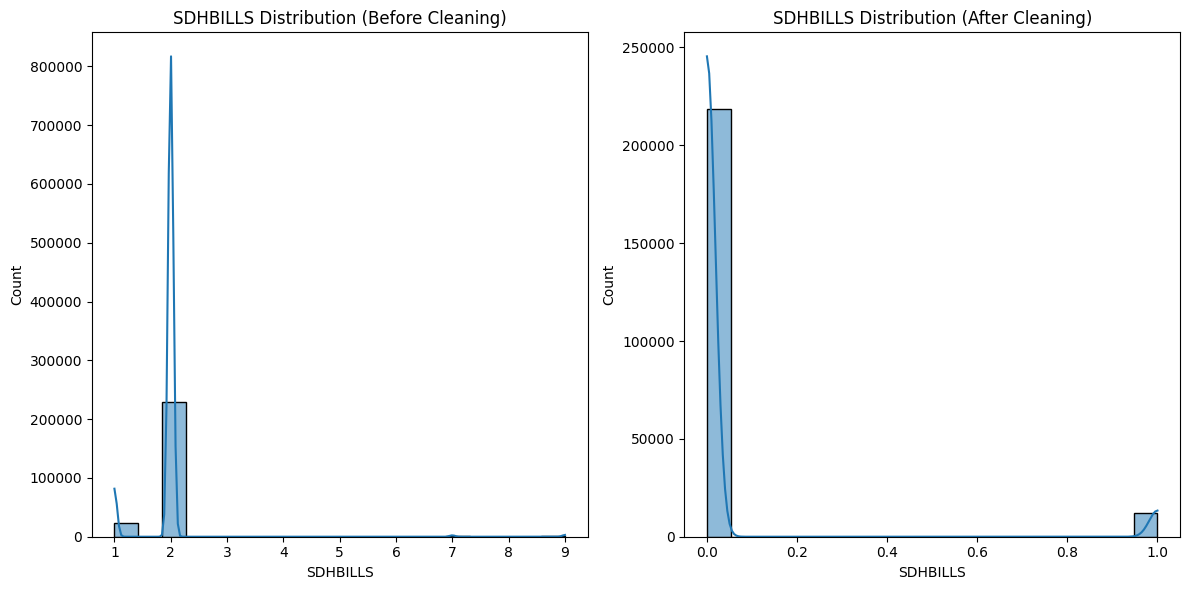

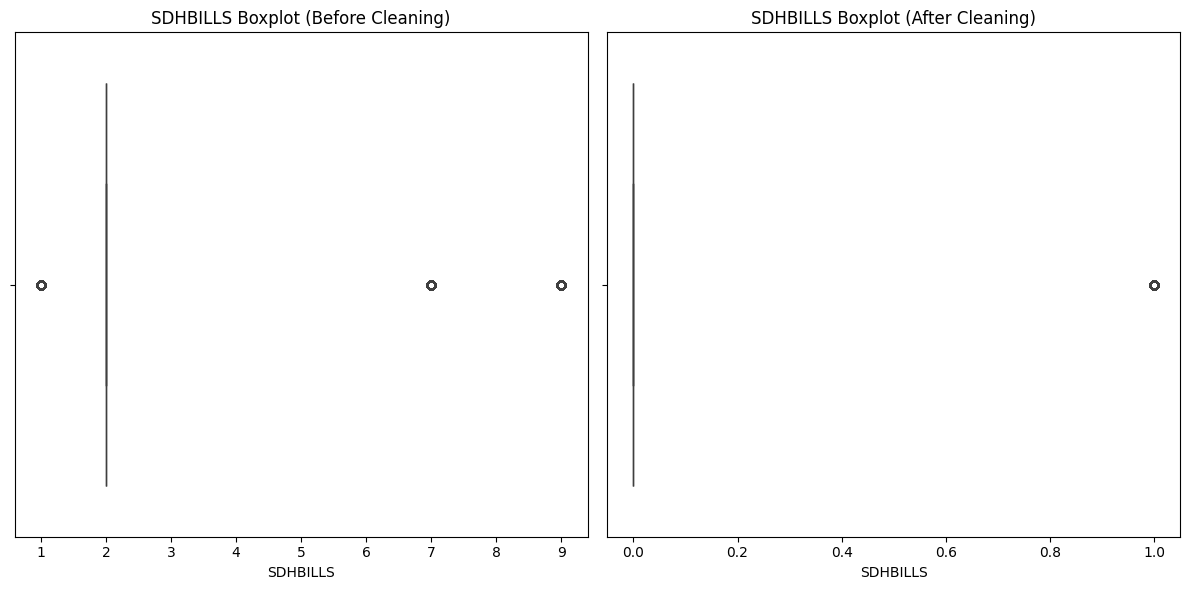

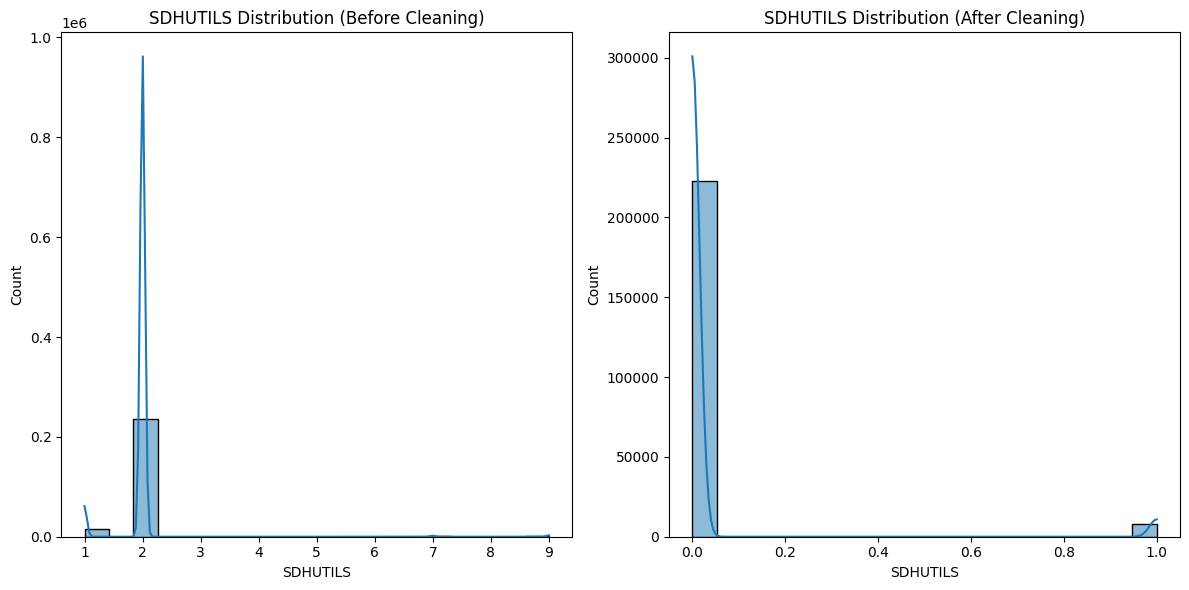

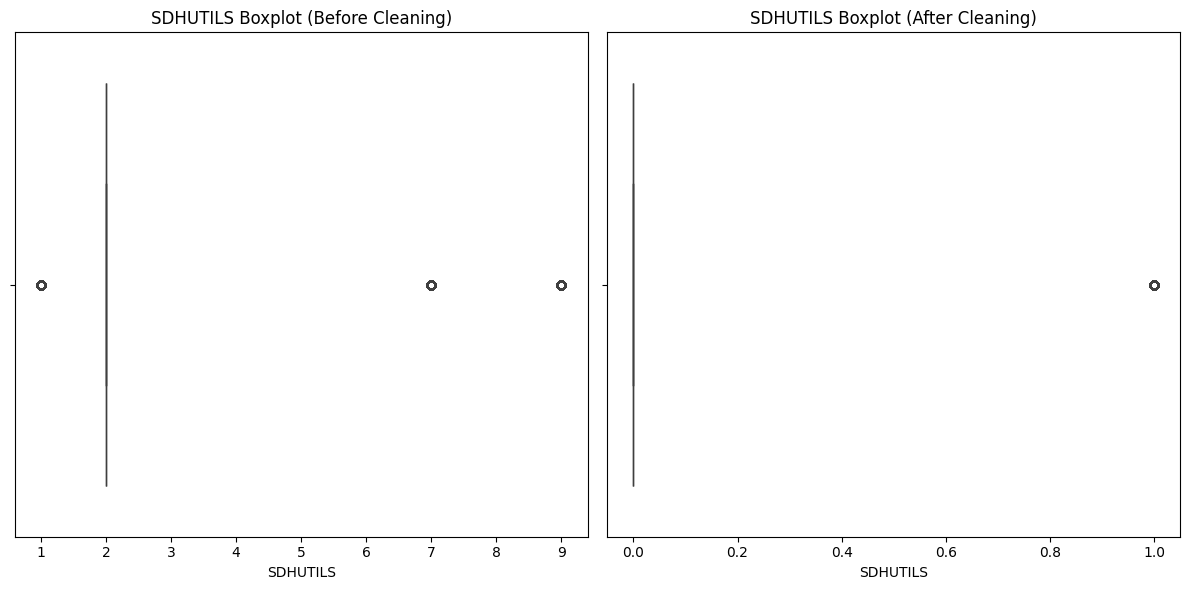

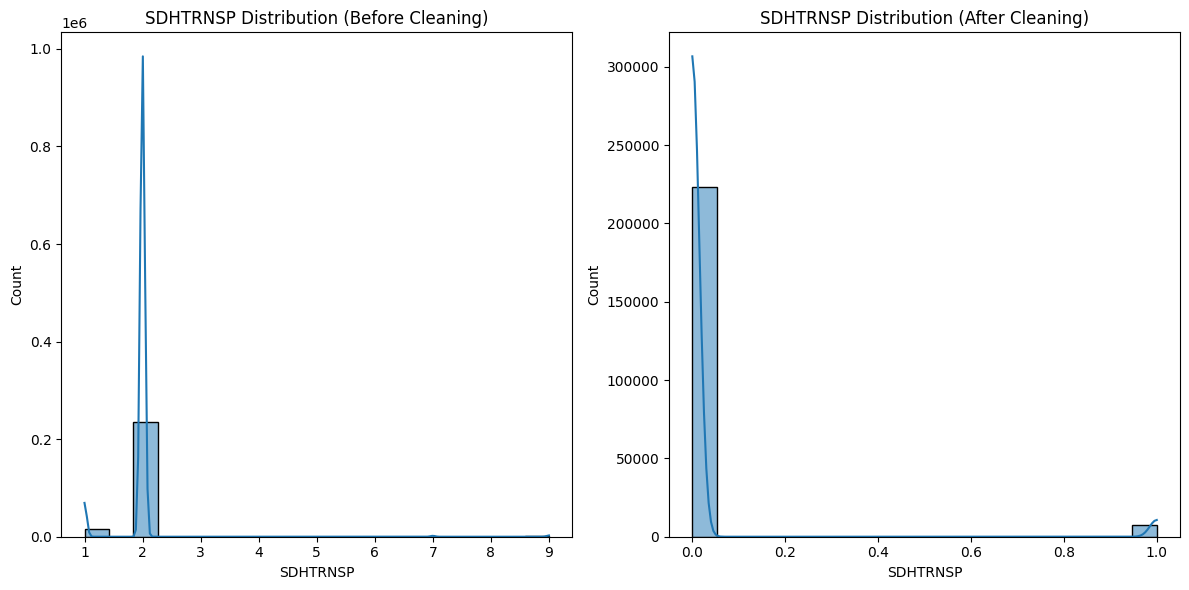

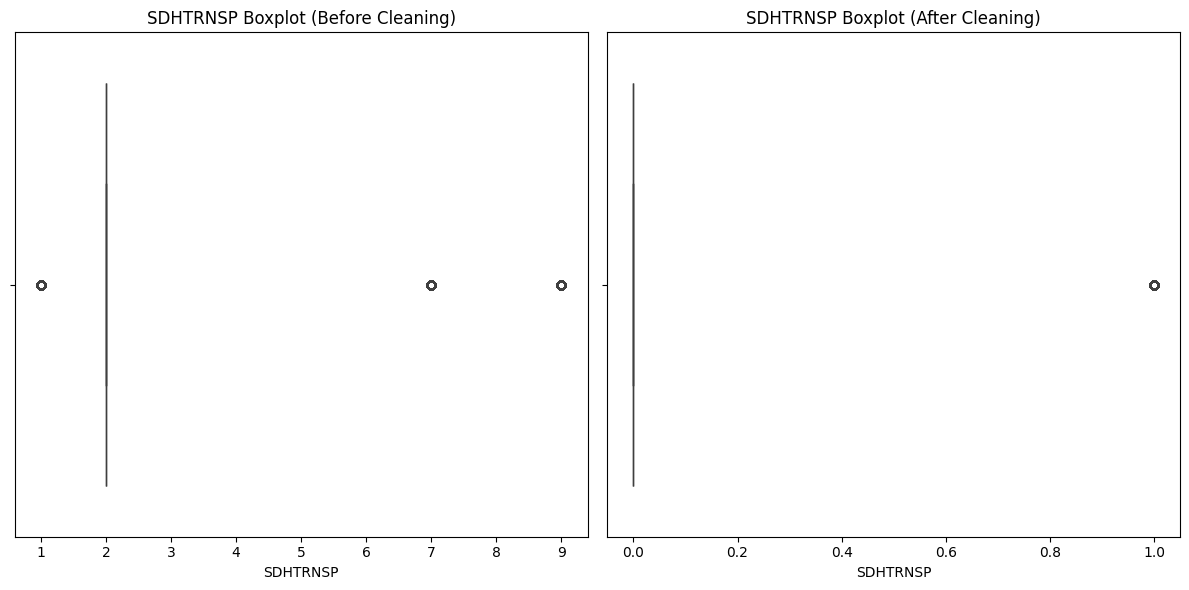

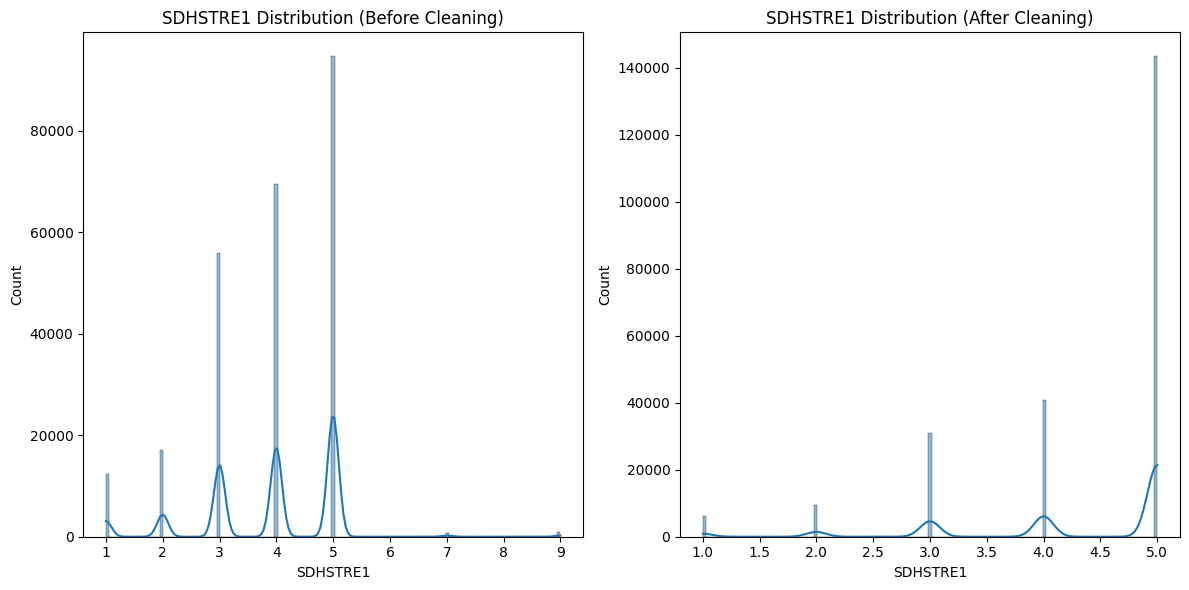

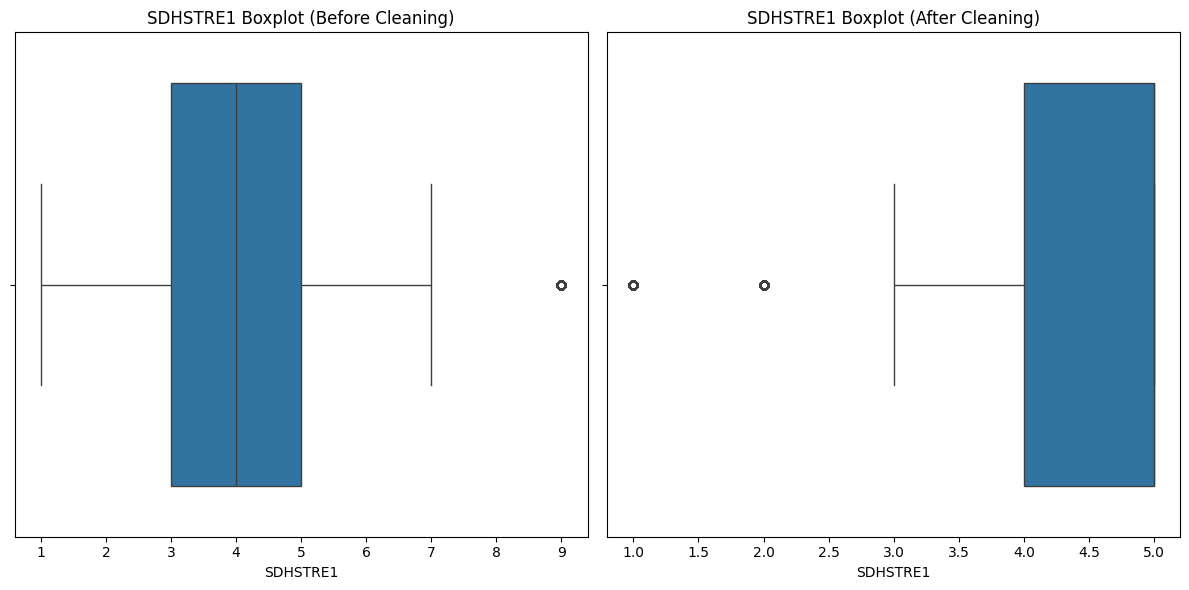

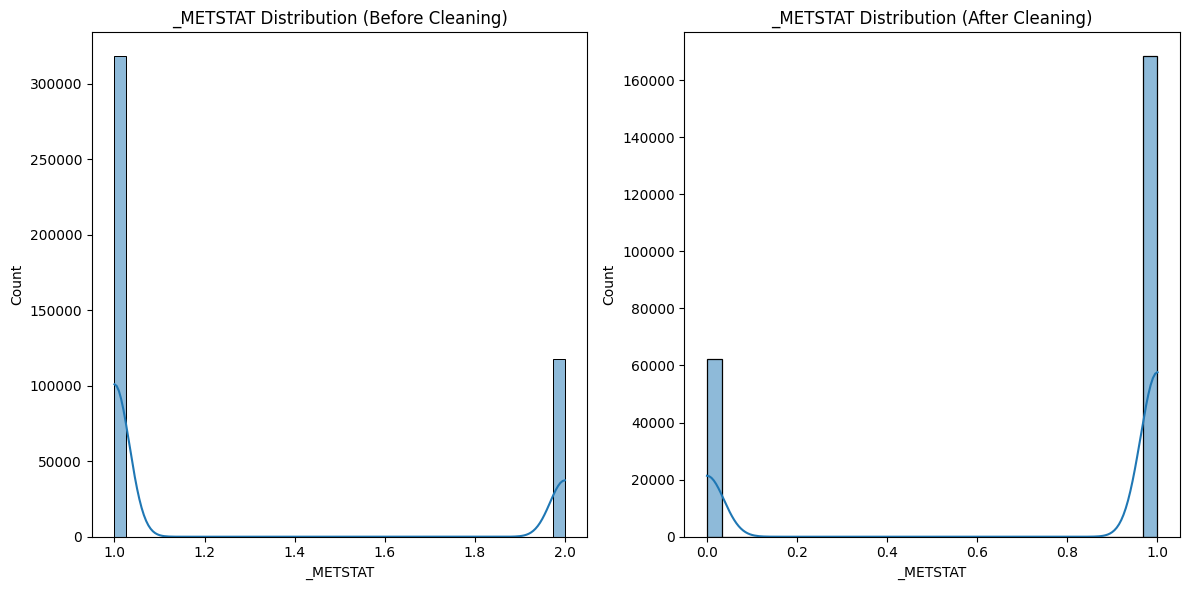

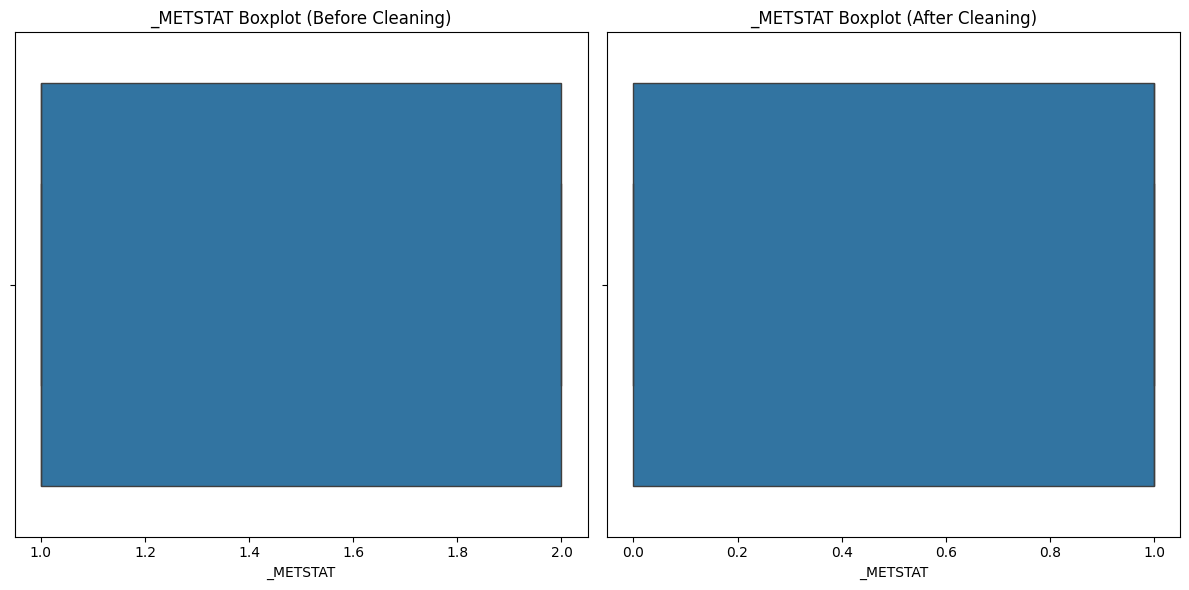

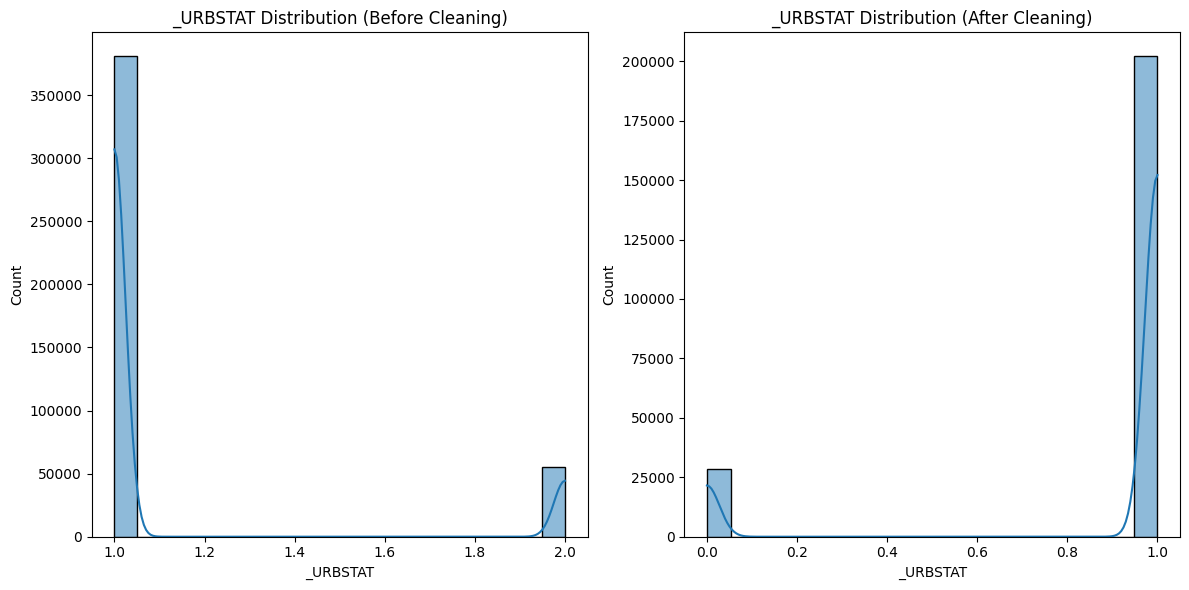

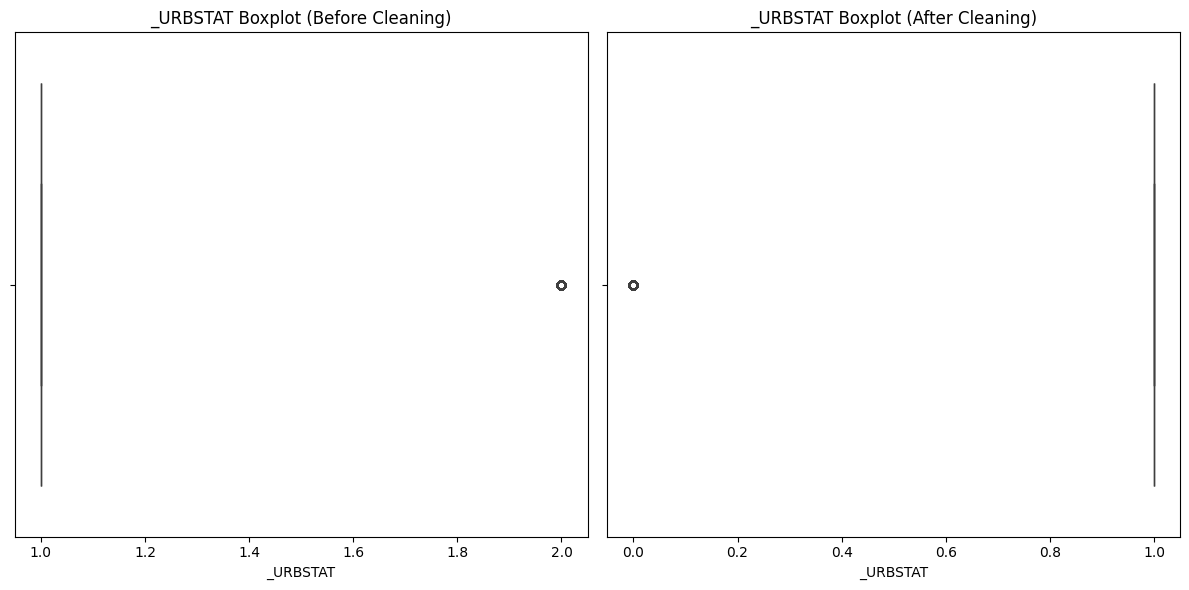

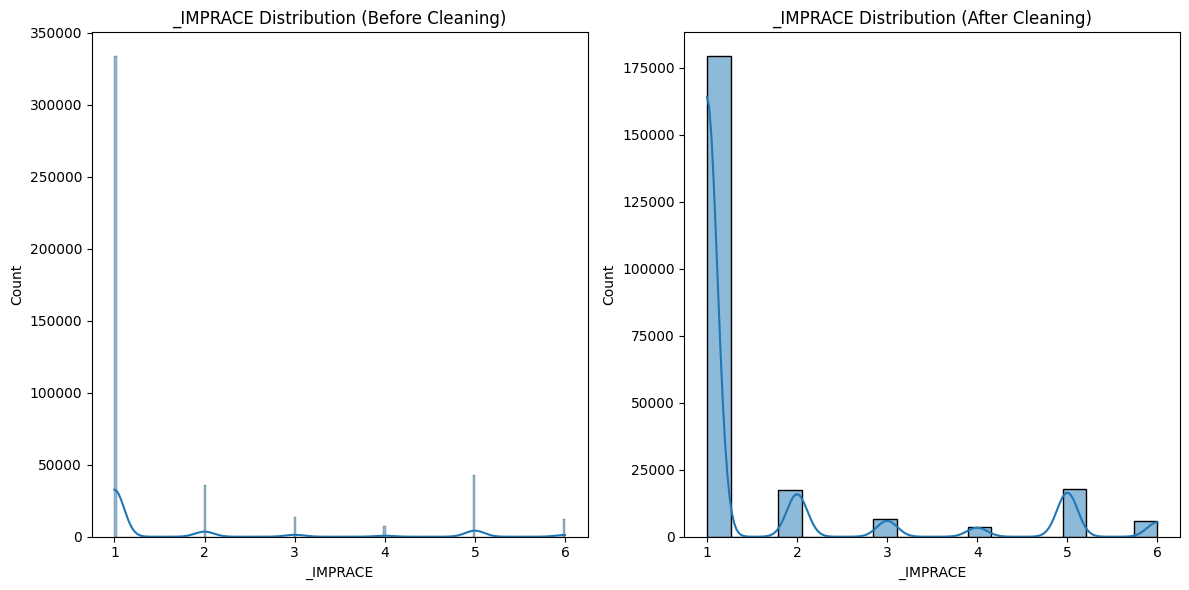

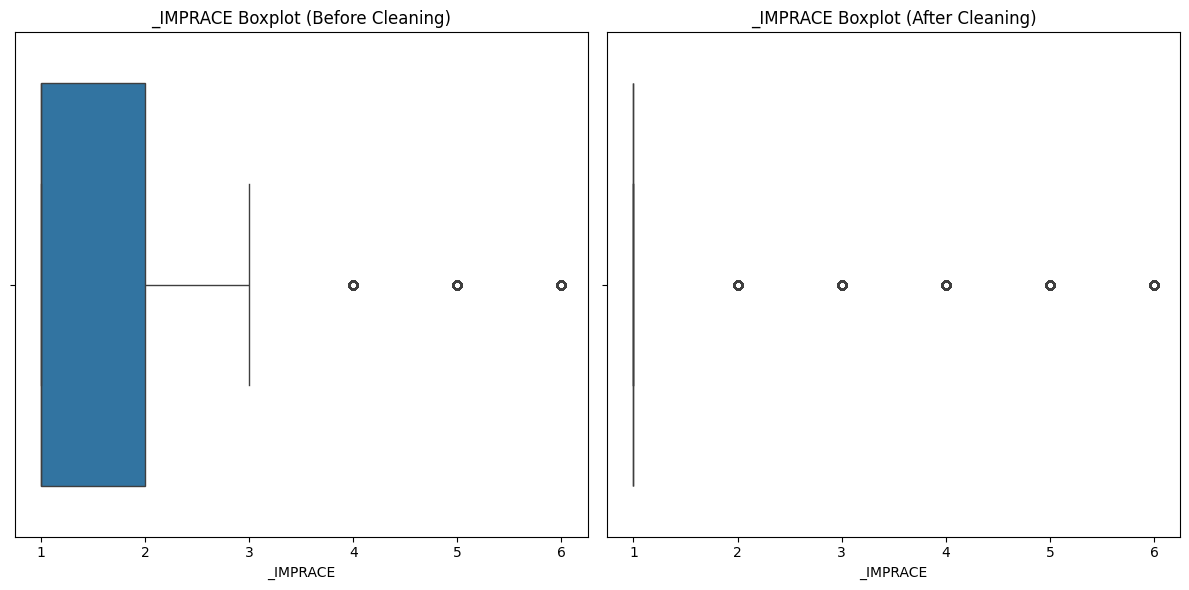

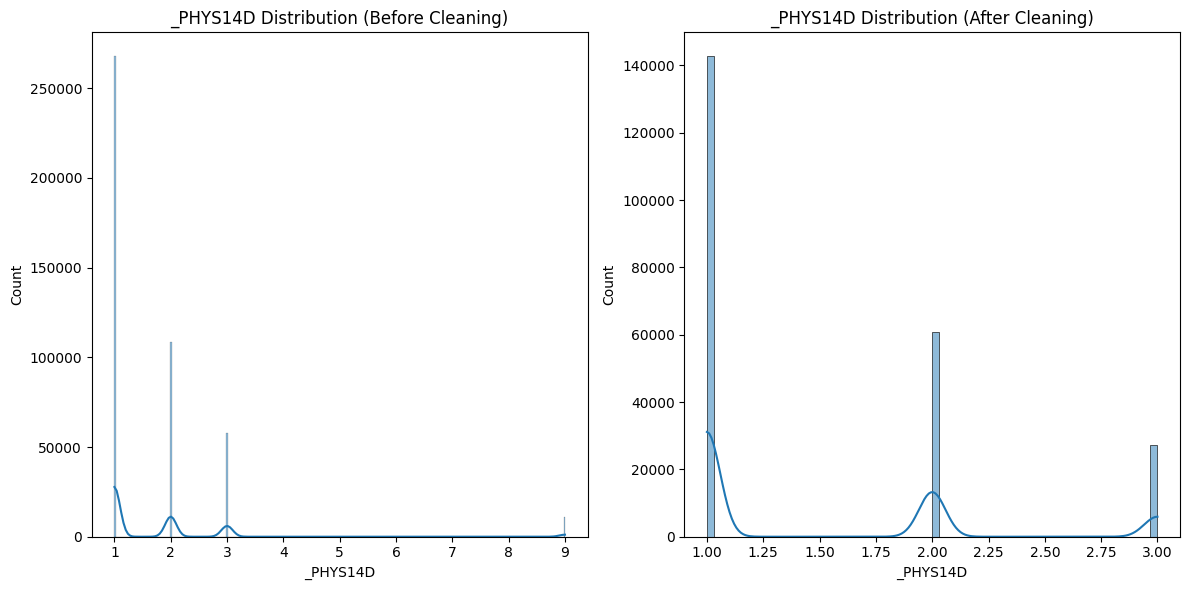

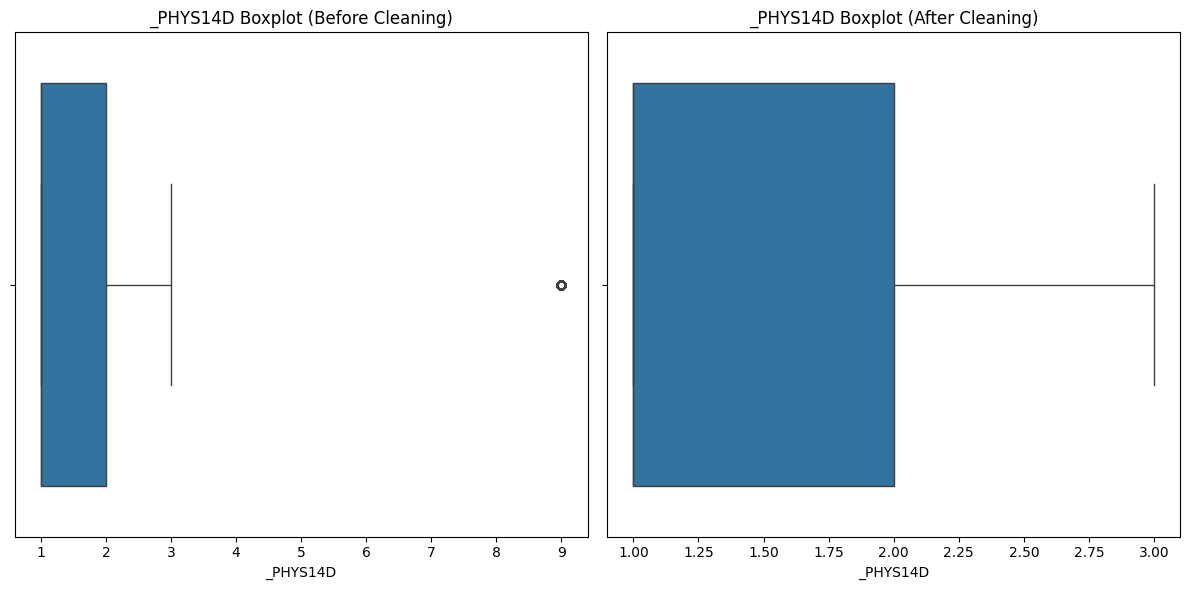

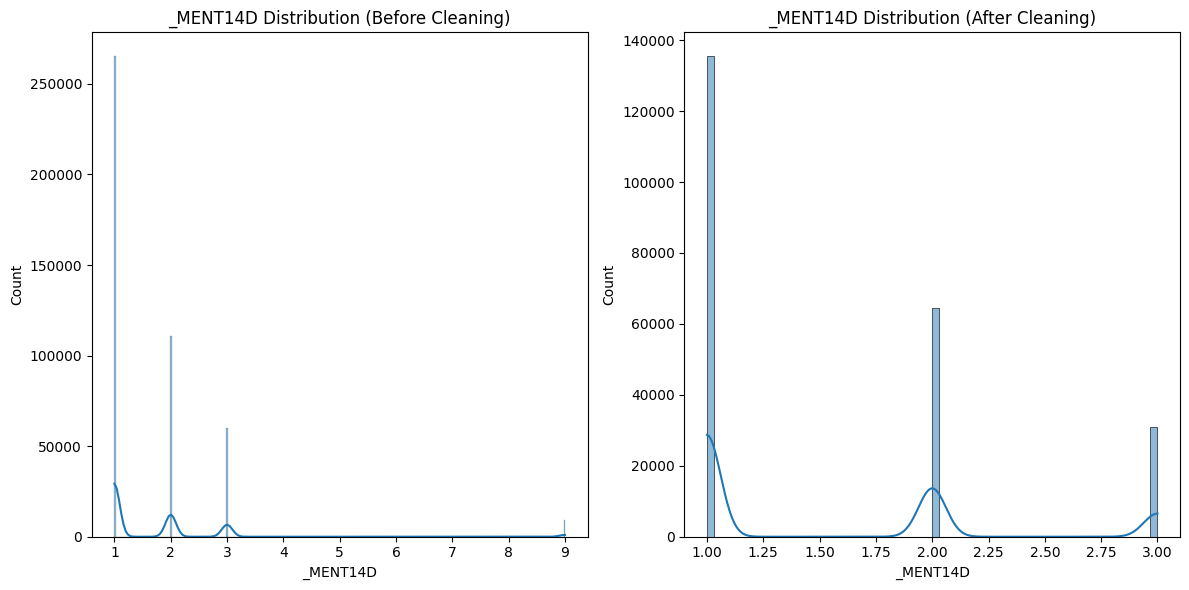

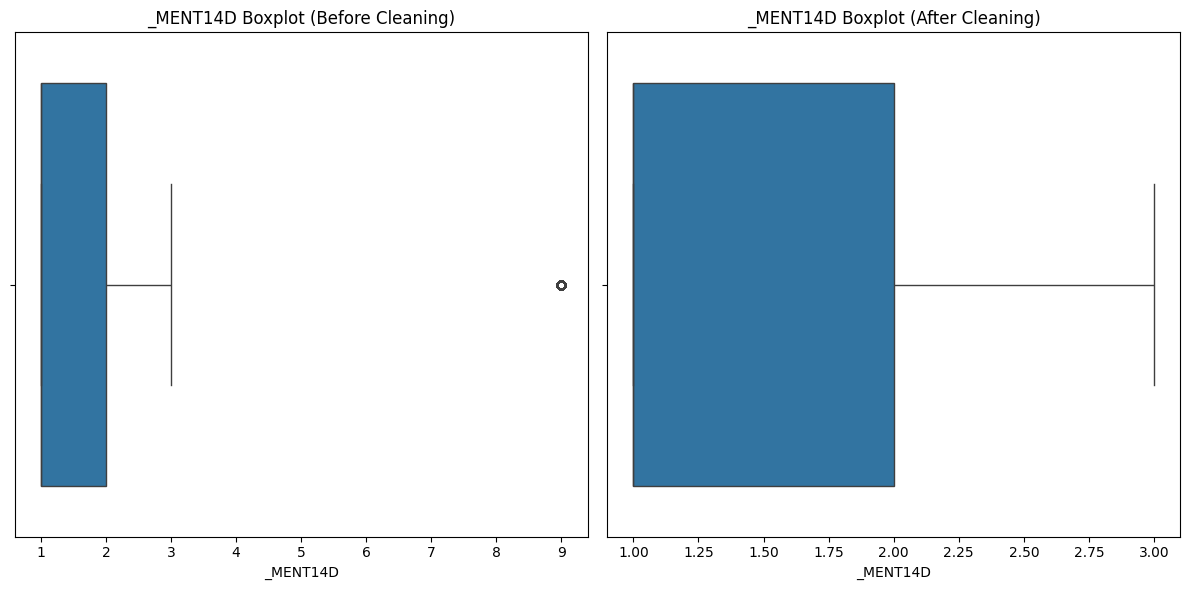

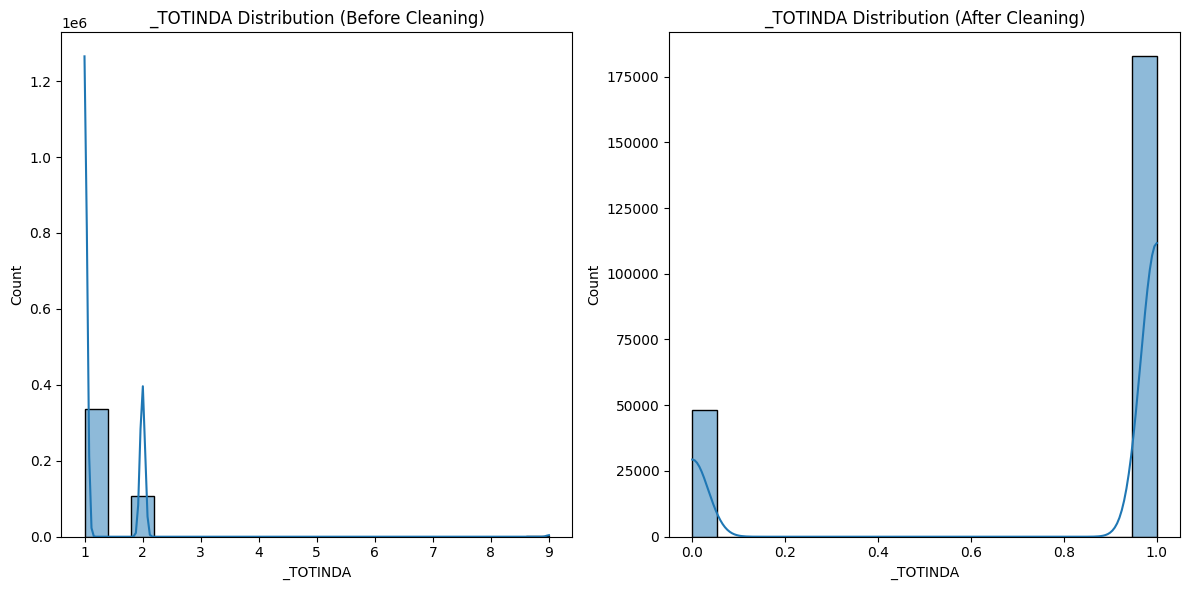

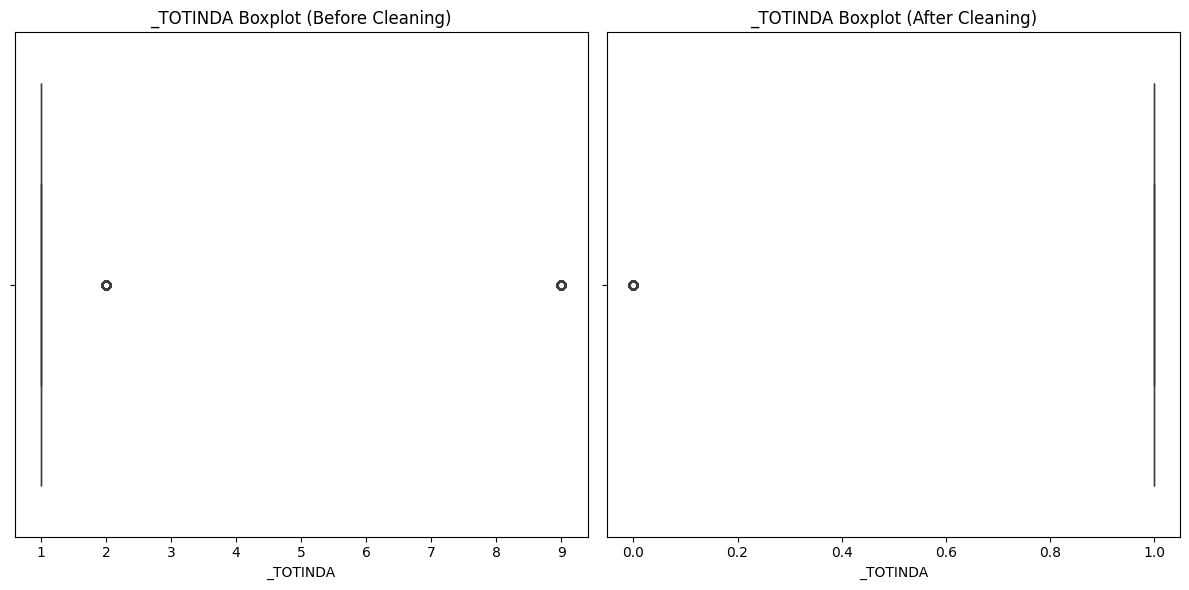

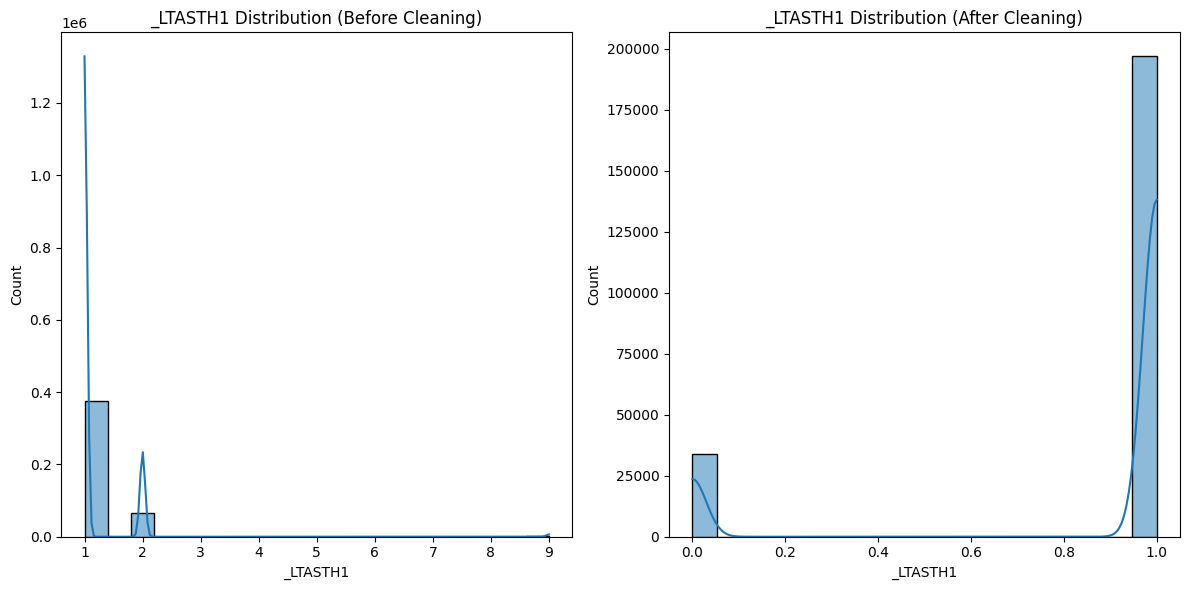

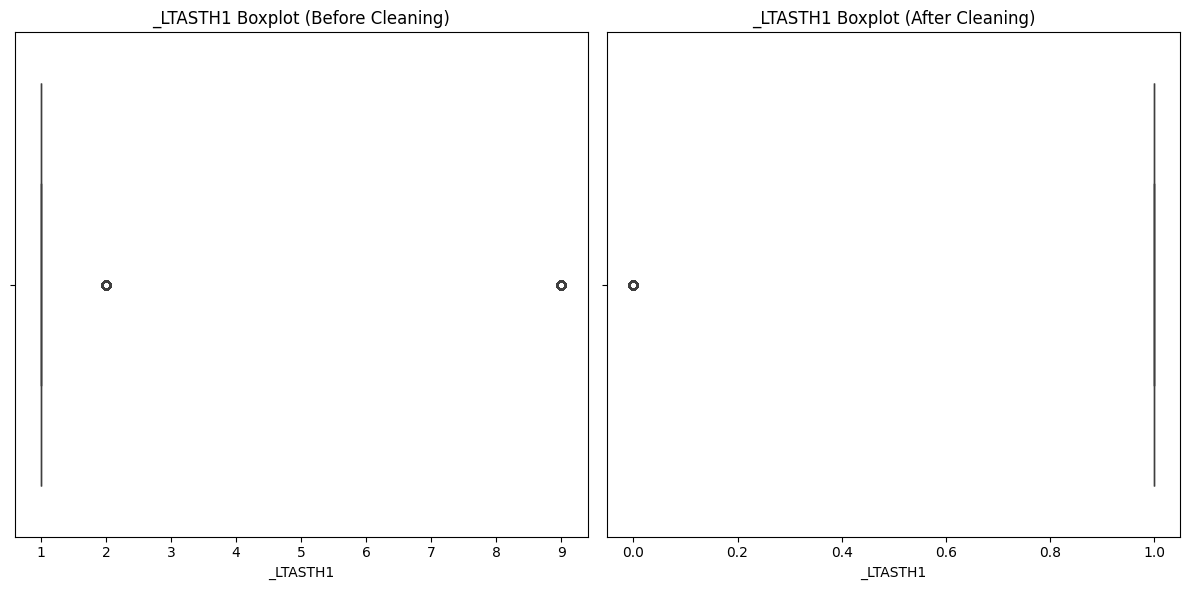

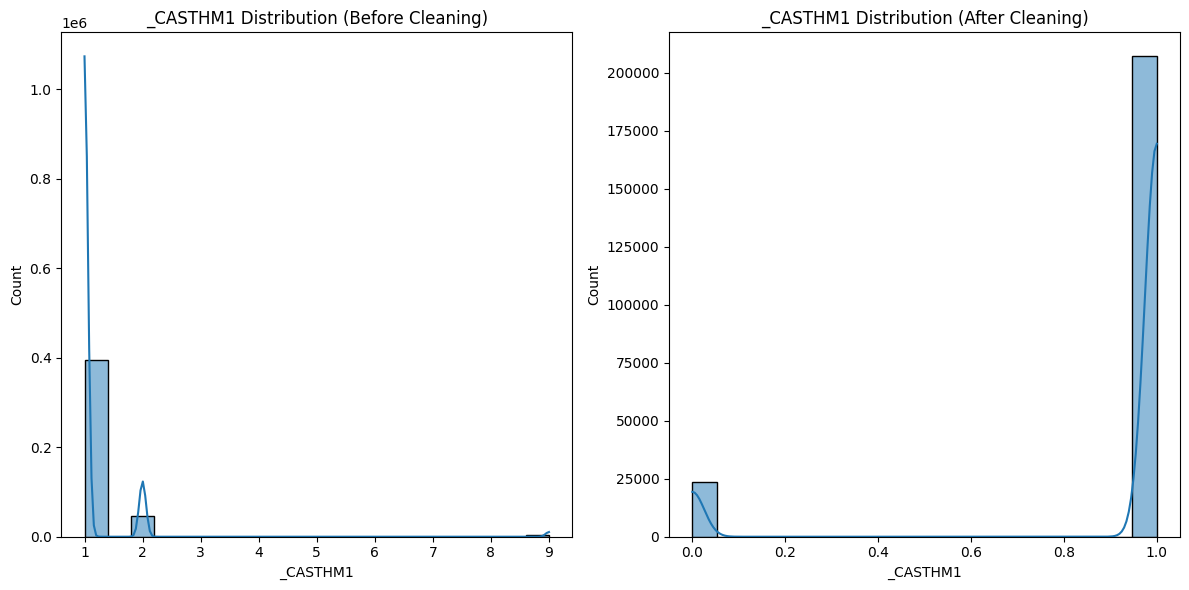

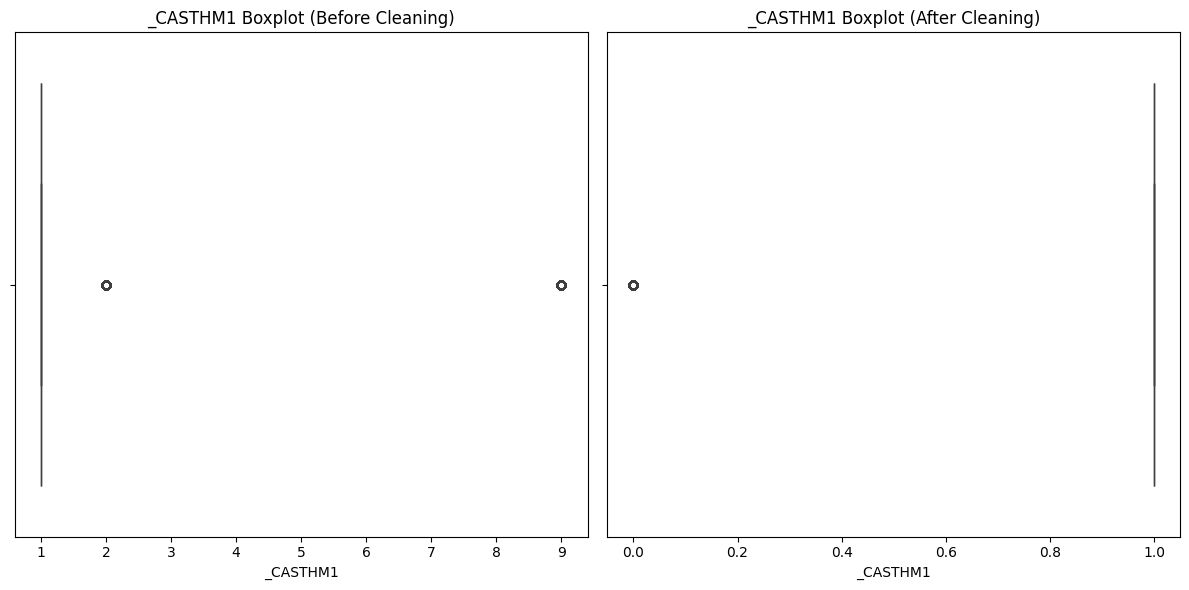

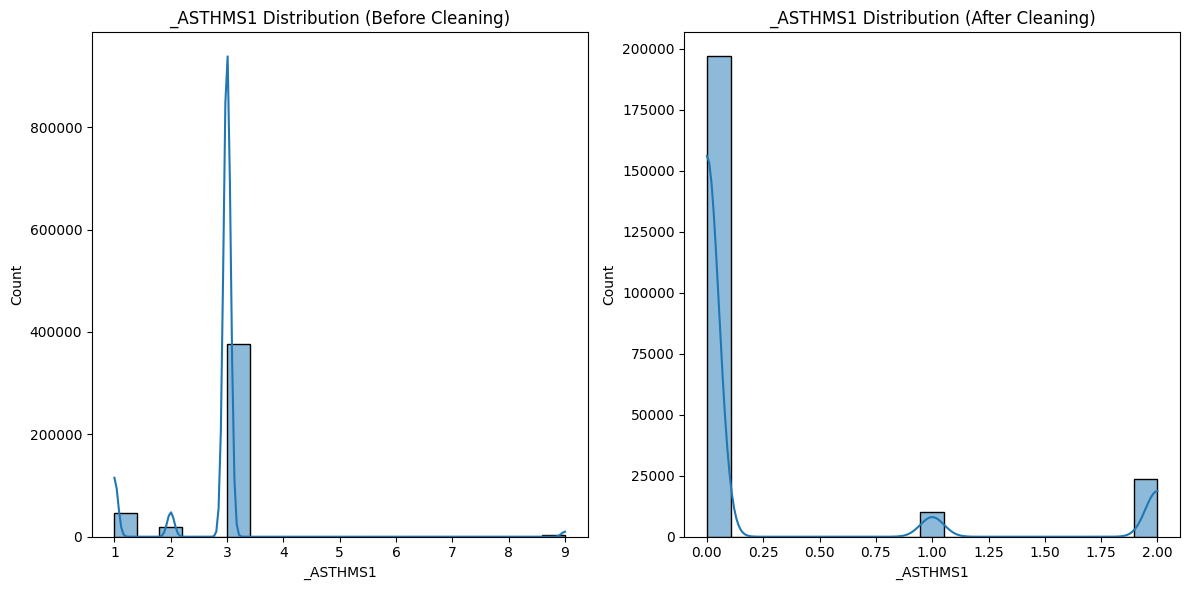

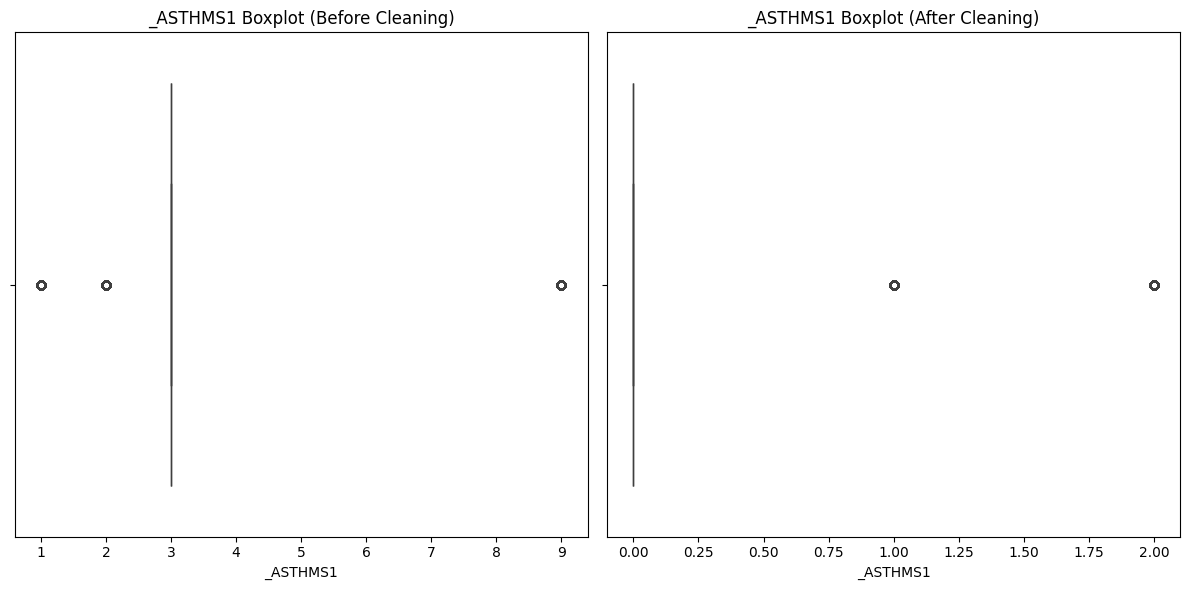

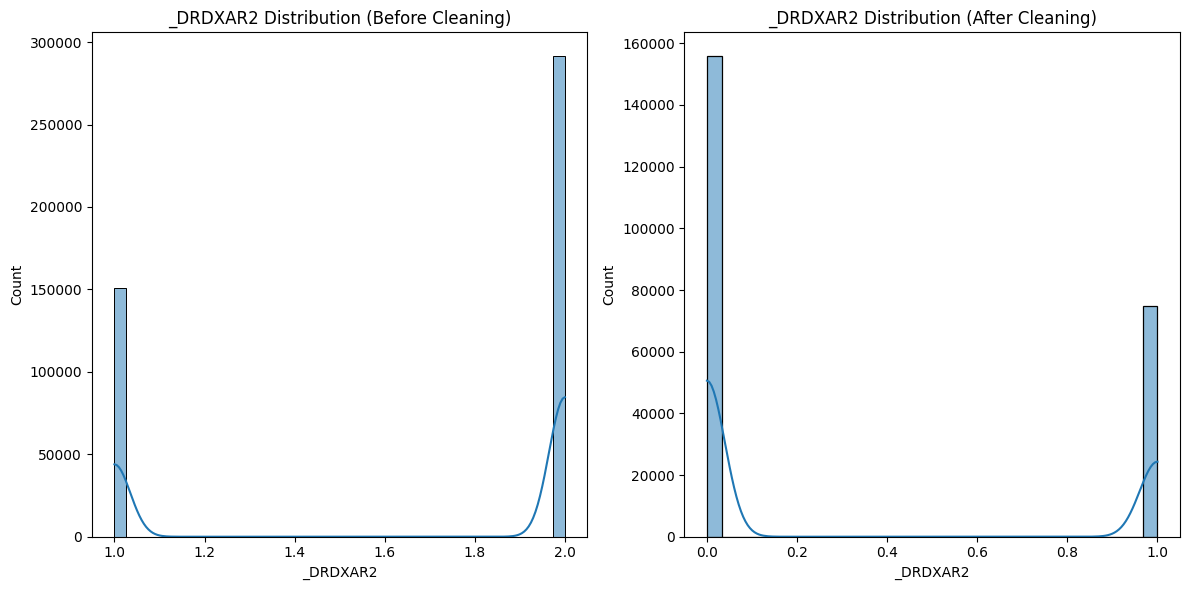

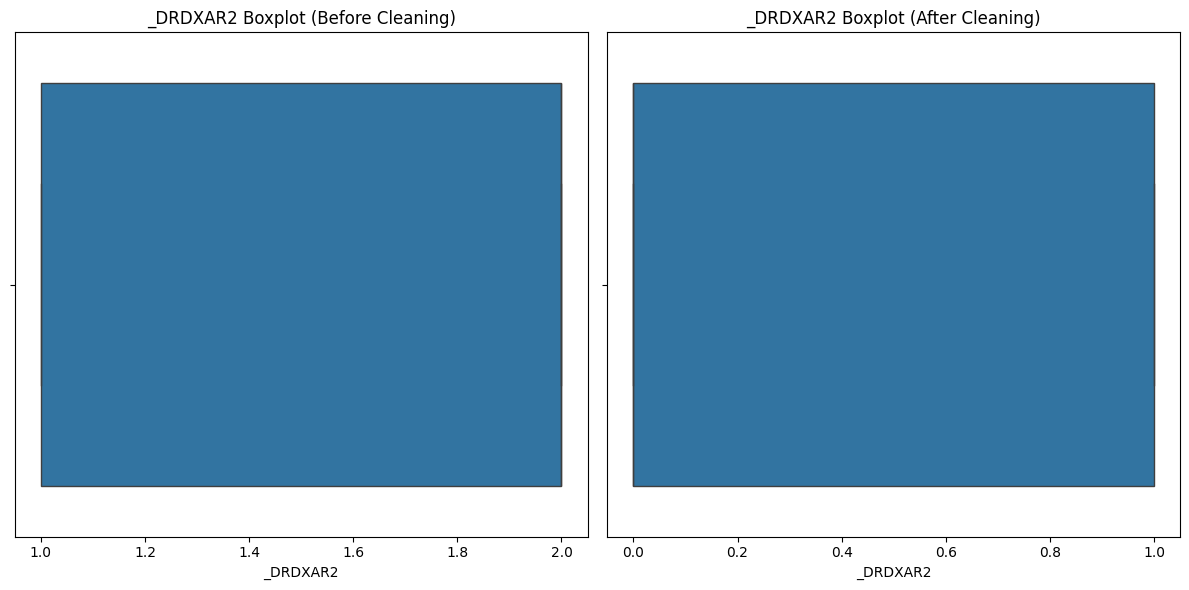

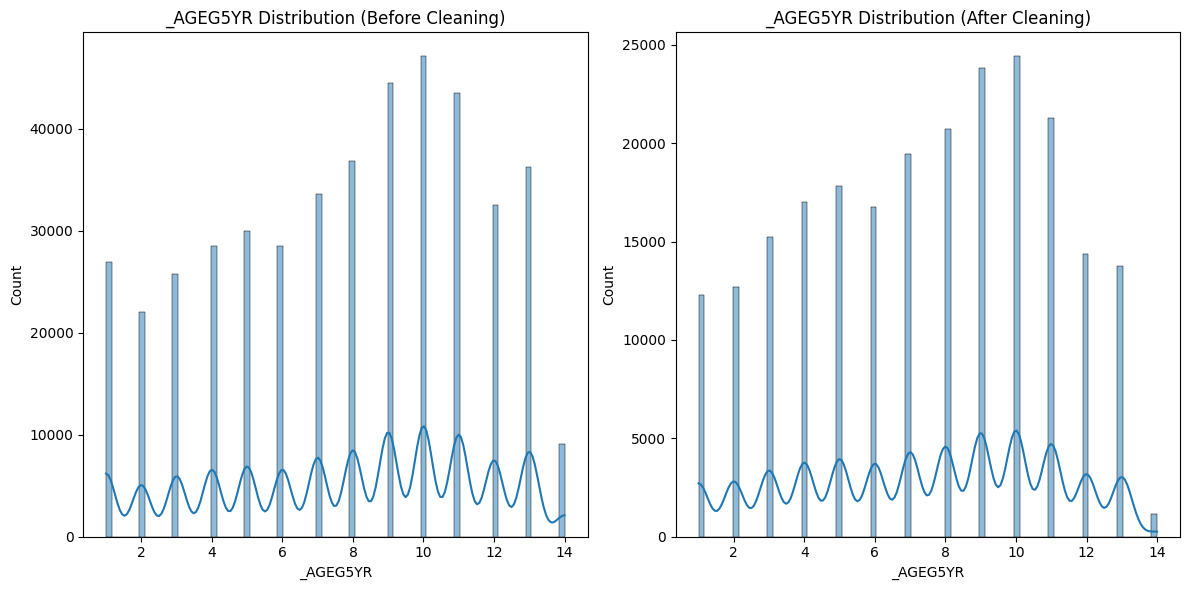

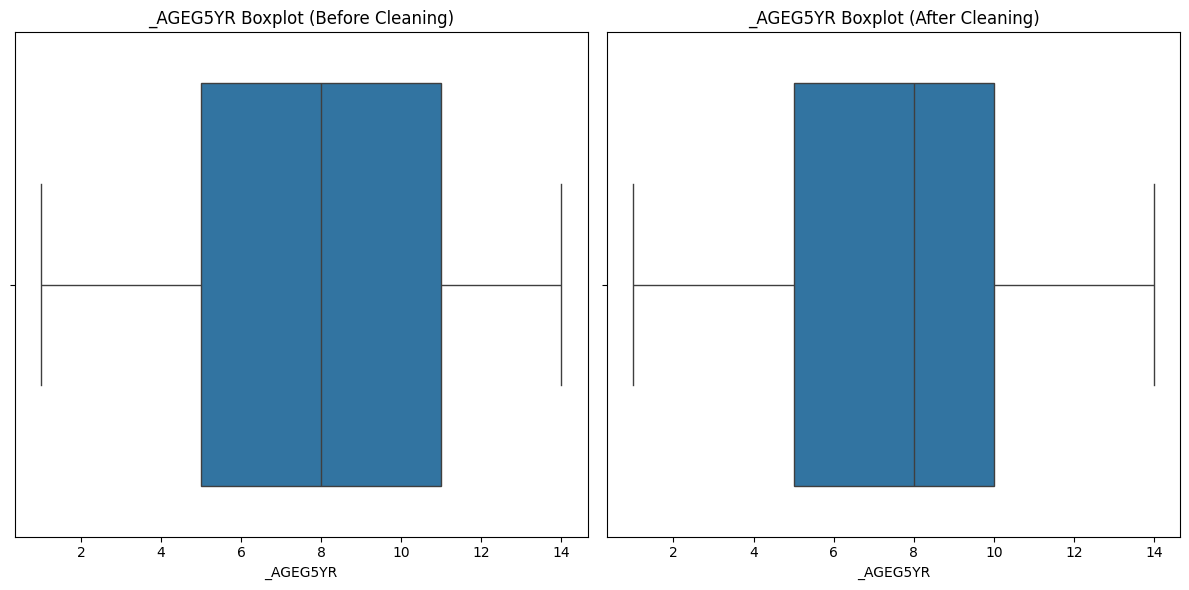

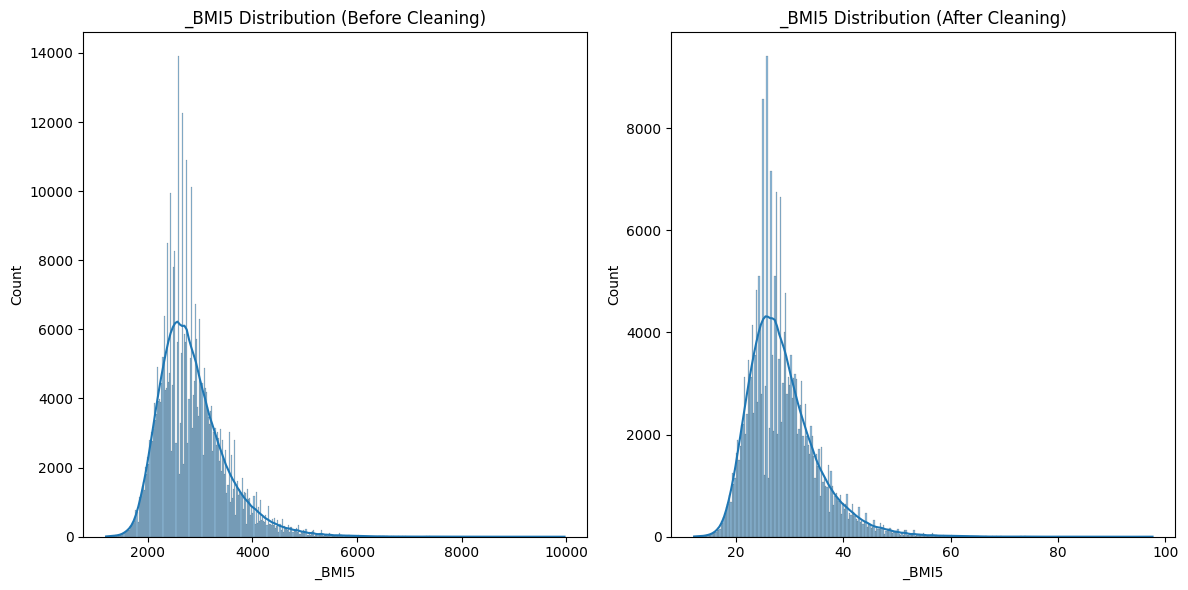

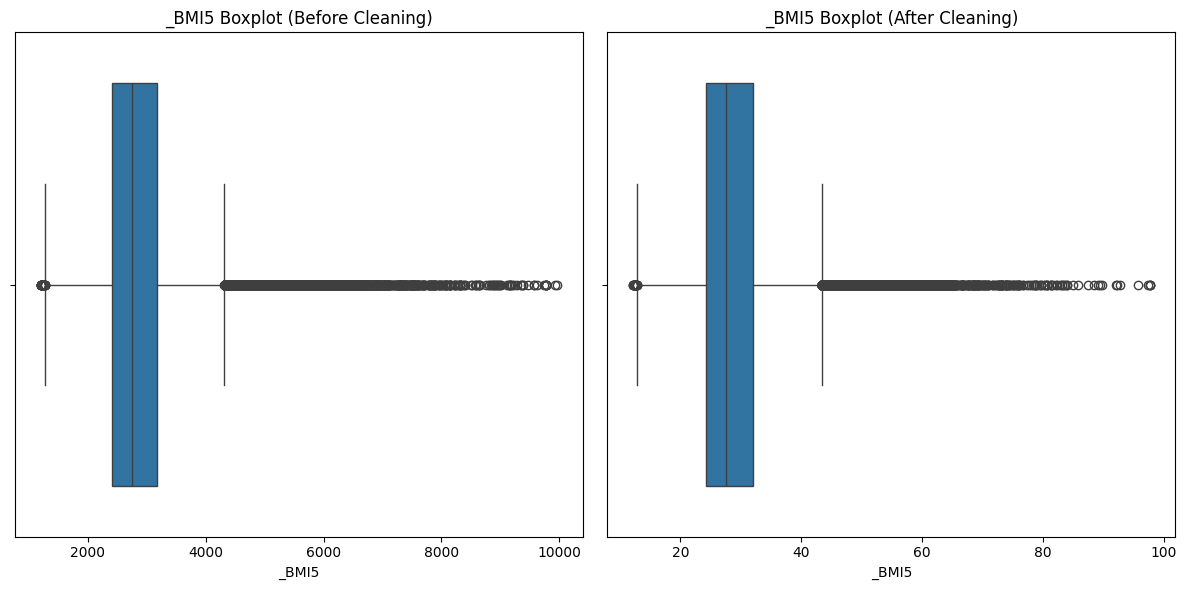

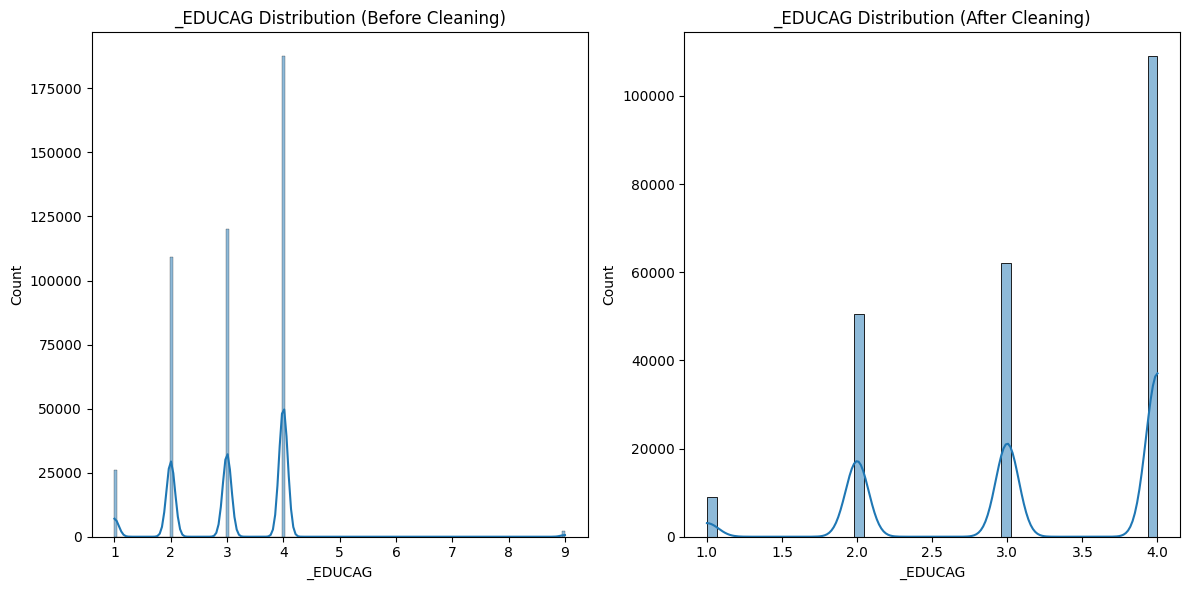

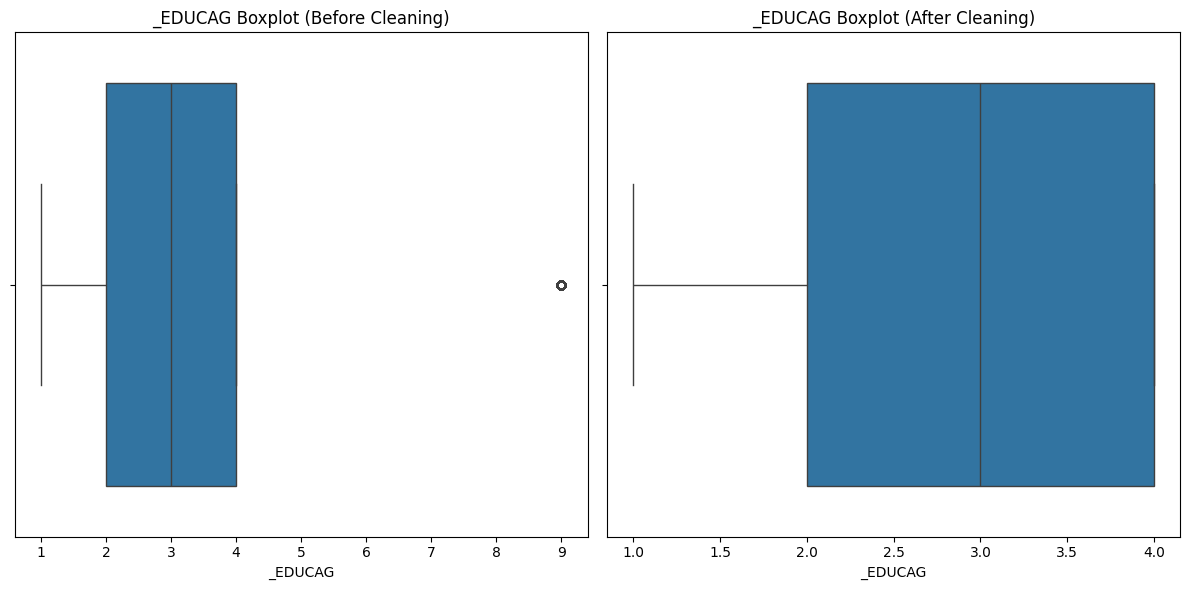

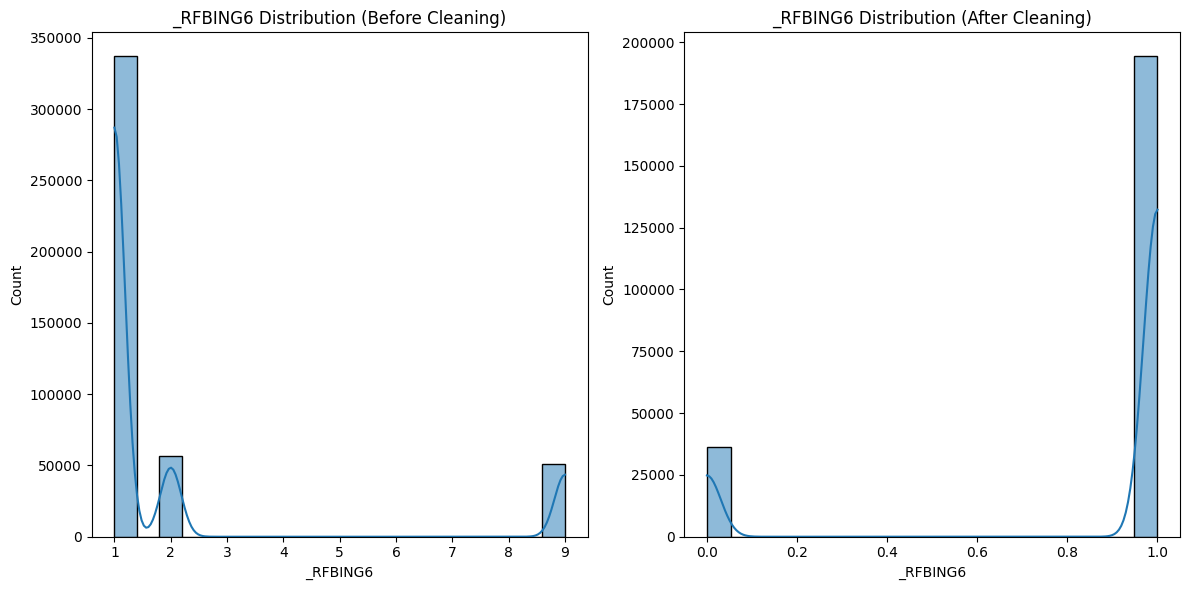

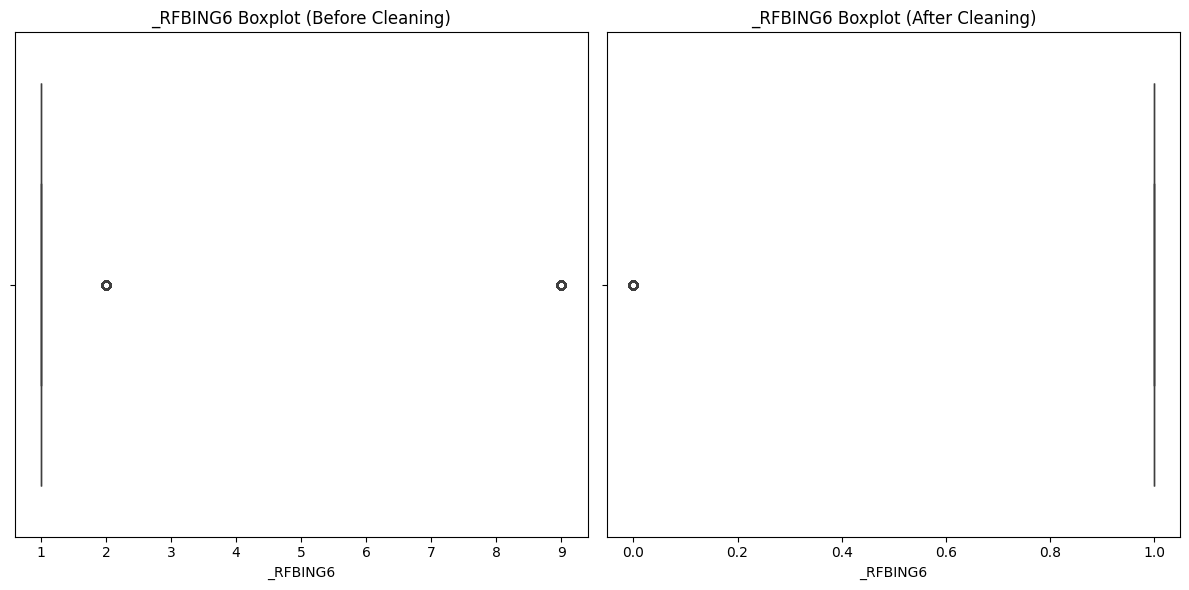

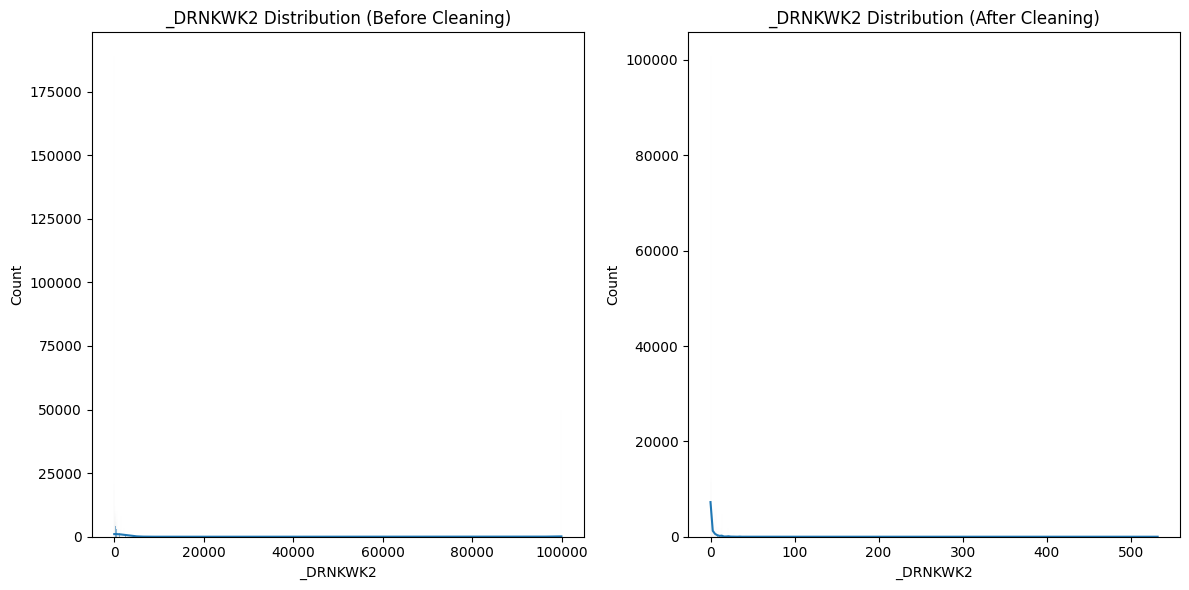

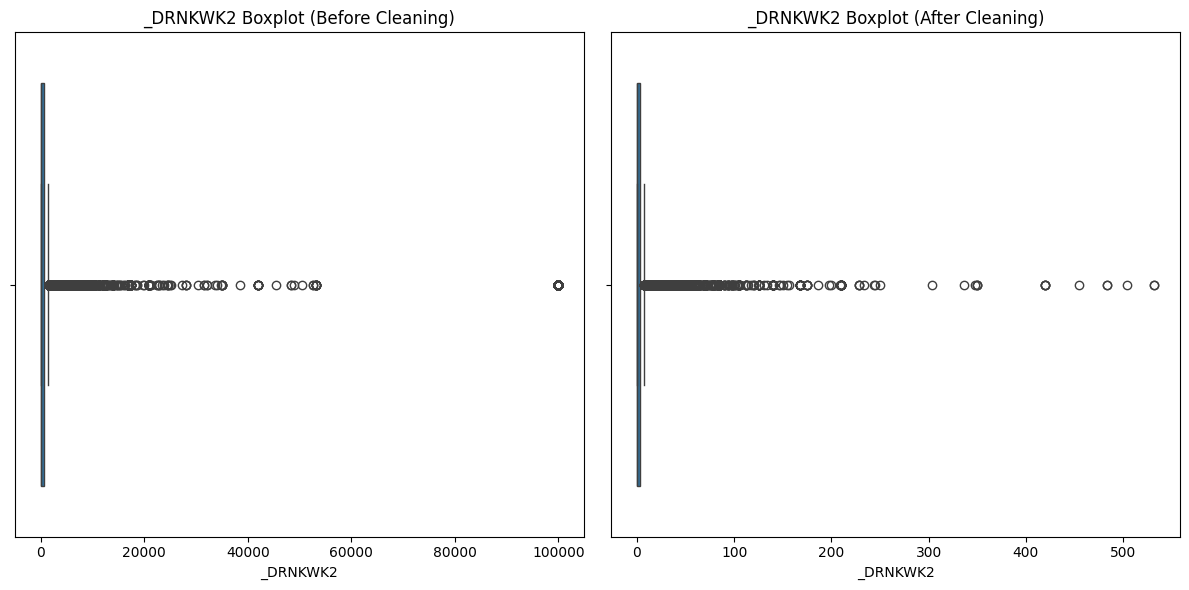

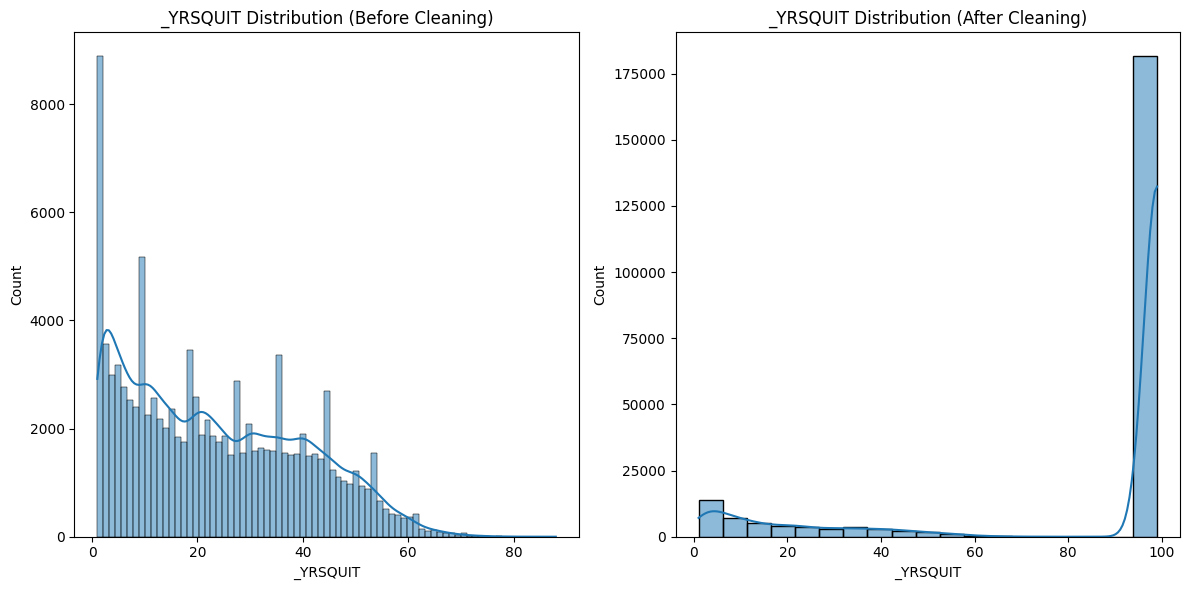

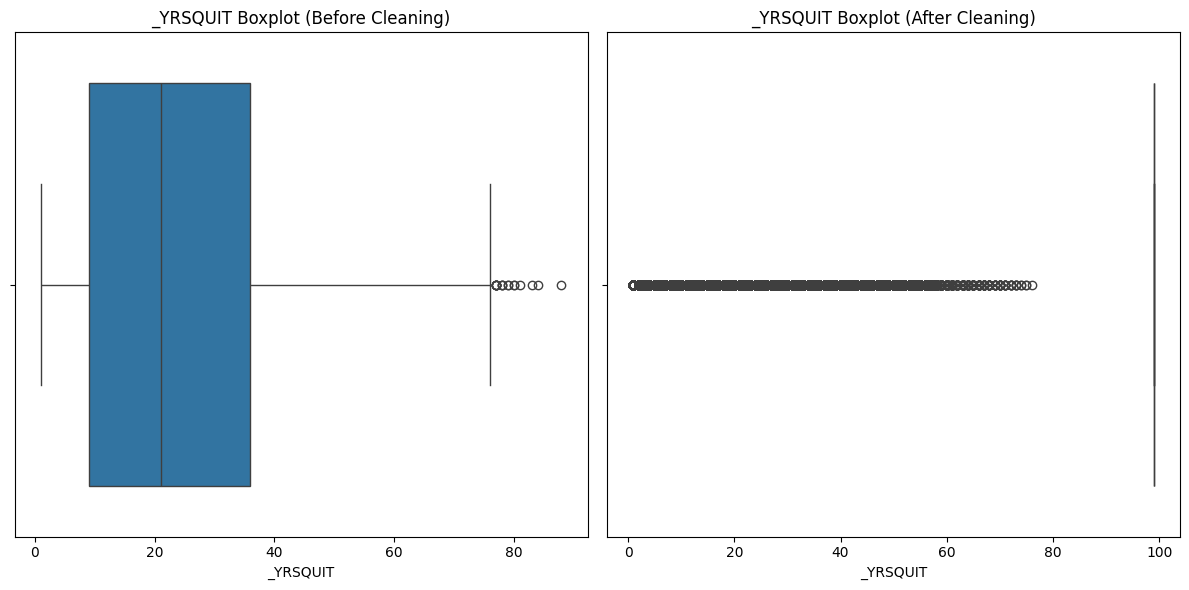

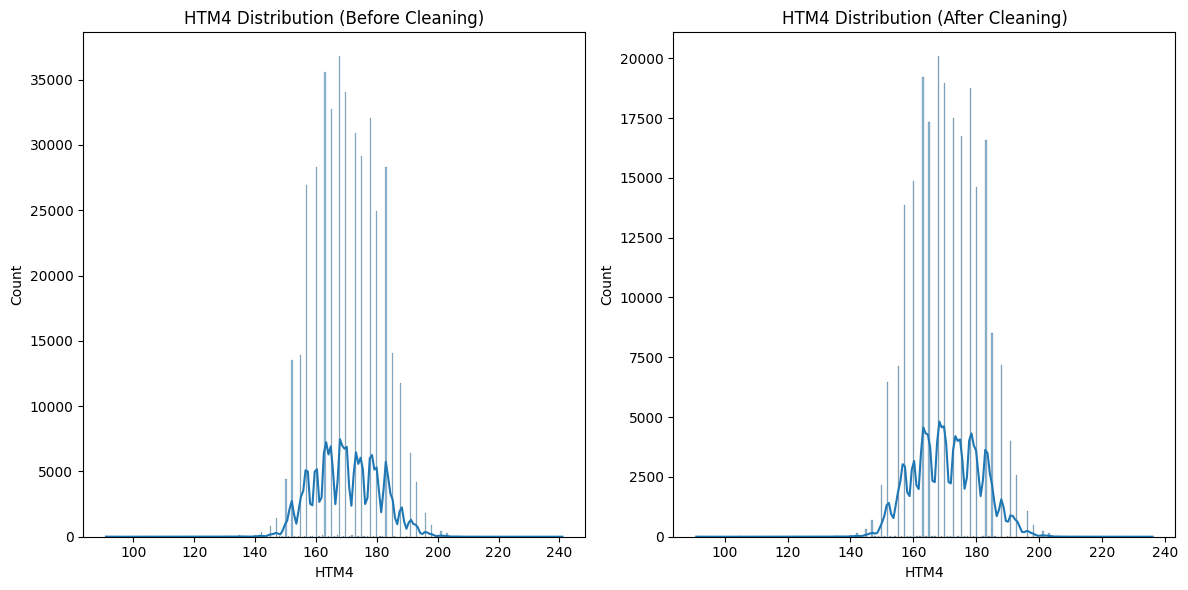

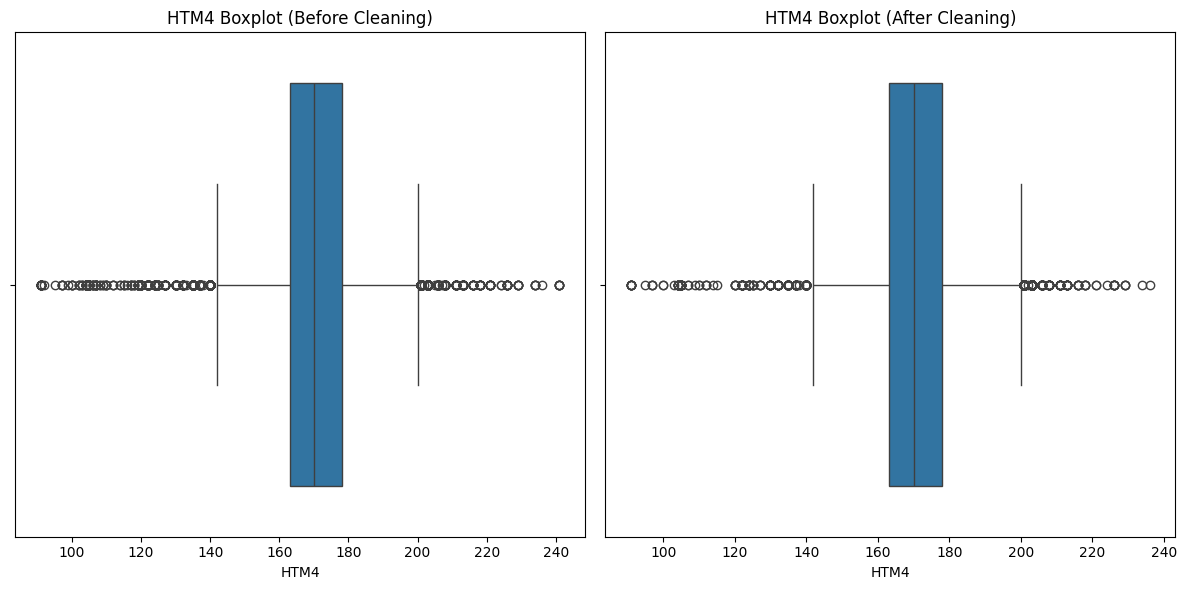

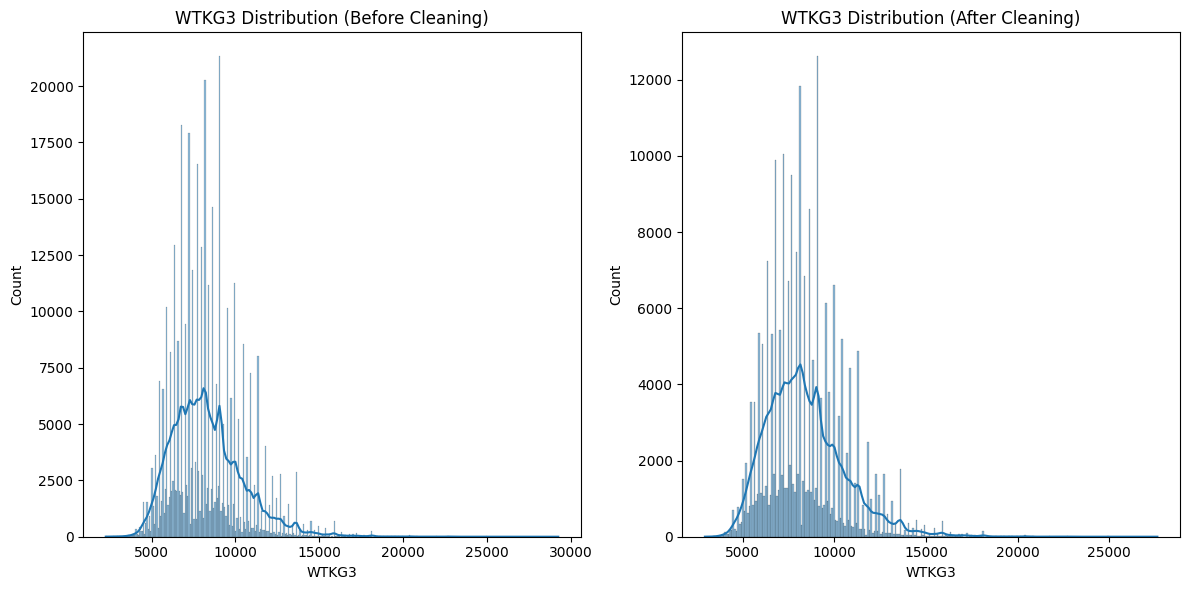

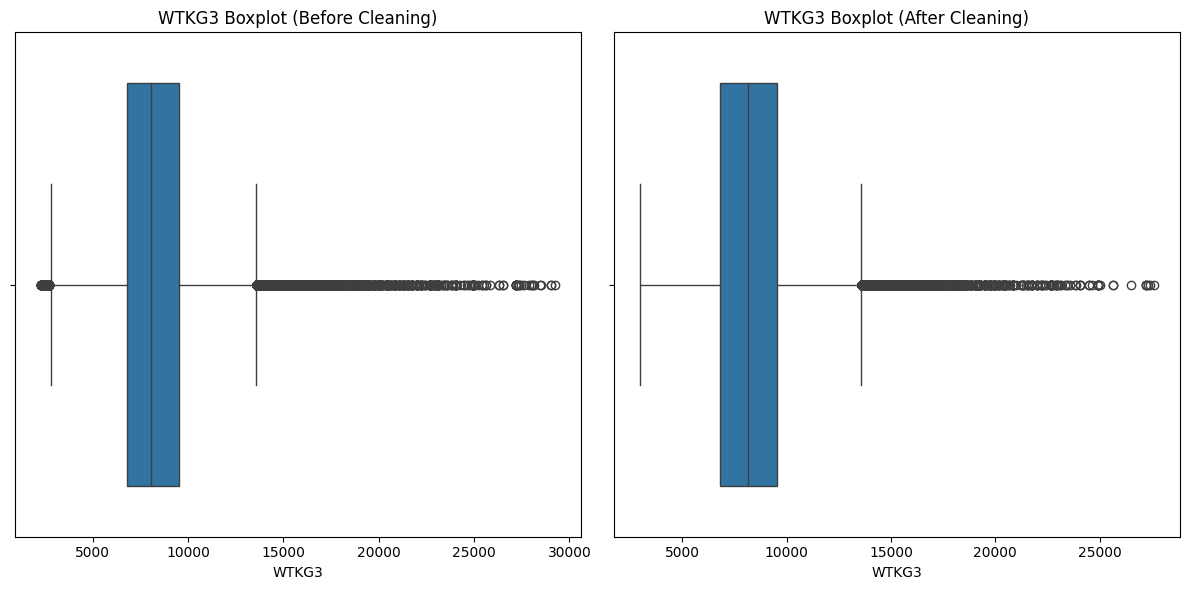

In [25]:
for c in df:
    if c not in original_df:
        continue
    helpers.plot_distribution_comparison(original_df, df, c)
    helpers.plot_boxplot_comparison(original_df, df, c)

In [26]:
print(f'Original rows: {len(original_df)}')
print(f'Cleaned rows: {len(df)}')

print(f'Percentage retained: {len(df) / len(original_df)}')

Original rows: 445132
Cleaned rows: 230693
Percentage retained: 0.5182575056387768


In [27]:
df.columns

Index(['_SEX', 'GENHLTH', 'POORHLTH', 'PRIMINSR', 'PERSDOC3', 'MEDCOST1',
       'CHECKUP1', 'SLEPTIM1', 'LASTDEN4', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3',
       'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'RENTHOM1',
       'EMPLOY1', 'INCOME3', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'SMOKDAY2', 'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG',
       'MAXDRNKS', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP',
       'SDHFOOD1', 'SDHBILLS', 'SDHUTILS', 'SDHTRNSP', 'SDHSTRE1', '_METSTAT',
       '_URBSTAT', '_IMPRACE', '_PHYS14D', '_MENT14D', '_TOTINDA', '_LTASTH1',
       '_CASTHM1', '_ASTHMS1', '_DRDXAR2', '_AGEG5YR', '_BMI5', '_EDUCAG',
       '_RFBING6', '_DRNKWK2', '_YRSQUIT', 'HTM4', 'WTKG3', 'diabetes'],
      dtype='object')

In [28]:
df.to_feather('cleaned_dataset.feather')

# Resulting cleaned dataframe: 


- **_SEX**: The respondent's sex based on their reported gender identity. Binary: {0: 'Female', 1: 'Male'}.

- **GENHLTH**: Respondent's self-reported general health status. Ordinal

- **POORHLTH**: Number of days in the past 30 days when the respondent's physical or mental health was not good. Ordinal.

- **PRIMINSR**: Primary source of the respondent's health insurance. Categorical: {1: 'employer', 2: 'private', 3: 'medicare', 4: 'medigap', 5: 'medicaid', 6: 'CHIP', 7: 'tricare/VA', 8: 'indian', 9: 'state', 10: 'other', 88: 'none'}.

- **PERSDOC3**: Whether the respondent has a personal doctor or health care provider. Binary: {True: 'Yes', False: 'No'}.

- **MEDCOST1**: Whether the respondent could not see a doctor in the past 12 months due to cost. Binary: {1: 'Yes', 0: 'No'}.

- **CHECKUP1**: The time since the respondent's last routine checkup. Ordinal

- **SLEPTIM1**: Average number of hours of sleep the respondent gets in a 24-hour period. Ordinal (1 to 24).

- **LASTDEN4**: Time since the respondent's last dental visit. Ordinal

- **CVDINFR4**: Whether the respondent was ever told they had a heart attack. Binary: {1: 'Yes', 0: 'No'}.

- **CVDCRHD4**: Whether the respondent was ever told they had angina or coronary heart disease. Binary: {1: 'Yes', 0: 'No'}.

- **CVDSTRK3**: Whether the respondent was ever told they had a stroke. Binary: {1: 'Yes', 0: 'No'}.

- **CHCSCNC1**: Whether the respondent was ever told they had skin cancer. Binary: {1: 'Yes', 0: 'No'}.

- **CHCOCNC1**: Whether the respondent was ever told they had another type of cancer. Binary: {1: 'Yes', 0: 'No'}.

- **CHCCOPD3**: Whether the respondent was ever told they had chronic obstructive pulmonary disease (COPD), emphysema, or chronic bronchitis. Binary: {1: 'Yes', 0: 'No'}.

- **ADDEPEV3**: Whether the respondent was ever told they had a depressive disorder, including depression, major depression, dysthymia, or minor depression. Binary: {1: 'Yes', 0: 'No'}.

- **CHCKDNY2**: Whether the respondent was ever told they had kidney disease, excluding kidney stones, bladder infection, or incontinence. Binary: {1: 'Yes', 0: 'No'}.

- **RENTHOM1**: Respondent's home ownership status. Categorical: {1: 'own', 2: 'rent', 3: 'other'}.

- **EMPLOY1**: Employment status of the respondent. Categorical: {1: 'employed', 2: 'self-employed', 3: 'long-term unemployed', 4: 'short-term unemployed', 5: 'homemaker', 6: 'student', 7: 'retired', 8: 'unable to work'}.

- **INCOME3**: Respondent's annual household income. Ordinal.

- **DIFFWALK**: Whether the respondent has serious difficulty walking or climbing stairs. Binary: {1: 'Yes', 0: 'No'}.

- **DIFFDRES**: Whether the respondent has serious difficulty dressing or bathing. Binary: {1: 'Yes', 0: 'No'}.

- **DIFFALON**: Whether the respondent has difficulty doing errands alone due to a physical, mental, or emotional condition. Binary: {1: 'Yes', 0: 'No'}.

- **SMOKE100**: Whether the respondent has smoked at least 100 cigarettes in their lifetime. Binary: {1: 'Yes', 0: 'No'}.

- **SMOKDAY2**: The frequency of smoking by current smokers. Ordinal values reordered: 'every day', 'some days', 'not at all'.

- **USENOW3**: Whether the respondent uses any tobacco product every day, some days, or not at all. Ordinal values reordered from least to most

- **ECIGNOW2**: Whether the respondent currently uses e-cigarettes every day, some days, or not at all. Ordinal values reordered from least to most
 
- **LCSFIRST**: The age at which the respondent first started using combustible tobacco. Ordinal (age values).

- **LCSLAST**: The age at which the respondent last used combustible tobacco. Ordinal (age values).

- **LCSNUMCG**: The number of combustible tobacco products the respondent uses in a typical day. Ordinal.

- **ALCDAY4**: The average number of alcoholic drinks the respondent consumes on the days they drink. Ordinal.

- **MAXDRNKS**: The maximum number of alcoholic drinks the respondent consumed on any occasion in the past 30 days. Ordinal.

- **LSATISFY**: Respondent's level of life satisfaction. Ordinal values.

- **EMTSUPRT**: How often the respondent gets the social and emotional support they need. Ordinal.

- **SDHISOLT**: Whether the respondent has felt isolated from others. Ordinal.

- **SDHEMPLY**: Whether the respondent felt that their work or financial situation negatively affected their well-being. Ordinal.

- **FOODSTMP**: Whether the respondent received food stamps in the past 12 months. Binary: {1: 'Yes', 0: 'No'}.

- **SDHFOOD1**: Whether the respondent worried about having enough money to buy nutritious meals. Ordinal.

- **SDHBILLS**: Whether the respondent was unable to pay their bills in the past 12 months. Binary: {1: 'Yes', 0: 'No'}.

- **SDHUTILS**: Whether the respondent could not afford to pay for utilities in the past 12 months. Binary: {1: 'Yes', 0: 'No'}.

- **SDHTRNSP**: Whether the respondent had difficulty finding transportation to get to places. Binary: {1: 'Yes', 0: 'No'}.

- **SDHSTRE1**: Whether the respondent experienced stress at home in the past 12 months. Binary: {1: 'Yes', 0: 'No'}.

- **_METSTAT**: The respondent's metropolitan status. Binary: {1: 'metropolitan', 0: 'non-metropolitan'}

- **_URBSTAT**: Urban or rural status of the respondent's residence. Binary: {1: 'urban', 0: 'rural'}

- **_IMPRACE**: Imputed race/ethnicity of the respondent. Categorical: {1: 'white', 2: 'black', 3: 'asian', 4: 'native american', 5: 'hispanic', 6: 'other'}.

- **_PHYS14D**: Number of days in the past 30 days that the respondent's physical health was not good. Ordinal.

- **_MENT14D**: Number of days in the past 30 days that the respondent's mental health was not good. Ordinal.

- **_TOTINDA**: Whether the respondent engaged in any physical activity or exercise other than their regular job in the past 30 days. Binary: {1: 'Yes', 0: 'No'}.

- **_LTASTH1**: Whether the respondent has ever been told by a doctor or other health professional that they have asthma. Binary: {1: 'Yes', 0: 'No'}.

- **_CASTHM1**: Whether the respondent still has asthma. Binary: {1: 'Yes', 0: 'No'}.

- **_ASTHMS1**: Whether the respondent's asthma was controlled with medication or treatment. Binary: {1: 'Yes', 0: 'No'}.

- **_DRDXAR2**: Whether the respondent was ever told they have arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia. Binary: {1: 'Yes', 0: 'No'}.

- **_AGEG5YR**: The respondent's age grouped in 5-year intervals. Ordinal.

- **_BMI5**: Body Mass Index (BMI) calculated based on the respondent's reported height and weight. Ordinal.

- **_EDUCAG**: Highest level of education completed by the respondent. Ordinal.

- **_RFBING6**: Whether the respondent is a binge drinker, defined as consuming 5 or more drinks for men, or 4 or more drinks for women, on one occasion in the past 30 days. Binary: {1: 'Yes', 0: 'No'}.

- **_DRNKWK2**: Number of days the respondent drank alcohol in the past week. Ordinal.

- **_YRSQUIT**: Number of years since the respondent quit smoking..

- **HTM4**: Respondent's height in meters. Continuous numerical value.

- **WTKG3**: Respondent's weight in kilograms. Continuous numerical value.



# Data Cleaning Summary

## Process Overview
This notebook performed extensive data cleaning on the 2022 BRFSS Survey Data from CDC. The cleaning process involved several key steps:

1. Initial data loading and type conversion
2. Handling of missing and unknown values
3. Recoding of categorical variables
4. Imputation of missing values
5. Dropping of unusable or redundant columns
6. Final handling of remaining missing values
7. Examination and adjustment of variable distributions

## Key Findings and Challenges

### Missing Data and Data Retention
- Initially, several columns had a high percentage of missing values.
- We used a combination of dropping rows with missing values and imputation to address this issue.
- The final dataset retained 50.88% of the original rows:
  - Original rows: 445,132
  - Cleaned rows: 226,472

### Data Recoding
- Many categorical variables were recoded to be more intuitive (e.g., changing Yes/No from 1/2 to 1/0).
- Some ordinal variables were reordered to ensure a logical progression (e.g., smoking frequency).

### Imputation
- Mode imputation was used for several categorical variables where missing values were likely due to skip patterns in the survey.

### Column Removal
- Several columns were removed due to:
  1. Direct relation to the target variable (to prevent data leakage)
  2. Insufficient sample size
  3. Redundancy (when better computed variables were available)

### Distribution Examination
- After the cleaning process was completed, a thorough examination of box plots and distributions for all variables was conducted.
- The distributions of relevant input variables were similar and/or as expected compared to their pre-cleaning states. This consistency provides some reassurance that the cleaning process has likely preserved important statistical properties of the data.

## Potential Impact on Analysis
1. While nearly half of the rows were removed, the consistency in distribution shapes before and after cleaning suggests that the overall statistical characteristics of the dataset were preserved.
2. The imputation of mode values for certain categorical variables assumes that missing values follow the most common pattern, which may not always be accurate.
3. The recoding of variables, while making them more intuitive, assumes certain relationships (e.g., linear progression in ordinal variables) which should be kept in mind during analysis.
